In [1]:
import os
import pickle
import findspark
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm

from IPython.display import display
from pprint import pprint
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from dateutil.relativedelta import relativedelta

path = os.getcwd()

In [2]:
findspark.init()
findspark.find()

'C:\\spark-3.1.2-bin-hadoop3.2'

In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col, avg, min, max, explode
from pyspark.ml.recommendation import ALS, ALSModel

### Chargement du dataFrame clients

In [4]:
pd.set_option("display.max_columns", None) # par défaut c'est '20'
dtypes = pd.read_csv(path + '/df_customers.csv', sep='\t', encoding='utf-8', nrows=1).iloc[0].to_dict()
df_customers = pd.read_csv(path + '/df_customers.csv', sep='\t', dtype=dtypes, encoding='utf-8', skiprows=[1])
df_customers.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [5]:
#df_customers.info()

### Observations des distribution de valeurs hors catégories

In [6]:
df_customers_num_values = df_customers[df_customers.columns.difference([
    'customer_unique_id',
    'customer_city',
    'customer_state',
    'customer_zip_code_prefix',
    'words_comments_title',
    'words_comments_message',
    'payment_type_boleto',
    'payment_type_credit_card',
    'payment_type_debit_card',
    'payment_type_voucher',
    'cat_auto',
    'cat_books',
    'cat_childhood',
    'cat_construction_tools',
    'cat_fashion_clothes_accessories',
    'cat_food',
    'cat_gifts_art_decoration',
    'cat_health_beauty_hygiene',
    'cat_high_tech',
    'cat_home_comfort_appliance',
    'cat_home_office_furniture',
    'cat_professional',
    'cat_telephony',
    'cat_unknown',
    'cat_video_audio_instruments'
])]

In [7]:
df_customers_num_values.isna().sum()

centroid_lat                  0
centroid_lng                  0
customer_mean_order           0
max_items_type_ordered        0
max_number_payments_spread    0
max_number_payments_type      0
max_sellers_ordered           0
mean_delivery_time            0
mean_perct_freight            0
mean_reviews_score            0
mean_time_between_order       0
number_orders                 0
number_reviews                0
order_status                  0
product_density               0
product_photos_qty            0
total_payments_amount         0
total_products_ordered        0
dtype: int64

In [8]:
df_customers_num_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   centroid_lat                95420 non-null  float64
 1   centroid_lng                95420 non-null  float64
 2   customer_mean_order         95420 non-null  float64
 3   max_items_type_ordered      95420 non-null  float64
 4   max_number_payments_spread  95420 non-null  float64
 5   max_number_payments_type    95420 non-null  float64
 6   max_sellers_ordered         95420 non-null  float64
 7   mean_delivery_time          95420 non-null  float64
 8   mean_perct_freight          95420 non-null  float64
 9   mean_reviews_score          95420 non-null  float64
 10  mean_time_between_order     95420 non-null  float64
 11  number_orders               95420 non-null  int64  
 12  number_reviews              95420 non-null  int64  
 13  order_status                954

In [9]:
df_customers_num_values.max()

centroid_lat                     42.184003
centroid_lng                     -8.723762
customer_mean_order           13440.000000
max_items_type_ordered            8.000000
max_number_payments_spread       24.000000
max_number_payments_type         29.000000
max_sellers_ordered               5.000000
mean_delivery_time              209.628611
mean_perct_freight             2144.705882
mean_reviews_score                5.000000
mean_time_between_order         609.978912
number_orders                    16.000000
number_reviews                   16.000000
order_status                      2.000000
product_density               13618.860000
product_photos_qty               96.000000
total_payments_amount         13664.080000
total_products_ordered           24.000000
dtype: float64

In [10]:
# Vérification de valeurs résiduelles inf ?
inspect_inf_values = df_customers_num_values['product_density'].isin([np.inf, -np.inf])
display(df_customers_num_values.loc[inspect_inf_values])
print(df_customers_num_values.loc[inspect_inf_values].index)

Empty DataFrame
Columns: [centroid_lat, centroid_lng, customer_mean_order, max_items_type_ordered, max_number_payments_spread, max_number_payments_type, max_sellers_ordered, mean_delivery_time, mean_perct_freight, mean_reviews_score, mean_time_between_order, number_orders, number_reviews, order_status, product_density, product_photos_qty, total_payments_amount, total_products_ordered]
Index: []

Int64Index([], dtype='int64')


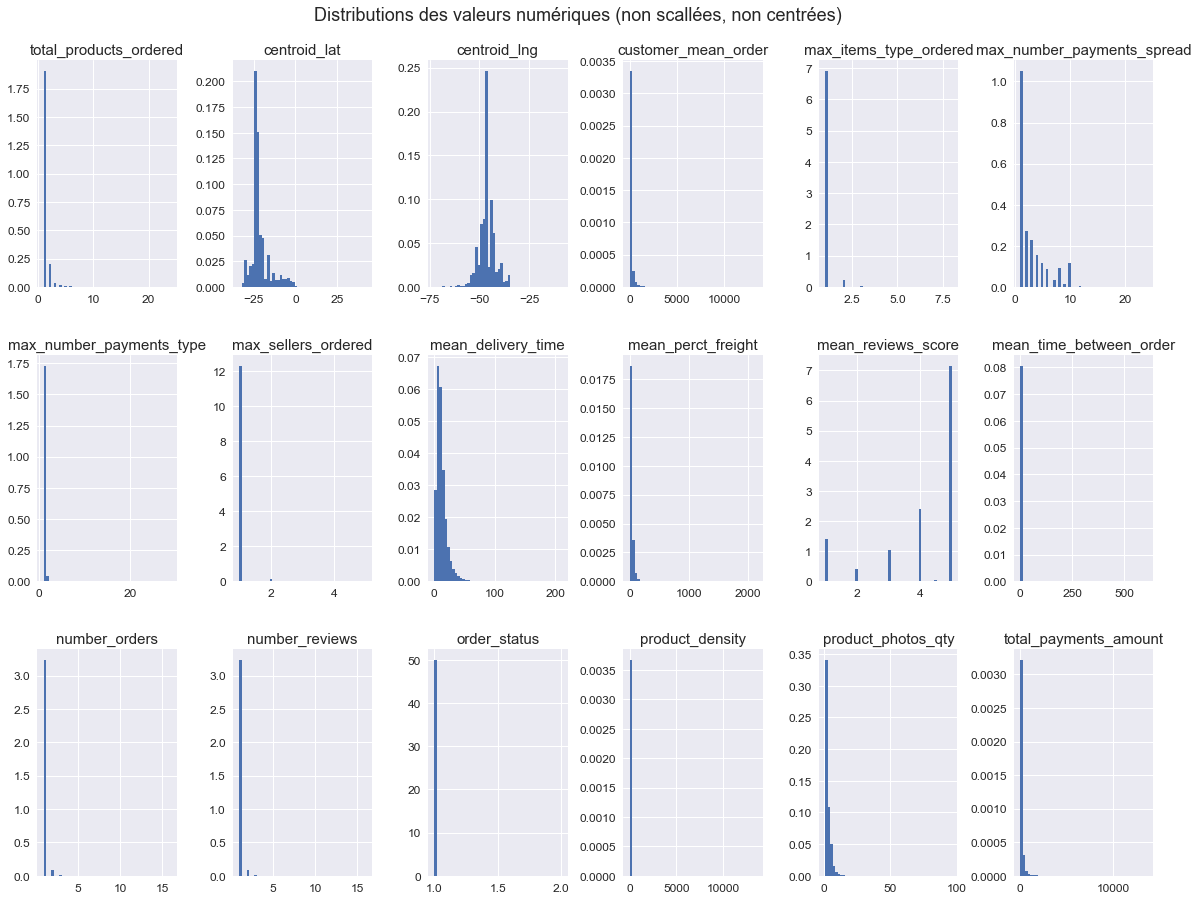

In [11]:
# Affichage des distributions
plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for feat_idx in range(len(df_customers_num_values.columns)):
    ax = fig.add_subplot(3,6, (feat_idx+1))
    graph = ax.hist(df_customers_num_values.iloc[:, feat_idx-1], bins=50, density=True)
    ax.set_title(df_customers_num_values.columns[feat_idx-1], fontsize=15)
    ax.tick_params(labelsize=12)

plt.suptitle("Distributions des valeurs numériques (non scallées, non centrées)", fontsize=18, y=0.93)    
plt.show()

### Analyse en composantes principales (PCA)

In [12]:
median = df_customers_num_values.median()
median.name = "median"
df_customers_num_values.describe().append(median).sort_index()['max' : 'std']

centroid_lat  centroid_lng  customer_mean_order  \
max        42.184003     -8.723762         13440.000000   
mean      -21.163488    -46.172924           138.225720   
median    -22.922759    -46.631370            87.382500   
min       -33.689948    -72.668881             0.850000   
std         5.628180      4.059294           211.414089   

        max_items_type_ordered  max_number_payments_spread  \
max                   8.000000                   24.000000   
mean                  1.039059                    2.941899   
median                1.000000                    2.000000   
min                   1.000000                    1.000000   
std                   0.229401                    2.723023   

        max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
max                    29.000000             5.000000          209.628611   
mean                    1.045902             1.014043           12.567974   
median                  1.000000             1.000000           10.418484   
min                     1.000000             1.000000            0.533414   
std                     0.381575             0.124170            9.442742   

        mean_perct_freight  mean_reviews_score  mean_time_between_order  \
max            2144.705882            5.000000               609.978912   
mean             30.875174            4.087285                 3.459191   
median           22.570428            5.000000                 1.000000   
min               0.425261            1.000000                 1.000000   
std              31.004193            1.338381                23.424519   

        number_orders  number_reviews  order_status  product_density  \
max         16.000000       16.000000      2.000000     13618.860000   
mean         1.034018        1.034018      1.001247        15.850622   
median       1.000000        1.000000      1.000000         9.753750   
min          1.000000        1.000000      1.000000         0.011733   
std          0.211234        0.211234      0.035293        62.195565   

        product_photos_qty  total_payments_amount  total_products_ordered  
max              96.000000           13664.080000                24.00000  
mean              2.606958             166.070491                 1.18057  
median            2.000000             107.950000                 1.00000  
min               1.000000               9.590000                 1.00000  
std               2.349640             228.340711                 0.62145

#### Besoin de normaliser les données avant d'effectuer une PCA :
- moyenne à 0 (distributions centrées)
- variance normalisée par features (=1)
- StandardScaler dans ce cas de figure ici, reste le meilleure "transformeur" d'apèrs la documentation Sklearn parmis tous ceux disponibles pour la PCA.
- permet de cette manière que la PCA ne préviligie pas les features avec des plages de variances trop "larges" par rapport aux autres.
- Rappel : décorrélation des features s'il y en a (important)

In [13]:
print("Nombre de features initial : ", df_customers_num_values.shape[1])

Nombre de features initial :  18


In [14]:
# Imputation de la colonne des moyennes de livraisons (commandes pas encore livrées)
df_customers_num_values = df_customers_num_values.fillna(0)

In [15]:
# J'aimerais réduire le nombre de features par exemples avec 9 ou 10 composantes qui expliquent au mieux la variance du jeu de données
pipeline = Pipeline([
    ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), 
    ('reducer', PCA(n_components=0.8)) # Conservation de 80% de la variance expliquée
])

# Fit des données numériques du jeu de données
pc = pipeline.fit_transform(df_customers_num_values)

# Taux de variance expliqué en fonction du nombre de composantes
# 9 composantes expliquent au maximum 76% de la variance totale
arr_var_rate = pipeline.steps[1][1].explained_variance_ratio_
print("Taux de variance expliquée par composante :\n", arr_var_rate, "\n")
print("Taux de variance cumulé expliqué :\n", arr_var_rate.cumsum(), "\n")
print("Nombre de composantes PCA après réduction :", len(pipeline.steps[1][1].components_))

Taux de variance expliquée par composante :
 [0.17276614 0.12516034 0.09667084 0.09335306 0.06382747 0.05715809
 0.05601752 0.05363108 0.05069084 0.04605137] 

Taux de variance cumulé expliqué :
 [0.17276614 0.29792648 0.39459732 0.48795038 0.55177785 0.60893594
 0.66495346 0.71858454 0.76927538 0.81532675] 

Nombre de composantes PCA après réduction : 10


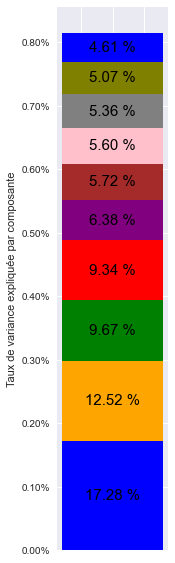

In [16]:
# Graphique de variance expliquée avec les 10 composantes créées
arr_var_rate = arr_var_rate.reshape(1, -1)

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(2,10))  

x = 0
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
values_list = [x for x in arr_var_rate[0]]

for idx in range(arr_var_rate.shape[1]):
    ax.bar(
        x, arr_var_rate[0][idx],
        bottom = np.sum(arr_var_rate[0][:idx], axis=0),
        color = colors[idx % len(colors)],
    )
    
for rect, value in zip(ax.patches, values_list):
    h = rect.get_height() / 2
    w = rect.get_width() / 2
    x, y = rect.get_xy()
    ax.text(
        x + w,
        y + h,
        "{:.2f} %".format(value*100),
        horizontalalignment='center',
        verticalalignment='center',
        color='black',
        fontsize=15
    )
    
ax.set_ylabel("Taux de variance expliquée par composante")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.tick_params(axis='x', labelbottom=False)
plt.show()

In [17]:
print("Feature 1 de la PCA :", pc[:, :1], '\n')

# Affichage de la première composante (=combinaison linéaire des features)
print("Première composante principale :", pipeline.steps[1][1].components_[1], "\n")

# Détermination des features les plus importantes pour chaque composantes principales
most_important_features_idx = [np.abs(pipeline.steps[1][1].components_[x]).argmax() for x in range(len(pipeline.steps[1][1].components_))]
print("Index de la feature la plus importante par composante :", most_important_features_idx , "\n")

# Affichage des deux premières composantes principales / correspondance avec les colonnes
features_names = df_customers_num_values.columns.tolist()
print("Nom des features du dataset initial :", features_names, "\n")

# Les features les plus importantes déterminées à partir de l'index retourné
pc_nbr = len(pipeline.steps[1][1].components_) # nombre de composantes
most_important_features = [features_names[most_important_features_idx[y]] for y in range(pc_nbr)]
most_important_feature_by_pc = ['pc{}: {}'.format(x, z) for x, z in enumerate(most_important_features)]
display(most_important_feature_by_pc)

Feature 1 de la PCA : [[-0.31997262]
 [-0.96150231]
 [-0.11815302]
 ...
 [-0.33700569]
 [-0.27819834]
 [-0.60967982]] 

Première composante principale : [ 0.08161133  0.0566375   0.57323469  0.04139511  0.29771083 -0.01943036
  0.04260225  0.09091367 -0.28741368 -0.07640194 -0.20038521 -0.26172435
 -0.26172435 -0.08696003 -0.04630534 -0.0081524   0.532438   -0.04324795] 

Index de la feature la plus importante par composante : [11, 2, 3, 0, 9, 14, 5, 13, 13, 8] 

Nom des features du dataset initial : ['centroid_lat', 'centroid_lng', 'customer_mean_order', 'max_items_type_ordered', 'max_number_payments_spread', 'max_number_payments_type', 'max_sellers_ordered', 'mean_delivery_time', 'mean_perct_freight', 'mean_reviews_score', 'mean_time_between_order', 'number_orders', 'number_reviews', 'order_status', 'product_density', 'product_photos_qty', 'total_payments_amount', 'total_products_ordered'] 



['pc0: number_orders',
 'pc1: customer_mean_order',
 'pc2: max_items_type_ordered',
 'pc3: centroid_lat',
 'pc4: mean_reviews_score',
 'pc5: product_density',
 'pc6: max_number_payments_type',
 'pc7: order_status',
 'pc8: order_status',
 'pc9: mean_perct_freight']

In [18]:
df_pca_exploration = df_customers.copy()
df_pca_exploration.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [19]:
# On ajoute les 10 features de la PCA au DataFrame initial
# Rappel : 10 composantes et 10 features (réduction de dimensions par conservation de variance expliquée)
for pc_idx in range(pc.shape[1]):
    #print(pc_idx)
    #print(pipeline.steps[1][1].components_[pc_idx])
    pc_name = "PC_" + str(pc_idx+1)
    df_pca_exploration[pc_name] = pc[:, pc_idx]

In [20]:
df_pca_exploration.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

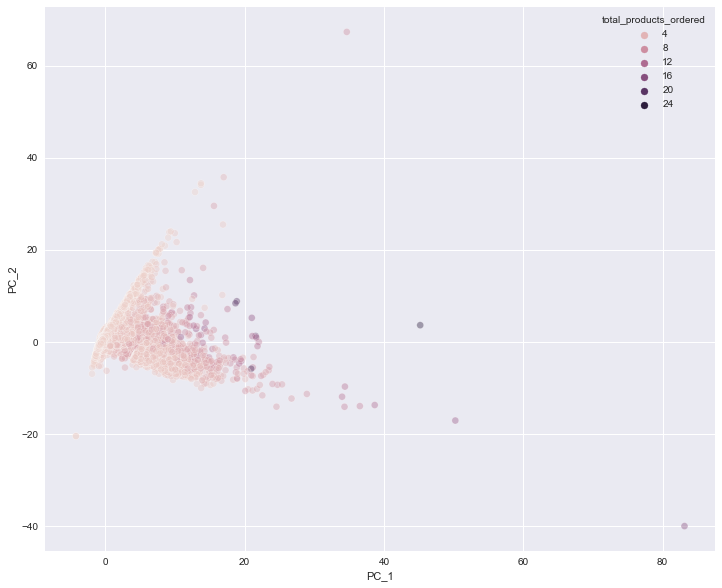

In [21]:
# Exploration des composantes de la PCA en fonction d'autres features
fig, ax = plt.subplots(1, 1, figsize=(12,10))
#ax = sns.scatterplot(data=df_pca_exploration, x='PC_1', y='PC_2', hue='mean_time_between_order', alpha=0.4)
#ax = sns.scatterplot(data=df_pca_exploration, x='PC_1', y='PC_2', hue='max_items_type_ordered', alpha=0.4)
ax = sns.scatterplot(data=df_pca_exploration, x='PC_1', y='PC_2', hue='total_products_ordered', alpha=0.4)
plt.show()

In [22]:
# Astuce : un procédé d'inversion du get_dummies avec toutes les colonnes sans le drop n-1
payment_type_names = [
    'payment_type_boleto',
    'payment_type_credit_card',
    'payment_type_debit_card',
    'payment_type_voucher'
]
# Permet de retourner le nom de la colonne par ligne avec la valeur la plus élevée
df_pca_exploration['pref_payment_type'] = df_pca_exploration[payment_type_names].idxmax(axis=1)

In [23]:
df_pca_exploration.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

count                        95420
unique                           4
top       payment_type_credit_card
freq                         73074
Name: pref_payment_type, dtype: object


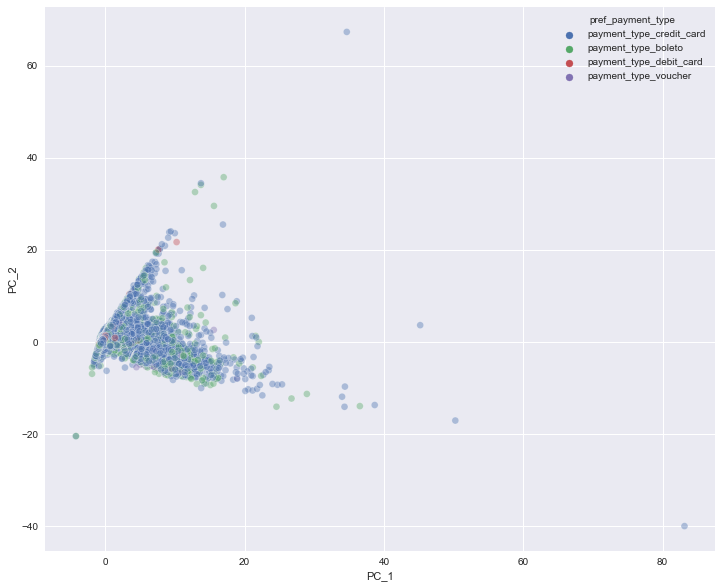

In [24]:
print(df_pca_exploration['pref_payment_type'].describe())
fig, ax = plt.subplots(1, 1, figsize=(12,10))
# On regarde les autres catégories sans 'payment_type_credit_card'
ax = sns.scatterplot(data=df_pca_exploration, x='PC_1', y='PC_2', hue='pref_payment_type', alpha=0.4)

In [25]:
cat_to_explore = [cat for cat in df_pca_exploration.columns if cat.startswith('payment_')]
#print(cat_to_explore)

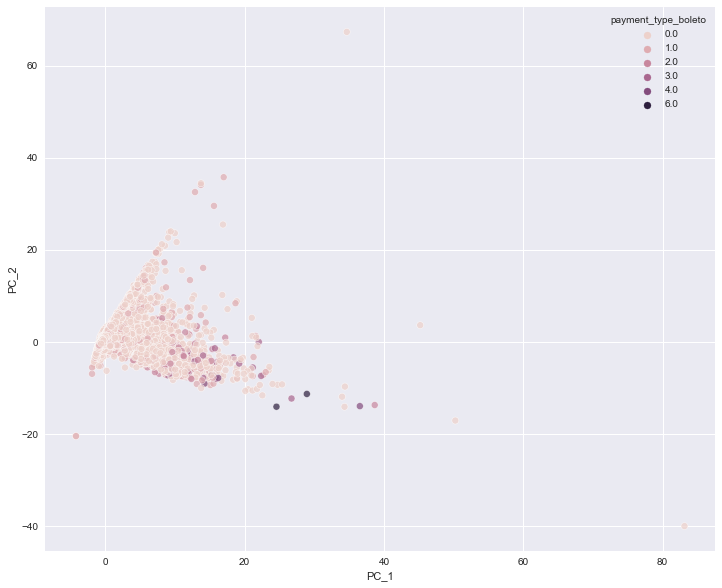

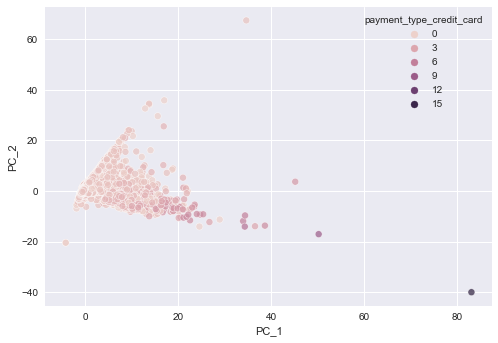

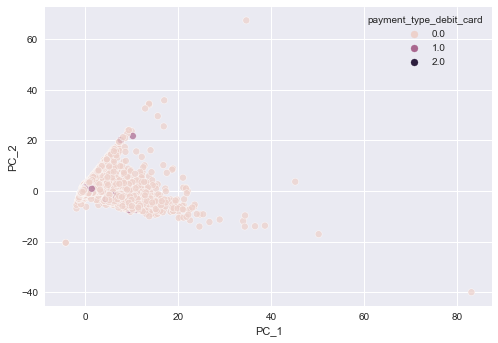

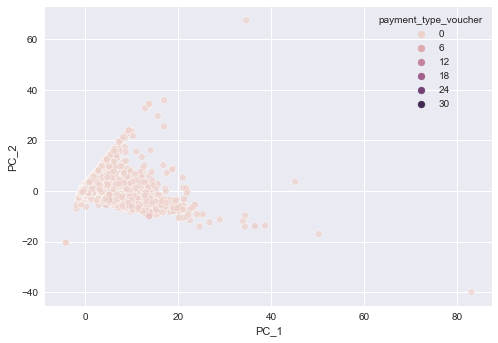

In [26]:
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1, figsize=(12,10)) 
for cat in cat_to_explore:
    ax = sns.scatterplot(data=df_pca_exploration, x='PC_1', y='PC_2', hue=cat, alpha=0.7)
    plt.show()

### KMeans première approche

#### Récap d'exploration des variables numériques préparées

In [27]:
# Evaluation grossière des données numériques -> round(0) -> pas représentatif à 100%
inspect_df_customer_num_values = \
df_customers_num_values[df_customers_num_values.columns.difference(['centroid_lat', 'centroid_lng'])]
inspect_df_customer_num_values.agg(['mean', 'median', 'std']).round(2)

customer_mean_order  max_items_type_ordered  \
mean                 138.23                    1.04   
median                87.38                    1.00   
std                  211.41                    0.23   

        max_number_payments_spread  max_number_payments_type  \
mean                          2.94                      1.05   
median                        2.00                      1.00   
std                           2.72                      0.38   

        max_sellers_ordered  mean_delivery_time  mean_perct_freight  \
mean                   1.01               12.57               30.88   
median                 1.00               10.42               22.57   
std                    0.12                9.44               31.00   

        mean_reviews_score  mean_time_between_order  number_orders  \
mean                  4.09                     3.46           1.03   
median                5.00                     1.00           1.00   
std                   1.34                    23.42           0.21   

        number_reviews  order_status  product_density  product_photos_qty  \
mean              1.03          1.00            15.85                2.61   
median            1.00          1.00             9.75                2.00   
std               0.21          0.04            62.20                2.35   

        total_payments_amount  total_products_ordered  
mean                   166.07                    1.18  
median                 107.95                    1.00  
std                    228.34                    0.62

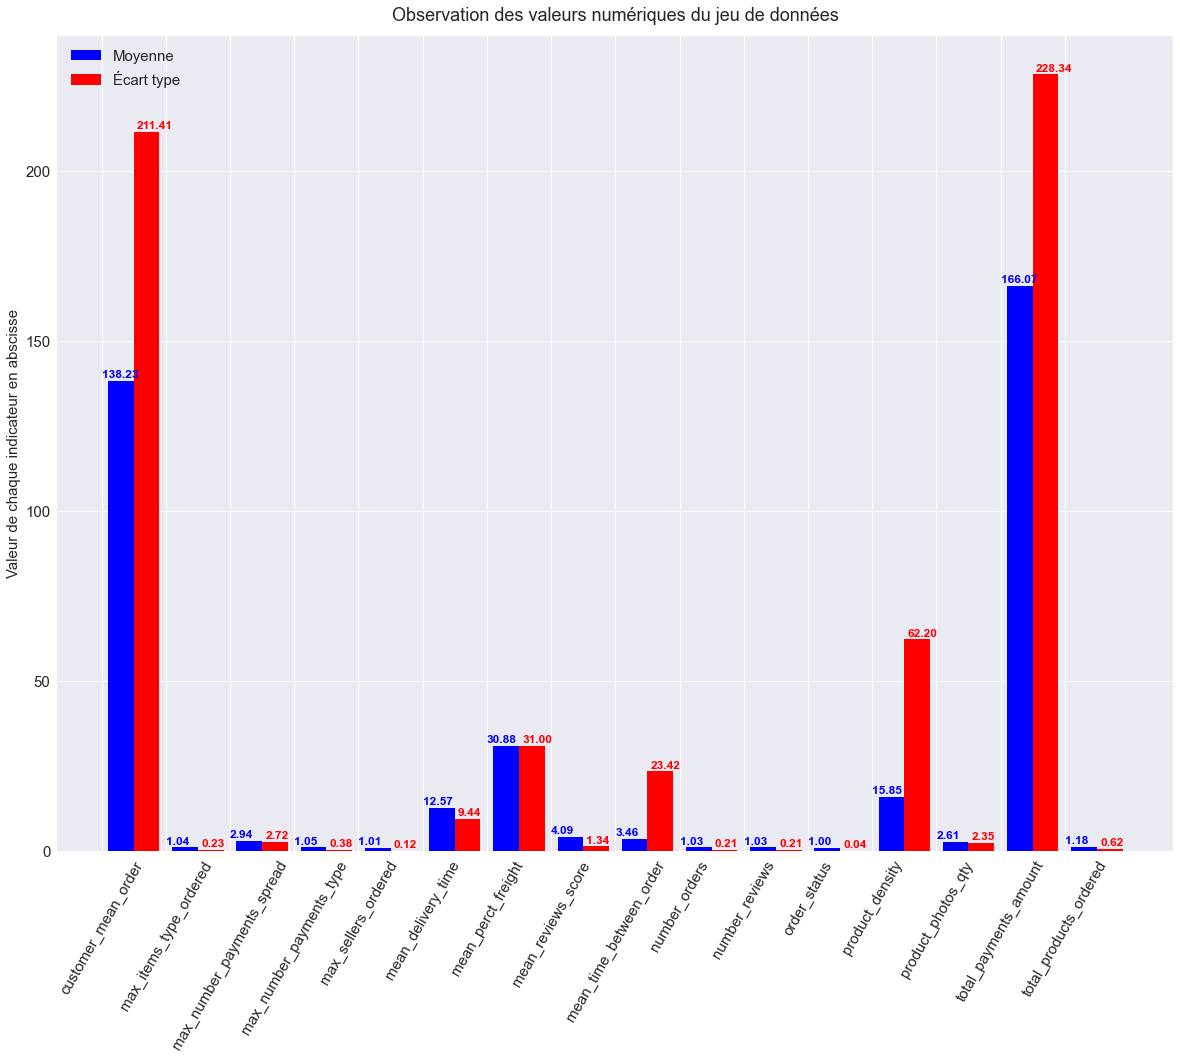

In [28]:
# Affichage des 'tendances' générales du jeu de données à disposition
mean_values = inspect_df_customer_num_values.mean()
std_values = inspect_df_customer_num_values.std()
col_names = inspect_df_customer_num_values.columns
idx_pos = np.arange(inspect_df_customer_num_values.shape[1])

plt.figure(figsize=(20, 15))

plt.bar(idx_pos-0.2, mean_values, color='b', label='Moyenne', width=0.4)
plt.bar(idx_pos+0.2, std_values, color='r', label='Écart type', width=0.4)

plt.xticks(idx_pos-0.5, col_names, rotation=60, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Observation des valeurs numériques du jeu de données", fontsize=18, pad=15)
plt.ylabel("Valeur de chaque indicateur en abscisse", fontsize=15)
plt.legend(prop={'size': 15})
for i, v in enumerate(mean_values):
    plt.text(i-0.5, v+1, "{:.2f}".format(v), color='b', fontweight='bold', fontsize=12)
for i, v in enumerate(std_values):
    plt.text(i+0.05, v+1, "{:.2f}".format(v), color='r', fontweight='bold', fontsize=12)
    
plt.show()

In [29]:
print("Nombre de colonnes numériques :", len(inspect_df_customer_num_values.columns))

Nombre de colonnes numériques : 16


In [30]:
print(inspect_df_customer_num_values.columns.values)

['customer_mean_order' 'max_items_type_ordered'
 'max_number_payments_spread' 'max_number_payments_type'
 'max_sellers_ordered' 'mean_delivery_time' 'mean_perct_freight'
 'mean_reviews_score' 'mean_time_between_order' 'number_orders'
 'number_reviews' 'order_status' 'product_density' 'product_photos_qty'
 'total_payments_amount' 'total_products_ordered']


In [31]:
# On regarde la forme des distributions avec un pairplot seaborn
# On s'attend à obtenir des distributions très asymétriques pour certaines variables (comme vu sur les graphs précédents)
# Remarque : la moyenne des commentaires par nombre de commandes auraient pu être ajoutée. (si toujours 1 commande = 1 commentaire)
def display_pairplot(dataframe_to_inspect):
    """
    Fonction qui permet d'afficher un pairplot seaborn pour observer la distribution des variables.
    
    Args:
        dataframe_to_inspect (DataFrame) : DataFrame à inspecter
        
    Returns:
        plt.show() (graphique) : Affichage des distributions avec l'option Kernel Density Estimation(KDE)
    """
    slice_idx = (len(dataframe_to_inspect.columns) // 2)
    
    g1 = sns.pairplot(inspect_df_customer_num_values.iloc[:, :slice_idx], diag_kind='kde')
    g2 = sns.pairplot(inspect_df_customer_num_values.iloc[:, slice_idx:], diag_kind='kde')
    
    return plt.show()

#display_pairplot(inspect_df_customer_num_values)

####  Pour utiliser K-means correctement, il faut :
- 1) que je normalise mes données (mean 0 et std 1)
- 2) pas de distributions asymétriques (doivent être centrées)

In [32]:
# Transformation par la racine carré pas satisfaisante
#inspect_df_customer_num_values_sqrt = np.sqrt(inspect_df_customer_num_values)
#display_pairplot(inspect_df_customer_num_values_sqrt)

In [33]:
# La transformation par le log ne marchera pas car j'ai volotairement des valeurs à zéro (corrigé -> méthode coxbox)
# utilisation de la méthode boxcox de scipy avec adaptation du dataframe chargé
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

In [34]:
# Ajout d'une constante à 'mean_time_between_order' f(x) = x+1 -> 
# pour pouvoir centrer toutes les distributions en une fois
inspect_df_customer_num_values.agg(['min', 'max'])

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
min                 0.85                     1.0                         1.0   
max             13440.00                     8.0                        24.0   

     max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
min                       1.0                  1.0            0.533414   
max                      29.0                  5.0          209.628611   

     mean_perct_freight  mean_reviews_score  mean_time_between_order  \
min            0.425261                 1.0                 1.000000   
max         2144.705882                 5.0               609.978912   

     number_orders  number_reviews  order_status  product_density  \
min              1               1             1         0.011733   
max             16              16             2     13618.860000   

     product_photos_qty  total_payments_amount  total_products_ordered  
min                 1.0                   9.59                     1.0  
max                96.0               13664.08                    24.0

In [35]:
def boxcox_transform(value):
    """
    Fonction qui permet d'appliquer la transformation à l'ensemble des colonnes du DataFrame passé en argument.
    
    Args:
        value (float) : Valeurs de colonne.
    
    Returns:
        arr_boxcox (ndarray) : array transformé grâce à la fonction passée en apply sur le DataFrame.
    """
    arr_boxcox, _ = boxcox(value) # ignore maxlog (deuxième valeur)
    return arr_boxcox

boxcox_customer_num_values = inspect_df_customer_num_values.apply(boxcox_transform, axis=0)

In [36]:
boxcox_customer_num_values.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             4.008495                     0.0                    1.179821   
1             2.610007                     0.0                    0.000000   
2             3.573776                     0.0                    1.179821   
3             2.856721                     0.0                    0.936501   
4             4.223922                     0.0                    1.091097   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                       0.0                  0.0            2.037362   
1                       0.0                  0.0            1.261419   
2                       0.0                  0.0            3.822019   
3                       0.0                  0.0            3.482646   
4                       0.0                  0.0            2.928783   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0            2.336976           23.516280                      0.0   
1            4.117653           13.126893                      0.0   
2            3.458733            6.090320                      0.0   
3            4.638556           13.126893                      0.0   
4            2.354230           23.516280                      0.0   

   number_orders  number_reviews  order_status  product_density  \
0            0.0             0.0           0.0         1.649019   
1            0.0             0.0           0.0         2.682805   
2            0.0             0.0           0.0         3.478584   
3            0.0             0.0           0.0         1.975792   
4            0.0             0.0           0.0        -2.385450   

   product_photos_qty  total_payments_amount  total_products_ordered  
0            0.000000               3.125934                     0.0  
1            0.000000               2.407346                     0.0  
2            0.837071               2.933998                     0.0  
3            1.090572               2.638038                     0.0  
4            0.837071               3.241949                     0.0

In [37]:
#display_pairplot(boxcox_customer_num_values)

In [38]:
k_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
k_scaler.fit(boxcox_customer_num_values)
boxcox_customer_num_values_std = k_scaler.transform(boxcox_customer_num_values)

# On recréé le DataFrame à l'issue de la transformation à partir du ndarray
df_customer_num_val_w_bc_std = pd.DataFrame(
    data = boxcox_customer_num_values_std,
    index = boxcox_customer_num_values.index,
    columns = boxcox_customer_num_values.columns
)

# On affiche les valeurs de moyenne et d'écart type pour vérification
# D'après la documentation les valeurs très légèrement négatives sont normales (-0.0)
df_customer_num_val_w_bc_std.agg(['mean', 'std']).round(2)

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
mean                  0.0                     0.0                        -0.0   
std                   1.0                     1.0                         1.0   

      max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
mean                       0.0                 -0.0                -0.0   
std                        1.0                  1.0                 1.0   

      mean_perct_freight  mean_reviews_score  mean_time_between_order  \
mean                 0.0                 0.0                     -0.0   
std                  1.0                 1.0                      1.0   

      number_orders  number_reviews  order_status  product_density  \
mean            0.0             0.0           0.0             -0.0   
std             1.0             1.0           1.0              1.0   

      product_photos_qty  total_payments_amount  total_products_ordered  
mean                 0.0                    0.0                     0.0  
std                  1.0                    1.0                     1.0

In [39]:
inspect_df_customer_num_values.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0               129.90                     1.0                         8.0   
1                18.90                     1.0                         1.0   
2                69.00                     1.0                         8.0   
3                25.99                     1.0                         4.0   
4               180.00                     1.0                         6.0   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                       1.0                  1.0            6.411227   
1                       1.0                  1.0            3.285590   
2                       1.0                  1.0           25.731759   
3                       1.0                  1.0           20.037083   
4                       1.0                  1.0           13.141134   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0            9.237875                 5.0                      1.0   
1           43.862434                 4.0                      1.0   
2           24.956522                 3.0                      1.0   
3           67.833782                 4.0                      1.0   
4            9.383333                 5.0                      1.0   

   number_orders  number_reviews  order_status  product_density  \
0              1               1             1         5.077333   
1              1               1             1        13.728000   
2              1               1             1        29.166667   
3              1               1             1         6.966667   
4              1               1             1         0.087273   

   product_photos_qty  total_payments_amount  total_products_ordered  
0                 1.0                 141.90                     1.0  
1                 1.0                  27.19                     1.0  
2                 3.0                  86.22                     1.0  
3                 5.0                  43.62                     1.0  
4                 3.0                 196.89                     1.0

In [40]:
# On définit le meilleur nombre de clusters en fonction de l'inertie (inertia = SSE)
# Méthode : Elbow criterion chart (= la méthode du coude déterminée graphiquement)
# On utilise les données  optimisées (transformées) : df_customer_num_val_w_bc_std (boxcox + StandardScaler)
# update -> passage en fonction pour ré-utilisation

def cal_metrics_w_clusters_nbr(dataframe_of_interest, k_range):
    """
    Fonction qui permet de calculer les trois différentes métriques en fonction de l'évolution du nombre de clusters.
    
    Args:
        dataframe_of_interest (DataFrame): Dataframe avec les valeurs numériques centrées et normalisées.
        k_range (array): Plage du nombre de clusters à tester.
        
    Returns:
        inertia_values (array): Valeurs d'inertie des clusters.
        silhouette_avg_values (array): Valeurs du coefficient de silhouette moyen sur l'ensemble.
        davies_bouldin_values (array): Valeur de l'index de Davies-Bouldin.
    """
    
    inertia_values = []
    silhouette_avg_values = []
    davies_bouldin_values = []

    for k in k_range:
        model = KMeans(init='k-means++', n_clusters=k, random_state=42)
        km_labels = model.fit_predict(dataframe_of_interest)

        # densité des clusters
        inertia = model.inertia_
        inertia_values.append(inertia)
        #print("inertia_values : ", inertia_values)

        # silhouette_score -> moyenne pour l'ensemble (donne une idée de la densité/niveau de séparation des clusters)
        silhouette_avg = silhouette_score(dataframe_of_interest, km_labels)
        silhouette_avg_values.append(silhouette_avg)
        #print("silhouette_avg_values : ", silhouette_avg_values)

        # Index Davies-Bouldin -> doit être le plus proche de zéro pour une bonne séparation inter-clusters
        davies_bouldin_index = davies_bouldin_score(dataframe_of_interest, km_labels)
        davies_bouldin_values.append(davies_bouldin_index)
        #print("davies_bouldin_values : ", davies_bouldin_values)
        
    return inertia_values, silhouette_avg_values, davies_bouldin_values
    

In [41]:
%%time
%%script false
# On récupère les données des métriques en fonctions de l'évolution du nombre de clusters impliqués
inertia_silhouette_idx_db = cal_metrics_w_clusters_nbr(df_customer_num_val_w_bc_std, k_range=range(2, 13))

#print("inertia_values : \n",  inertia_silhouette_idx_db[0], "\n")
#print("silhouette_avg_values : \n", inertia_silhouette_idx_db[1], "\n")
#print("davies_bouldin_values : \n", inertia_silhouette_idx_db[2], "\n")

Couldn't find program: 'false'
Wall time: 11.5 ms


In [42]:
%%script false
# On sauvegarde les résultats pour éviter de refaire les calculs qui sont identiques avec le random_state fixé
pickle.dump(inertia_silhouette_idx_db, open("inertia_silhouette_idx_db_1.pkl", "wb"))

Couldn't find program: 'false'


In [43]:
#  On recharge les résultats à partir du fichier pickle
inertia_silhouette_idx_db_1 = pickle.load(open("inertia_silhouette_idx_db_1.pkl", "rb"))

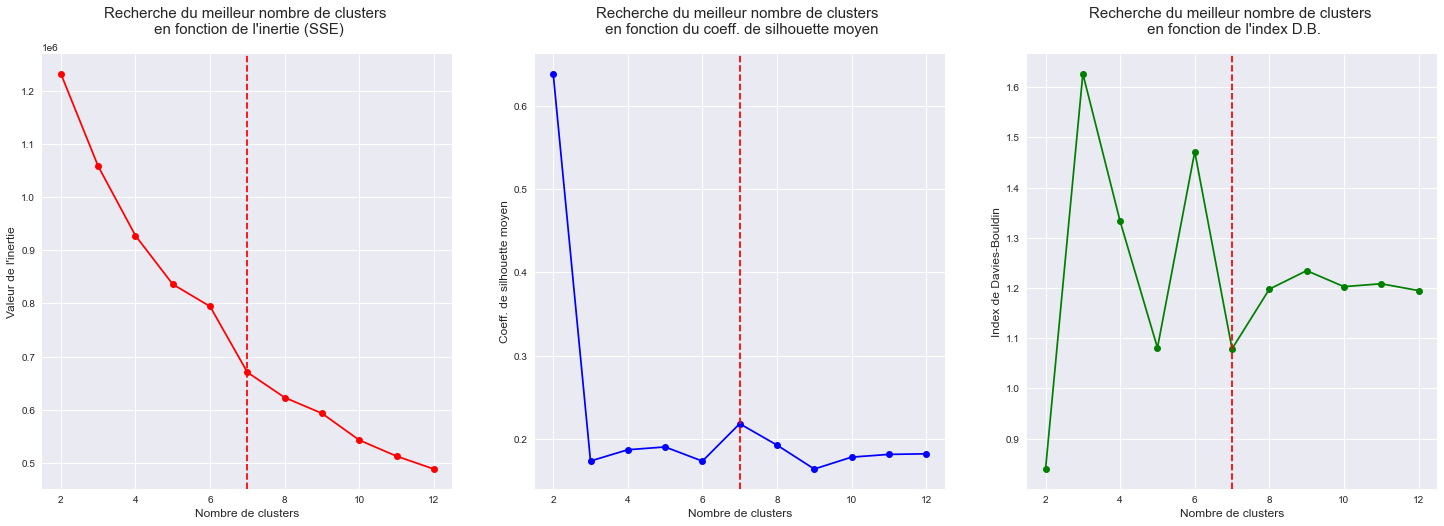

In [44]:
def find_best_clusters_nbr(clusters_metrics, k_range, x_lines=[7, 7, 7]):
    """
    Fonction qui permet de déterminer graphiquement à partir des métriques le meilleur nombre de clusters.
    
    Args:
        inertia_silhouette_idx_db (tuple): les trois métriques d'intérêt (inertie, silhouette, index Davies-Bouldin)
        k_range (int): Plage de du nombre de clusters testés.
        x_lines (int): Valeurs de x pour lesquelles on peut mettre certaines valeurs en évidence.
        
    Returns:
        plt.show (graphics): Trois graphiques permettant d'effectuer un choix sur la meilleure clusterisation possible.
    """
    
    inertia_values, silhouette_avg_values, davies_bouldin_values = clusters_metrics
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 8)
    
    ax1.plot(k_range, inertia_values, '-o', color='r', label='Inertie')
    ax1.axvline(x=x_lines[0], color="red", linestyle="--")
    ax1.set_xlabel("Nombre de clusters", fontsize=12)
    ax1.set_ylabel("Valeur de l'inertie", fontsize=12)
    ax1.set_title("Recherche du meilleur nombre de clusters \n en fonction de l'inertie (SSE)", fontsize=15, pad=20)

    ax2.plot(k_range, silhouette_avg_values, '-o', color='b', label='Coeff. silhouette')
    ax2.axvline(x=x_lines[1], color="red", linestyle="--")
    ax2.set_xlabel("Nombre de clusters", fontsize=12)
    ax2.set_ylabel("Coeff. de silhouette moyen", fontsize=12)
    ax2.set_title("Recherche du meilleur nombre de clusters \n en fonction du coeff. de silhouette moyen", fontsize=15, pad=20)

    ax3.plot(k_range, davies_bouldin_values, '-o', color='g', label='Index Davies-Bouldin')
    ax3.axvline(x=x_lines[2], color="red", linestyle="--")
    ax3.set_xlabel("Nombre de clusters", fontsize=12)
    ax3.set_ylabel("Index de Davies-Bouldin", fontsize=12)
    ax3.set_title("Recherche du meilleur nombre de clusters \n en fonction de l'index D.B.", fontsize=15, pad=20)
    
    return plt.show()

find_best_clusters_nbr(inertia_silhouette_idx_db_1, k_range=range(2, 13), x_lines=[7, 7, 7])

- D'après les résultats obtenus à partir des trois graphiques une segmentation à 7 clusters semblent être le meilleur compromis.

#### Coefficient de silhouette (="qualité des clusters") et Davies-Bouldin index (="séparation des clusters"))
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html <br />
https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index

silhouette_avg : 0.21865898721018584
Davies-Bouldin index :  1.078879130607698
KMeans labels :  [1 3 2 5 4 0 6]
Taille du cluster numéro 0 : 2759 clients 

Taille du cluster numéro 1 : 42149 clients 

Taille du cluster numéro 2 : 7524 clients 

Taille du cluster numéro 3 : 38950 clients 

Taille du cluster numéro 4 : 1172 clients 

Taille du cluster numéro 5 : 2747 clients 

Taille du cluster numéro 6 : 119 clients 



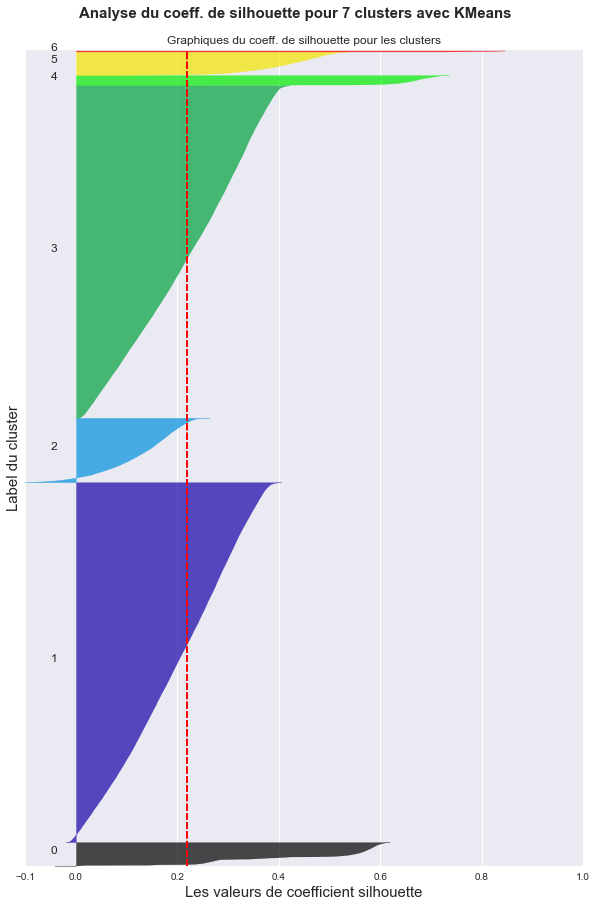

Wall time: 7min 12s


In [45]:
%%time
def display_results_w_optimal_clusters_nbr(dataframe_of_interest, n_clusters):
    """
    Fonction qui permet d'assigner les labels clusters à deux dataframes.
    
    Args:
        dataframe_of_interest (DataFrame): Dataframe prêt pour la clusterisation.
        n_clusters (int): Nombre de clusters. (déterminé à partir des métriques)
        
    Returns:
        inspect_df_customer_num_values_k_labels, df_customers_num_values_km2 (DataFrame):
        DataFrames, l'un avec les valeurs d'origine et l'autre avec les valeurs normalisées.
    """
    
    nbr_clusters = n_clusters
    km_model = KMeans(init = 'k-means++', n_clusters = nbr_clusters, random_state = 42)
    km_labels = km_model.fit_predict(dataframe_of_interest) # ou simplement fit() -> km_model.labels_

    # silhouette_score -> moyenne pour l'ensemble (donne une idée de la densité/niveau de séparation des clusters)
    silhouette_avg = silhouette_score(dataframe_of_interest, km_labels)
    print("silhouette_avg :", silhouette_avg)

    # silhouette_samples -> donne la mesure pour chaque clusters (plus c'est proche de 1 mieux c'est.)
    sample_silhouette_values = silhouette_samples(dataframe_of_interest, km_labels)
    #print("sample_silhouette_values : \n", *sample_silhouette_values, sep = "\n")

    # Index Davies-Bouldin -> doit être le plus proche de zéro pour une bonne séparation inter-clusters
    davies_bouldin_index = davies_bouldin_score(dataframe_of_interest, km_labels)
    print("Davies-Bouldin index : ", davies_bouldin_index)
    
    # Modifications suite au passage en fonction
    inspect_df_customer_num_values_k_labels = df_customers.assign(k_label = km_labels)
    print("KMeans labels : " ,inspect_df_customer_num_values_k_labels['k_label'].unique())
    df_customers_num_values_km2 = dataframe_of_interest.assign(k_label = km_labels)
    

    # Création d'un seul subplot avec une ligne et une colonne
    fig, ax = plt.subplots(1, 1)
    # On définit la taille du graphique en pouces (équivalent figsize)
    fig.set_size_inches(10, 15)

    # coefficient de silhouette peut aller de -1 à 1 (à revoir s'il y a des valeurs très basses..)
    ax.set_xlim([-0.1, 1])
    # Espace de démarcation entre les graphiques pour éviter le chevauchement
    ax.set_ylim([0, len(dataframe_of_interest) + (nbr_clusters + 1) * 10])

    # coeffs silhouette 
    y_lower = 10 # positionnement initial -> sera redéfinit ensuite en fonction du nombre de clusters
    for idx_k in range(nbr_clusters):

        # Récupère les "samples" appartenant à chaque clusters
        ith_cluster_silhouette_values = sample_silhouette_values[km_labels == idx_k]
        ith_cluster_silhouette_values.sort()

        # Taille du cluster
        cluster_size = ith_cluster_silhouette_values.shape[0]

        # positionnement en fonction de la taille
        y_upper = y_lower + cluster_size

        # Coloration pour les points des clusters
        color = cm.nipy_spectral(float(idx_k) / nbr_clusters)

        # Trace le graphique des valeurs de coefficient silhouette pour le cluster en question
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        # Ajoute le label du cluster en ordonnée
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(idx_k), fontsize=12)

        # Redéfinit la position pour le graphique du cluster suivant
        y_lower = y_upper + 10 # 10 for the 0 samples -> merci la doc scikit-learn !

        # Ajout des titres et labels
        ax.set_title("Graphiques du coeff. de silhouette pour les clusters", fontsize=12)
        ax.set_xlabel("Les valeurs de coefficient silhouette", fontsize=15)
        ax.set_ylabel("Label du cluster", fontsize=15)

        # On trace la moyenne du coefficient silhouette obtenu sur l'ensemble des clusters
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        # labels des axes
        ax.set_yticks([])  # Rien car seul le label des clusters nous intéresse
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.tick_params(axis='both', labelsize=10)

        plt.suptitle("Analyse du coeff. de silhouette pour {} clusters avec KMeans".format(nbr_clusters),
                     fontsize=15, fontweight='bold', y=0.92)

        print("Taille du cluster numéro {} : {} clients".format(
            idx_k, sample_silhouette_values[km_labels == idx_k].shape[0]
        ), "\n")
        
    plt.show()
        
    return inspect_df_customer_num_values_k_labels, df_customers_num_values_km2

# On affiche l'ensemble des résultats pour vérification avant exploitation des segments (clusters clients)
# On récupère 'inspect_df_customer_num_values_k_labels' (df_customers) -> contient les données d'origine clients
retrieve_dfs = display_results_w_optimal_clusters_nbr(df_customer_num_val_w_bc_std, n_clusters=7)
df_customers_k_labels = retrieve_dfs[0]
df_customers_k_labels_num_std = retrieve_dfs[1]

In [46]:
display("df_customers_k_labels : ", df_customers_k_labels.head())
display("df_customers_k_labels_num_std : ", df_customers_k_labels_num_std.head())

'df_customers_k_labels : '

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

'df_customers_k_labels_num_std : '

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             0.481628               -0.186459                    1.474121   
1            -1.699552               -0.186459                   -0.967751   
2            -0.196389               -0.186459                    1.474121   
3            -1.314759               -0.186459                    0.970521   
4             0.817624               -0.186459                    1.290489   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                  -0.17908            -0.116328           -0.698158   
1                  -0.17908            -0.116328           -1.623555   
2                  -0.17908            -0.116328            1.430243   
3                  -0.17908            -0.116328            1.025504   
4                  -0.17908            -0.116328            0.364961   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0           -1.078956            0.781478                -0.151289   
1            0.827045           -0.401647                -0.151289   
2            0.121750           -1.202960                -0.151289   
3            1.384609           -0.401647                -0.151289   
4           -1.060488            0.781478                -0.151289   

   number_orders  number_reviews  order_status  product_density  \
0      -0.177453       -0.177453     -0.035337        -0.677539   
1      -0.177453       -0.177453     -0.035337         0.369419   
2      -0.177453       -0.177453     -0.035337         1.175338   
3      -0.177453       -0.177453     -0.035337        -0.346603   
4      -0.177453       -0.177453     -0.035337        -4.763415   

   product_photos_qty  total_payments_amount  total_products_ordered  k_label  
0           -1.078191               0.369200               -0.376904        1  
1           -1.078191              -1.965208               -0.376904        3  
2            0.738093              -0.254325               -0.376904        1  
3            1.288142              -1.215781               -0.376904        3  
4            0.738093               0.746084               -0.376904        1

#### Caractérisation des clients par les différents types de clusters obtenus

In [47]:
display(df_customers_k_labels.head())

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [48]:
cols_list = ['customer_mean_order', 'max_items_type_ordered',
             'max_number_payments_spread', 'max_number_payments_type',
             'max_sellers_ordered', 'mean_delivery_time', 'mean_perct_freight',
             'mean_reviews_score', 'mean_time_between_order', 'number_orders',
             'number_reviews', 'order_status', 'product_density', 'product_photos_qty',
             'total_payments_amount', 'total_products_ordered', 'k_label']

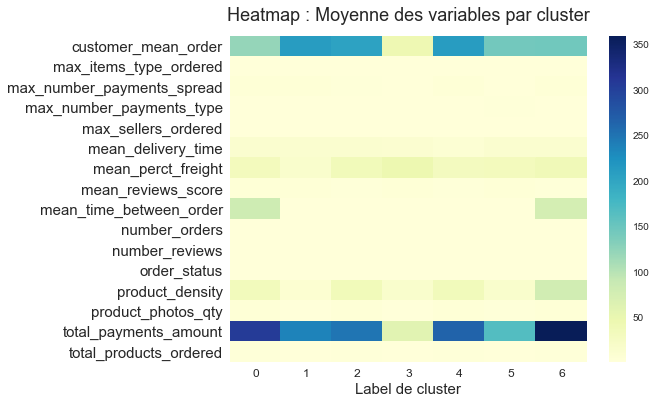

customer_mean_order  max_items_type_ordered  \
k_label                                                
0                   122.4629                  1.1254   
1                   212.0981                  1.0000   
2                   204.8374                  1.2569   
3                    43.8625                  1.0000   
4                   212.1881                  2.1749   
5                   144.2252                  1.0226   
6                   146.1403                  1.0756   

         max_number_payments_spread  max_number_payments_type  \
k_label                                                         
0                            4.0507                    1.0942   
1                            3.9339                    1.0000   
2                            3.3684                    1.0000   
3                            1.7114                    1.0000   
4                            4.3720                    1.0657   
5                            2.2093                    2.4681   
6                            4.4706                    1.0840   

         max_sellers_ordered  mean_delivery_time  mean_perct_freight  \
k_label                                                                
0                     1.0388             12.3637             32.1479   
1                     1.0000             13.3381             15.3527   
2                     1.0000             12.2797             36.2811   
3                     1.0000             11.8659             46.3907   
4                     2.0520              9.2865             30.4413   
5                     1.0000             13.0805             32.8198   
6                     1.0000             13.0453             38.4928   

         mean_reviews_score  mean_time_between_order  number_orders  \
k_label                                                               
0                    4.1989                  82.8473         2.1098   
1                    4.1069                   1.0000         1.0000   
2                    3.6623                   1.0000         1.0000   
3                    4.1834                   1.0000         1.0000   
4                    2.7993                   1.0001         1.0316   
5                    4.0743                   1.0000         1.0000   
6                    2.9468                  75.2786         2.2353   

         number_reviews  order_status  product_density  product_photos_qty  \
k_label                                                                      
0                2.1098           1.0          34.1803              5.1761   
1                1.0000           1.0          10.4143              2.2990   
2                1.0000           1.0          36.7001              4.7024   
3                1.0000           1.0          15.6940              2.2926   
4                1.0316           1.0          35.0010              4.7517   
5                1.0000           1.0          15.0630              2.4458   
6                2.2353           2.0          78.9727              5.1345   

         total_payments_amount  total_products_ordered  
k_label                                                 
0                     307.1422                  2.5509  
1                     236.4377                  1.0003  
2                     249.7751                  2.4260  
3                      60.0950                  1.0018  
4                     265.1694                  2.4394  
5                     167.4220                  1.0961  
6                     359.1151                  2.5546

In [49]:
# Adaptation suite à la création des fonctions
customers_clusters_avg = df_customers_k_labels[cols_list].groupby('k_label').mean().round(4)

# Affichage pour tenter une interprétation du type de clients par clusters
plt.figure(figsize=(8, 6))
ax = sns.heatmap(customers_clusters_avg.T, cmap='YlGnBu')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Heatmap : Moyenne des variables par cluster", fontsize=18, pad=15)
plt.xlabel("Label de cluster", fontsize=15)
plt.show()

display(customers_clusters_avg)

- Commentaires : Bien que le nombre de clusters semble satisfaisant au regard des métriques.<br />
L'interprétation de la heatmap laisse penser que l'on doit pouvoir regrouper des clusters ensemble ou au contraire fortement augmenter le nombre de clusters à impliquer (supérieur ou égal à 12 par exemple).

### NMF première approche complémentaire à KMeans
But : réduction de dimensions et interprétation de patterns<br />
Approche utilisée sur les variables catégorielles numérisées exclusivement.

In [50]:
#df_customers_nmf = df_customers.select_dtypes(include = ['float64', 'int64'])
# On enlève la geolocalisation également (pas de valeurs négatives pour la NMF)
#df_customers_nmf = df_customers_nmf[df_customers_nmf.columns.difference(['centroid_lat', 'centroid_lng'])]

payments_cat = [cat for cat in df_customers.columns if cat.startswith('payment_')]
products_cat = [cat for cat in df_customers.columns if cat.startswith('cat_')]
cat_columns = payments_cat + products_cat
df_customers_nmf = df_customers[cat_columns].copy()
df_customers_nmf.head()

payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0   
2                  0.0                       1.0                      0.0   
3                  0.0                       1.0                      0.0   
4                  0.0                       1.0                      0.0   

   payment_type_voucher  cat_auto  cat_books  cat_childhood  \
0                   0.0       0.0        0.0            0.0   
1                   0.0       0.0        0.0            0.0   
2                   0.0       0.0        0.0            0.0   
3                   0.0       0.0        0.0            0.0   
4                   0.0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  
0            0.0          0.0                          0.0  
1            0.0          0.0                          0.0  
2            0.0          0.0                          0.0  
3            1.0          0.0                          0.0  
4            1.0          0.0                          0.0

In [51]:
# Je prends autant de composantes que de clusters
nmf_model = NMF(n_components = 7, init='nndsvd') # initialization (better for sparseness)
nmf_model.fit(df_customers_nmf)

# On récupère les composantes sous forme d'un DataFrame avec le nom des colonnes correspondantes
df_nmf_components = pd.DataFrame(data=nmf_model.components_, columns=df_customers_nmf.columns)
display(df_nmf_components)

payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0             0.000000                 18.326631                 0.000000   
1             0.098328                  1.098792                 0.148193   
2             0.089247                  0.825233                 0.109316   
3            13.129659                  0.000000                 0.000000   
4             0.000000                  0.000000                 0.000000   
5             0.096391                  1.036865                 0.149773   
6             0.111343                  0.387322                 0.116297   

   payment_type_voucher  cat_auto  cat_books  cat_childhood  \
0              0.000000  0.829902   0.154016       1.520605   
1              0.000434  0.000000   0.000000       0.000000   
2              0.000000  0.000000   0.000000       0.000000   
3              0.000000  0.551367   0.125453       0.964758   
4             11.803105  0.031260   0.000000       0.122225   
5              0.000566  0.000000   0.000000       0.000000   
6              0.000091  0.000000   0.000000       0.000000   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                1.352511                         0.784880  0.228385   
1                0.000000                         0.000000  0.000000   
2                0.000000                         0.000000  0.000000   
3                1.577013                         0.465693  0.154351   
4                0.158795                         0.156042  0.000000   
5                0.000000                         0.000000  0.000000   
6                0.000000                         0.000000  0.000000   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                  2.277729                   0.000000       0.000000   
1                  0.000000                   0.000000       0.000000   
2                  0.000000                   0.000000       0.000000   
3                  1.927708                   0.012767       0.000943   
4                  0.084183                   0.000000       0.000000   
5                  0.000000                  11.828217       0.000000   
6                  0.000000                   0.000000       9.185207   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                    0.000000                   0.000000          0.111838   
1                   14.592258                   0.000000          0.000000   
2                    0.000000                  14.220784          0.000000   
3                    0.017900                   0.006676          0.114415   
4                    0.000000                   0.000000          0.022574   
5                    0.000000                   0.000000          0.000000   
6                    0.000000                   0.000000          0.000000   

   cat_telephony  cat_unknown  cat_video_audio_instruments  
0       0.928436     0.309800                     0.418983  
1       0.000000     0.000000                     0.000000  
2       0.000000     0.000000                     0.000000  
3       0.778380     0.191327                     0.302008  
4       0.039361     0.050091                     0.046308  
5       0.000000     0.000000                     0.000000  
6       0.000000     0.000000                     0.000000

#### NMF : Observation des spécificités des catégories produits achetées par les clients (confirmation de l'EDA ?)

In [52]:
df_nmf_features = pd.DataFrame(data=nmf_model.transform(df_customers_nmf), columns=df_nmf_components.index)
display(df_nmf_features.head())
# On conserve le même index que le DataFrame d'origine
df_nmf_features.index = df_customers_nmf.index

0         1         2         3    4         5         6
0  0.048708  0.068682  0.000120  0.000000  0.0  0.000218  0.000122
1  0.048057  0.000148  0.000116  0.000000  0.0  0.084755  0.000114
2  0.049617  0.000157  0.070444  0.000000  0.0  0.000225  0.000128
3  0.055338  0.000000  0.000000  0.001309  0.0  0.000000  0.000000
4  0.055338  0.000000  0.000000  0.001309  0.0  0.000000  0.000000

In [53]:
# On affecte à une nouvelle colonne du DataFrame 'df_customers_nmf',
# la valeur la plus importante de chaque ligne pour chaque clients
customers_mnf_w_rang = df_customers_nmf.assign(rang = df_nmf_features.idxmax(axis=1))
print(customers_mnf_w_rang.shape)
display(customers_mnf_w_rang.head())

(95420, 20)


payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0   
2                  0.0                       1.0                      0.0   
3                  0.0                       1.0                      0.0   
4                  0.0                       1.0                      0.0   

   payment_type_voucher  cat_auto  cat_books  cat_childhood  \
0                   0.0       0.0        0.0            0.0   
1                   0.0       0.0        0.0            0.0   
2                   0.0       0.0        0.0            0.0   
3                   0.0       0.0        0.0            0.0   
4                   0.0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  rang  
0            0.0          0.0                          0.0     1  
1            0.0          0.0                          0.0     5  
2            0.0          0.0                          0.0     2  
3            1.0          0.0                          0.0     0  
4            1.0          0.0                          0.0     0

In [54]:
# Ce qui permet ensuite d'obtenir la moyenne sur l'ensemble par rang à partir des features NMF clients
customers_mnf_avg = customers_mnf_w_rang.groupby('rang').mean().round(4) # précision importante ici
display(customers_mnf_avg.head(7))

payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
rang                                                                           
0                  0.0002                    1.0444                   0.0002   
1                  0.0294                    0.9840                   0.0198   
2                  0.0515                    0.9602                   0.0173   
3                  0.9921                    0.0066                   0.0339   
4                  0.0058                    0.5821                   0.0000   
5                  0.1952                    0.8100                   0.0168   
6                  0.2547                    0.7199                   0.0536   

      payment_type_voucher  cat_auto  cat_books  cat_childhood  \
rang                                                             
0                   0.0015    0.0873     0.0175         0.1511   
1                   0.0045    0.0005     0.0001         0.0025   
2                   0.0077    0.0006     0.0001         0.0026   
3                   0.0005    0.0618     0.0145         0.0935   
4                   1.6244    0.0462     0.0064         0.0866   
5                   0.0160    0.0001     0.0002         0.0005   
6                   0.0285    0.0011     0.0015         0.0010   

      cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
rang                                                                      
0                     0.1313                           0.0753    0.0231   
1                     0.0028                           0.0005    0.0003   
2                     0.0082                           0.0007    0.0002   
3                     0.1103                           0.0508    0.0170   
4                     0.0677                           0.0741    0.0099   
5                     0.0003                           0.0004    0.0011   
6                     0.0030                           0.0016    0.0042   

      cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
rang                                                                       
0                       0.2170                     0.0052         0.0004   
1                       0.0008                     0.0003         0.0007   
2                       0.0035                     0.0012         0.0005   
3                       0.1343                     0.0028         0.0012   
4                       0.1158                     0.0712         0.0173   
5                       0.0009                     1.1165         0.0004   
6                       0.0014                     0.0015         1.1498   

      cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
rang                                                                            
0                         0.0105                     0.0073            0.0128   
1                         1.2445                     0.0029            0.0002   
2                         0.0167                     1.3445            0.0007   
3                         0.2006                     0.1253            0.0122   
4                         0.2575                     0.1238            0.0048   
5                         0.0026                     0.0014            0.0000   
6                         0.0051                     0.0034            0.0018   

      cat_telephony  cat_unknown  cat_video_audio_instruments  
rang                                                           
0            0.0951       0.0317                       0.0452  
1            0.0001       0.0018                       0.0003  
2            0.0000       0.0010                       0.0001  
3            0.0793       0.0208                       0.0367  
4            0.0558       0.0228                       0.0330  
5            0.0003       0.0007                       0.0003  
6            0.0027       0.0049                       0.0010

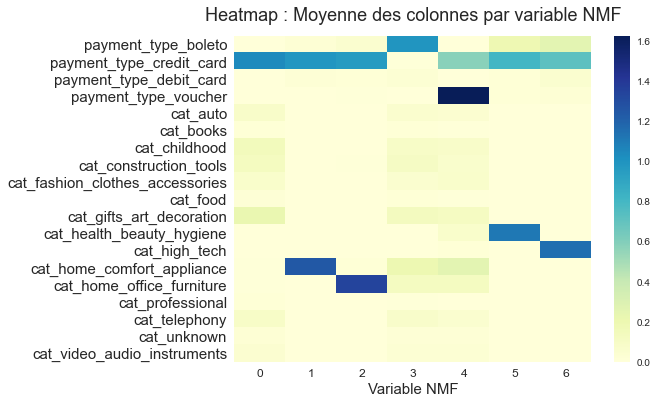

In [55]:
plt.figure(figsize=(8, 6))

ax = sns.heatmap(customers_mnf_avg.T, cmap='YlGnBu')

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Heatmap : Moyenne des colonnes par variable NMF", fontsize=18, pad=15)
plt.xlabel("Variable NMF", fontsize=15)

plt.show()

#### Merge de l'ensemble en conservant les informations de labels des clusters et des segments (rangs) de la NMF.
- customers_mnf_w_rang (catégories produits achetées propres aux clients)
- <del>inspect_df_customer_num_values_k_labels</del> -> df_customers_k_labels (features numériques transformées propres aux clients)

##### Vérification de non manipulation(s) accidentelle(s) d'index avant le merge

In [56]:
#(customers_mnf_w_rang.index == inspect_df_customer_num_values_k_labels.index).mean()
(customers_mnf_w_rang.index == df_customers_k_labels.index).mean()

1.0

In [57]:
df_w_all_num_features = df_customers_k_labels.merge(customers_mnf_w_rang, left_index=True, right_index=True)

In [58]:
df_w_all_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_unique_id                 95420 non-null  object 
 1   customer_zip_code_prefix           95420 non-null  int64  
 2   customer_city                      95420 non-null  object 
 3   customer_state                     95420 non-null  object 
 4   number_orders                      95420 non-null  int64  
 5   order_status                       95420 non-null  int64  
 6   mean_delivery_time                 95420 non-null  float64
 7   number_reviews                     95420 non-null  int64  
 8   mean_reviews_score                 95420 non-null  float64
 9   words_comments_title               11456 non-null  object 
 10  words_comments_message             40036 non-null  object 
 11  max_number_payments_type           95420 non-null  flo

In [59]:
display(df_w_all_num_features[['product_density', 'total_payments_amount']].head())
display(df_customers[['product_density', 'total_payments_amount']].head())

product_density  total_payments_amount
0         5.077333                 141.90
1        13.728000                  27.19
2        29.166667                  86.22
3         6.966667                  43.62
4         0.087273                 196.89

product_density  total_payments_amount
0         5.077333                 141.90
1        13.728000                  27.19
2        29.166667                  86.22
3         6.966667                  43.62
4         0.087273                 196.89

### KMeans : 2ème approche avec l'ensemble des données numériques optimisées

#### Centering & Scaling de toutes les données numériques

In [60]:
#inspect_df_customer_num_values_k_labels.head()
df_customers_k_labels.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [61]:
df_customers_k_labels.shape

(95420, 44)

In [62]:
customers_mnf_w_rang.head()

payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0   
2                  0.0                       1.0                      0.0   
3                  0.0                       1.0                      0.0   
4                  0.0                       1.0                      0.0   

   payment_type_voucher  cat_auto  cat_books  cat_childhood  \
0                   0.0       0.0        0.0            0.0   
1                   0.0       0.0        0.0            0.0   
2                   0.0       0.0        0.0            0.0   
3                   0.0       0.0        0.0            0.0   
4                   0.0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  rang  
0            0.0          0.0                          0.0     1  
1            0.0          0.0                          0.0     5  
2            0.0          0.0                          0.0     2  
3            1.0          0.0                          0.0     0  
4            1.0          0.0                          0.0     0

In [63]:
# Note: A été modifié suite à la création des fonctions.
cols_list = ['customer_mean_order', 'max_items_type_ordered',
             'max_number_payments_spread', 'max_number_payments_type',
             'max_sellers_ordered', 'mean_delivery_time', 'mean_perct_freight',
             'mean_reviews_score', 'mean_time_between_order', 'number_orders',
             'number_reviews', 'order_status', 'product_density', 'product_photos_qty',
             'total_payments_amount', 'total_products_ordered']

df_customers_num_km_part = df_customers_k_labels[cols_list].copy()
df_customers_num_km_part.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0               129.90                     1.0                         8.0   
1                18.90                     1.0                         1.0   
2                69.00                     1.0                         8.0   
3                25.99                     1.0                         4.0   
4               180.00                     1.0                         6.0   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                       1.0                  1.0            6.411227   
1                       1.0                  1.0            3.285590   
2                       1.0                  1.0           25.731759   
3                       1.0                  1.0           20.037083   
4                       1.0                  1.0           13.141134   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0            9.237875                 5.0                      1.0   
1           43.862434                 4.0                      1.0   
2           24.956522                 3.0                      1.0   
3           67.833782                 4.0                      1.0   
4            9.383333                 5.0                      1.0   

   number_orders  number_reviews  order_status  product_density  \
0              1               1             1         5.077333   
1              1               1             1        13.728000   
2              1               1             1        29.166667   
3              1               1             1         6.966667   
4              1               1             1         0.087273   

   product_photos_qty  total_payments_amount  total_products_ordered  
0                 1.0                 141.90                     1.0  
1                 1.0                  27.19                     1.0  
2                 3.0                  86.22                     1.0  
3                 5.0                  43.62                     1.0  
4                 3.0                 196.89                     1.0

In [64]:
df_customers_cat_num_nmf_part = \
customers_mnf_w_rang[customers_mnf_w_rang.columns.difference(['rang'])]
df_customers_cat_num_nmf_part.head()

cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0       0.0        0.0            0.0                     0.0   
1       0.0        0.0            0.0                     0.0   
2       0.0        0.0            0.0                     0.0   
3       0.0        0.0            0.0                     0.0   
4       0.0        0.0            0.0                     0.0   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                              0.0       0.0                       0.0   
1                              0.0       0.0                       0.0   
2                              0.0       0.0                       0.0   
3                              0.0       0.0                       0.0   
4                              0.0       0.0                       0.0   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                        0.0            0.0                         1.0   
1                        1.0            0.0                         0.0   
2                        0.0            0.0                         0.0   
3                        0.0            0.0                         0.0   
4                        0.0            0.0                         0.0   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                        0.0               0.0            0.0          0.0   
1                        0.0               0.0            0.0          0.0   
2                        1.0               0.0            0.0          0.0   
3                        0.0               0.0            1.0          0.0   
4                        0.0               0.0            1.0          0.0   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0                          0.0                  0.0                       1.0   
1                          0.0                  0.0                       1.0   
2                          0.0                  0.0                       1.0   
3                          0.0                  0.0                       1.0   
4                          0.0                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  
0                      0.0                   0.0  
1                      0.0                   0.0  
2                      0.0                   0.0  
3                      0.0                   0.0  
4                      0.0                   0.0

In [65]:
# On centre l'ensemble des données : df_customers_num_km_part
boxcox_customers_num_km_part = df_customers_num_km_part.apply(boxcox_transform, axis=0)
boxcox_customers_num_km_part.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             4.008495                     0.0                    1.179821   
1             2.610007                     0.0                    0.000000   
2             3.573776                     0.0                    1.179821   
3             2.856721                     0.0                    0.936501   
4             4.223922                     0.0                    1.091097   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                       0.0                  0.0            2.037362   
1                       0.0                  0.0            1.261419   
2                       0.0                  0.0            3.822019   
3                       0.0                  0.0            3.482646   
4                       0.0                  0.0            2.928783   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0            2.336976           23.516280                      0.0   
1            4.117653           13.126893                      0.0   
2            3.458733            6.090320                      0.0   
3            4.638556           13.126893                      0.0   
4            2.354230           23.516280                      0.0   

   number_orders  number_reviews  order_status  product_density  \
0            0.0             0.0           0.0         1.649019   
1            0.0             0.0           0.0         2.682805   
2            0.0             0.0           0.0         3.478584   
3            0.0             0.0           0.0         1.975792   
4            0.0             0.0           0.0        -2.385450   

   product_photos_qty  total_payments_amount  total_products_ordered  
0            0.000000               3.125934                     0.0  
1            0.000000               2.407346                     0.0  
2            0.837071               2.933998                     0.0  
3            1.090572               2.638038                     0.0  
4            0.837071               3.241949                     0.0

In [66]:
# On merge les deux DataFrames et on scale l'ensemble des données
df_2nd_kmeans_all_features = boxcox_customers_num_km_part.merge(
    df_customers_cat_num_nmf_part,
    left_index=True,
    right_index=True
)

km2_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
df_2nd_kmeans_all_features_std = km2_scaler.fit_transform(df_2nd_kmeans_all_features)

# On recréé le DataFrame à l'issue de la transformation à partir du ndarray
df_2nd_kmeans_all_features_std = pd.DataFrame(
    data = df_2nd_kmeans_all_features_std,
    index = df_2nd_kmeans_all_features.index,
    columns = df_2nd_kmeans_all_features.columns
)

df_2nd_kmeans_all_features_std.agg(['mean', 'std']).round(2)

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
mean                  0.0                     0.0                        -0.0   
std                   1.0                     1.0                         1.0   

      max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
mean                       0.0                 -0.0                -0.0   
std                        1.0                  1.0                 1.0   

      mean_perct_freight  mean_reviews_score  mean_time_between_order  \
mean                 0.0                 0.0                     -0.0   
std                  1.0                 1.0                      1.0   

      number_orders  number_reviews  order_status  product_density  \
mean            0.0             0.0           0.0             -0.0   
std             1.0             1.0           1.0              1.0   

      product_photos_qty  total_payments_amount  total_products_ordered  \
mean                 0.0                    0.0                     0.0   
std                  1.0                    1.0                     1.0   

      cat_auto  cat_books  cat_childhood  cat_construction_tools  \
mean       0.0       -0.0           -0.0                    -0.0   
std        1.0        1.0            1.0                     1.0   

      cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
mean                             -0.0      -0.0                      -0.0   
std                               1.0       1.0                       1.0   

      cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
mean                        0.0            0.0                        -0.0   
std                         1.0            1.0                         1.0   

      cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
mean                        0.0              -0.0            0.0         -0.0   
std                         1.0               1.0            1.0          1.0   

      cat_video_audio_instruments  payment_type_boleto  \
mean                         -0.0                  0.0   
std                           1.0                  1.0   

      payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
mean                       0.0                     -0.0                  -0.0  
std                        1.0                      1.0                   1.0

#### Détermination du meilleur nombre de clusters : à nouveau avec l'ensemble des données
- sélection par l'inertie (elbow method)
- sélection par le coefficient de silhouette moyen sur l'ensemble
- sélection par l'index de Davies-Bouldin

In [67]:
#df_2nd_kmeans_all_features_std.info()
df_2nd_kmeans_all_features_std.shape

(95420, 35)

In [68]:
clusters_range = range(2, 16)

In [69]:
%%time
%%script false
# On récupère les données des métriques en fonctions de l'évolution du nombre de clusters impliqués
inertia_silhouette_idx_db_2 = cal_metrics_w_clusters_nbr(df_2nd_kmeans_all_features_std, k_range=clusters_range)

Couldn't find program: 'false'
Wall time: 6.99 ms


In [70]:
%%script false
# On sauvegarde les résultats pour éviter de refaire les calculs qui sont identiques
pickle.dump(inertia_silhouette_idx_db_2, open("inertia_silhouette_idx_db_2.pkl", "wb"))

Couldn't find program: 'false'


In [71]:
# On recharge les résultats à partir du fichier pickle
inertia_silhouette_idx_db_2 = pickle.load(open("inertia_silhouette_idx_db_2.pkl", "rb"))

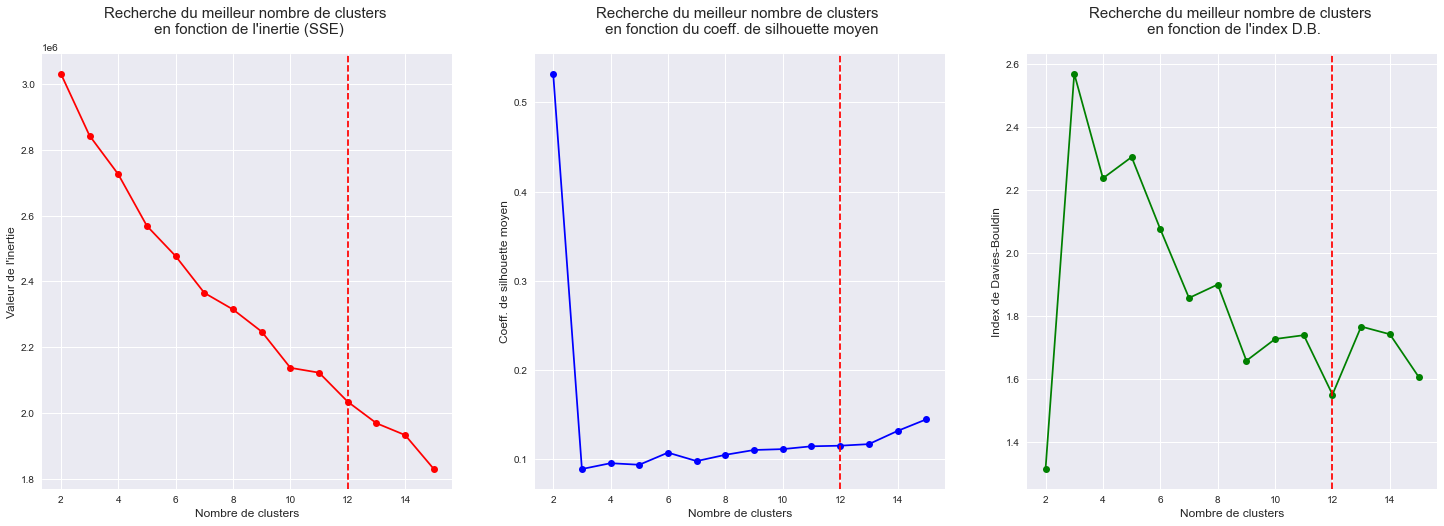

In [72]:
find_best_clusters_nbr(inertia_silhouette_idx_db_2, k_range=clusters_range, x_lines=[12, 12, 12])

silhouette_avg : 0.11518973070973632
Davies-Bouldin index :  1.5518027984009979
KMeans labels :  [ 0  3  7  1  5  9 11 10  4  6  2  8]
Taille du cluster numéro 0 : 29727 clients 

Taille du cluster numéro 1 : 7996 clients 

Taille du cluster numéro 2 : 119 clients 

Taille du cluster numéro 3 : 24397 clients 

Taille du cluster numéro 4 : 1434 clients 

Taille du cluster numéro 5 : 2677 clients 

Taille du cluster numéro 6 : 2716 clients 

Taille du cluster numéro 7 : 16638 clients 

Taille du cluster numéro 8 : 541 clients 

Taille du cluster numéro 9 : 1169 clients 

Taille du cluster numéro 10 : 6048 clients 

Taille du cluster numéro 11 : 1958 clients 



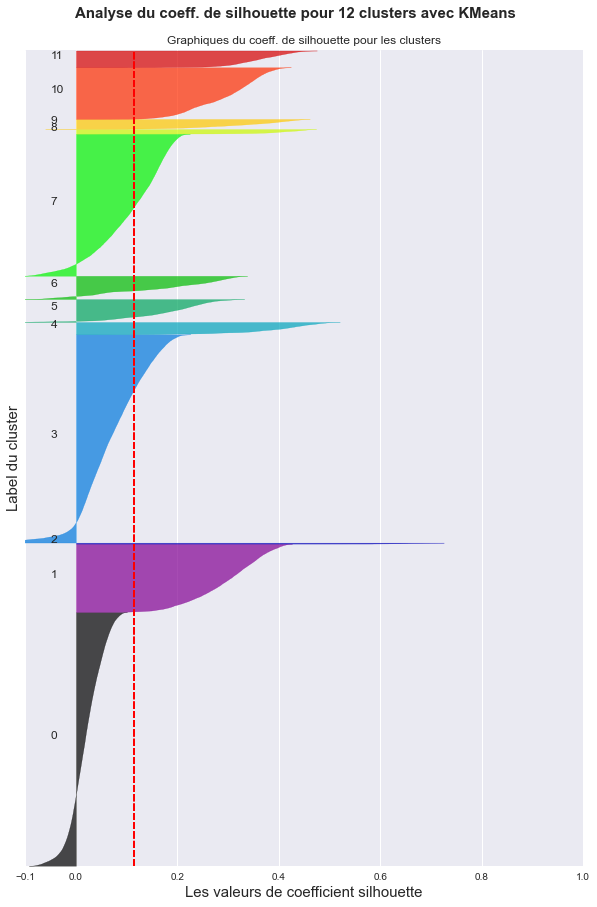

In [73]:
retrieve_dfs_k2 = display_results_w_optimal_clusters_nbr(df_2nd_kmeans_all_features_std, n_clusters = 12)
df_customers_k_labels_2 = retrieve_dfs_k2[0]
df_customers_k_labels_2_num_std = retrieve_dfs_k2[1]

In [74]:
df_customers_k_labels_2.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [75]:
df_customers_k_labels_2_num_std.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             0.481628               -0.186459                    1.474121   
1            -1.699552               -0.186459                   -0.967751   
2            -0.196389               -0.186459                    1.474121   
3            -1.314759               -0.186459                    0.970521   
4             0.817624               -0.186459                    1.290489   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                  -0.17908            -0.116328           -0.698158   
1                  -0.17908            -0.116328           -1.623555   
2                  -0.17908            -0.116328            1.430243   
3                  -0.17908            -0.116328            1.025504   
4                  -0.17908            -0.116328            0.364961   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0           -1.078956            0.781478                -0.151289   
1            0.827045           -0.401647                -0.151289   
2            0.121750           -1.202960                -0.151289   
3            1.384609           -0.401647                -0.151289   
4           -1.060488            0.781478                -0.151289   

   number_orders  number_reviews  order_status  product_density  \
0      -0.177453       -0.177453     -0.035337        -0.677539   
1      -0.177453       -0.177453     -0.035337         0.369419   
2      -0.177453       -0.177453     -0.035337         1.175338   
3      -0.177453       -0.177453     -0.035337        -0.346603   
4      -0.177453       -0.177453     -0.035337        -4.763415   

   product_photos_qty  total_payments_amount  total_products_ordered  \
0           -1.078191               0.369200               -0.376904   
1           -1.078191              -1.965208               -0.376904   
2            0.738093              -0.254325               -0.376904   
3            1.288142              -1.215781               -0.376904   
4            0.738093               0.746084               -0.376904   

   cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0 -0.186343   -0.08903       -0.25828               -0.208131   
1 -0.186343   -0.08903       -0.25828               -0.208131   
2 -0.186343   -0.08903       -0.25828               -0.208131   
3 -0.186343   -0.08903       -0.25828               -0.208131   
4 -0.186343   -0.08903       -0.25828               -0.208131   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                         -0.17769 -0.084801                 -0.311129   
1                         -0.17769 -0.084801                 -0.311129   
2                         -0.17769 -0.084801                 -0.311129   
3                         -0.17769 -0.084801                 -0.311129   
4                         -0.17769 -0.084801                 -0.311129   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                  -0.342224      -0.244159                    1.380912   
1                   2.145210      -0.244159                   -0.428075   
2                  -0.342224      -0.244159                   -0.428075   
3                  -0.342224      -0.244159                   -0.428075   
4                  -0.342224      -0.244159                   -0.428075   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                  -0.298287         -0.066832      -0.192498    -0.115005   
1                  -0.298287         -0.066832      -0.192498    -0.115005   
2                   1.814274         -0.066832      -0.192498    -0.115005   
3                  -0.298287         -0.066832       3.627031    -0.115005   
4                  -0.298287         -0.066832       3.627031    -0.115005   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0      

#### Enregistrements des DataFrames avec le nombre de clusters choisis
- df_customers_k_labels_2 (données réelles = non standardisées pour regarder en détail)
- df_customers_k_labels_2_num_std (données standardisées pour visualisation(s) graphique(s))

##### df_customers_k_labels_2

In [76]:
# On enregistre pour vérifier si le nombre de clusters est qualifiable ou s'il faut en prendre moins ou plus...
df_customers_k_labels_2.loc[-1] = df_customers_k_labels_2.dtypes
df_customers_k_labels_2.index = df_customers_k_labels_2.index + 1
df_customers_k_labels_2.sort_index(inplace=True)
#df_customers_k_labels_2.head()

In [77]:
df_customers_k_labels_2.to_csv('df_customers_k_labels_2.csv', index=False, sep='\t', encoding='utf-8')

In [78]:
# Test de chargement des données
dtypes = pd.read_csv('df_customers_k_labels_2.csv', sep='\t', encoding='utf-8', nrows=1).iloc[0].to_dict()

In [79]:
df_load_customers_k_labels_2 = pd.read_csv(path + '/df_customers_k_labels_2.csv', sep='\t', encoding='utf-8', dtype=dtypes, skiprows=[1])
#df_load_customers_k_labels_2.info()
df_load_customers_k_labels_2.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [80]:
df_load_customers_k_labels_2.loc[2:, :]

customer_unique_id  customer_zip_code_prefix  \
2      0000f46a3911fa3c0805444483337064                     88115   
3      0000f6ccb0745a6a4b88665a16c9f078                     66812   
4      0004aac84e0df4da2b147fca70cf8255                     18040   
5      0004bd2a26a76fe21f786e4fbd80607f                      5036   
6      00050ab1314c0e55a6ca13cf7181fecf                     13084   
...                                 ...                       ...   
95415  fffcf5a5ff07b0908bd4e2dbc735a684                     55250   
95416  fffea47cd6d3cc0a88bd621562a9d061                     44054   
95417  ffff371b4d645b6ecea244b27531430a                     78552   
95418  ffff5962728ec6157033ef9805bacc48                     29460   
95419  ffffd2657e2aad2907e67c3e9daecbeb                     83608   

            customer_city customer_state  number_orders  order_status  \
2                sao jose             SC              1             1   
3                   belem             PA              1             1   
4                sorocaba             SP              1             1   
5               sao paulo             SP              1             1   
6                campinas             SP              1             1   
...                   ...            ...            ...           ...   
95415             sanharo             PE              1             1   
95416    feira de santana             BA              1             1   
95417               sinop             MT              1             1   
95418  bom jesus do norte             ES              1             1   
95419         campo largo             PR              1             1   

       mean_delivery_time  number_reviews  mean_reviews_score  \
2               25.731759               1                 3.0   
3               20.037083               1                 4.0   
4               13.141134               1                 5.0   
5                1.860729               1                 4.0   
6                6.966389               1                 4.0   
...                   ...             ...                 ...   
95415           27.514861               1                 5.0   
95416           30.097500               1                 4.0   
95417           14.872083               1                 5.0   
95418           11.858854               1                 5.0   
95419            7.552118               1                 5.0   

      words_comments_title                             words_comments_message  \
2                      NaN                                                NaN   
3                      NaN                                       Bom vendedor   
4                      NaN                                                NaN   
5                      NaN                                                NaN   
6                      NaN                                                NaN   
...                    ...                                                ...   
95415                  NaN                                                NaN   
95416                  NaN                                                NaN   
95417                  NaN                                                NaN   
95418             ********  excelente lojas, a posterior vou fazer uma aqu...   
95419                  NaN                                                NaN   

       max_number_payments_type  max_number_payments_spread  \
2                           1.0                         8.0   
3                           1.0                         4.0   
4                           1.0                         6.0   
5                           1.0                         8.0   
6                           1.0                         1.0   
...                         ...                         ...   
95415                       1.0                        10.0   
95416                       1.0                         1

In [81]:
# Je repasse la variable corrigée à la valeur initiale
df_load_customers_k_labels_2.loc[: , 'mean_time_between_order'] = \
df_load_customers_k_labels_2['mean_time_between_order'].apply(lambda x: x - 1)

In [82]:
df_load_customers_k_labels_2.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

##### df_customers_k_labels_2_num_std

In [83]:
# On enregistre pour vérifier si le nombre de clusters est qualifiable ou s'il faut en prendre moins ou plus.
df_customers_k_labels_2_num_std.loc[-1] = df_customers_k_labels_2_num_std.dtypes
df_customers_k_labels_2_num_std.index = df_customers_k_labels_2_num_std.index + 1
df_customers_k_labels_2_num_std.sort_index(inplace=True)
df_customers_k_labels_2_num_std.head()

customer_mean_order max_items_type_ordered max_number_payments_spread  \
0             float64                float64                    float64   
1            0.481628              -0.186459                   1.474121   
2           -1.699552              -0.186459                  -0.967751   
3           -0.196389              -0.186459                   1.474121   
4           -1.314759              -0.186459                   0.970521   

  max_number_payments_type max_sellers_ordered mean_delivery_time  \
0                  float64             float64            float64   
1                 -0.17908           -0.116328          -0.698158   
2                 -0.17908           -0.116328          -1.623555   
3                 -0.17908           -0.116328           1.430243   
4                 -0.17908           -0.116328           1.025504   

  mean_perct_freight mean_reviews_score mean_time_between_order number_orders  \
0            float64            float64                 float64       float64   
1          -1.078956           0.781478               -0.151289     -0.177453   
2           0.827045          -0.401647               -0.151289     -0.177453   
3            0.12175           -1.20296               -0.151289     -0.177453   
4           1.384609          -0.401647               -0.151289     -0.177453   

  number_reviews order_status product_density product_photos_qty  \
0        float64      float64         float64            float64   
1      -0.177453    -0.035337       -0.677539          -1.078191   
2      -0.177453    -0.035337        0.369419          -1.078191   
3      -0.177453    -0.035337        1.175338           0.738093   
4      -0.177453    -0.035337       -0.346603           1.288142   

  total_payments_amount total_products_ordered  cat_auto cat_books  \
0               float64                float64   float64   float64   
1                0.3692              -0.376904 -0.186343  -0.08903   
2             -1.965208              -0.376904 -0.186343  -0.08903   
3             -0.254325              -0.376904 -0.186343  -0.08903   
4             -1.215781              -0.376904 -0.186343  -0.08903   

  cat_childhood cat_construction_tools cat_fashion_clothes_accessories  \
0       float64                float64                         float64   
1      -0.25828              -0.208131                        -0.17769   
2      -0.25828              -0.208131                        -0.17769   
3      -0.25828              -0.208131                        -0.17769   
4      -0.25828              -0.208131                        -0.17769   

   cat_food cat_gifts_art_decoration cat_health_beauty_hygiene cat_high_tech  \
0   float64                  float64                   float64       float64   
1 -0.084801                -0.311129                 -0.342224     -0.244159   
2 -0.084801                -0.311129                   2.14521     -0.244159   
3 -0.084801                -0.311129                 -0.342224     -0.244159   
4 -0.084801                -0.311129                 -0.342224     -0.244159   

  cat_home_comfort_appliance cat_home_office_furniture cat_professional  \
0                    float64                   float64          float64   
1                   1.380912                 -0.298287        -0.066832   
2                  -0.428075                 -0.298287        -0.066832   
3                  -0.428075                  1.814274        -0.066832   
4                  -0.428075                 -0.298287        -0.066832   

  cat_telephony cat_unknown cat_video_audio_instruments payment_type_boleto  \
0       float64     float64                     float64             float64   
1     -0.192498   -0.115005                   -0.143808            -0.49149   
2     -0.192498   -0.115005                   -0.143808            -0.49149   
3     -0.192498   -0.115005                   -0.143808            -0.49149   
4      3.627031   -0.115005                   -

In [84]:
df_customers_k_labels_2_num_std.to_csv('df_customers_k_labels_2_num_std.csv', index=False, sep='\t', encoding='utf-8')

In [85]:
# Test de chargement des données
dtypes = pd.read_csv('df_customers_k_labels_2_num_std.csv', sep='\t', encoding='utf-8', nrows=1).iloc[0].to_dict()

In [86]:
df_customers_k_labels_2_num_std = pd.read_csv(path + '/df_customers_k_labels_2_num_std.csv', sep='\t', encoding='utf-8', dtype=dtypes, skiprows=[1])
#df_load_customers_k_labels_2.info()
df_customers_k_labels_2_num_std.head()
#df_customers_k_labels_2_num_std.shape

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             0.481628               -0.186459                    1.474121   
1            -1.699552               -0.186459                   -0.967751   
2            -0.196389               -0.186459                    1.474121   
3            -1.314759               -0.186459                    0.970521   
4             0.817624               -0.186459                    1.290489   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                  -0.17908            -0.116328           -0.698158   
1                  -0.17908            -0.116328           -1.623555   
2                  -0.17908            -0.116328            1.430243   
3                  -0.17908            -0.116328            1.025504   
4                  -0.17908            -0.116328            0.364961   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0           -1.078956            0.781478                -0.151289   
1            0.827045           -0.401647                -0.151289   
2            0.121750           -1.202960                -0.151289   
3            1.384609           -0.401647                -0.151289   
4           -1.060488            0.781478                -0.151289   

   number_orders  number_reviews  order_status  product_density  \
0      -0.177453       -0.177453     -0.035337        -0.677539   
1      -0.177453       -0.177453     -0.035337         0.369419   
2      -0.177453       -0.177453     -0.035337         1.175338   
3      -0.177453       -0.177453     -0.035337        -0.346603   
4      -0.177453       -0.177453     -0.035337        -4.763415   

   product_photos_qty  total_payments_amount  total_products_ordered  \
0           -1.078191               0.369200               -0.376904   
1           -1.078191              -1.965208               -0.376904   
2            0.738093              -0.254325               -0.376904   
3            1.288142              -1.215781               -0.376904   
4            0.738093               0.746084               -0.376904   

   cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0 -0.186343   -0.08903       -0.25828               -0.208131   
1 -0.186343   -0.08903       -0.25828               -0.208131   
2 -0.186343   -0.08903       -0.25828               -0.208131   
3 -0.186343   -0.08903       -0.25828               -0.208131   
4 -0.186343   -0.08903       -0.25828               -0.208131   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                         -0.17769 -0.084801                 -0.311129   
1                         -0.17769 -0.084801                 -0.311129   
2                         -0.17769 -0.084801                 -0.311129   
3                         -0.17769 -0.084801                 -0.311129   
4                         -0.17769 -0.084801                 -0.311129   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                  -0.342224      -0.244159                    1.380912   
1                   2.145210      -0.244159                   -0.428075   
2                  -0.342224      -0.244159                   -0.428075   
3                  -0.342224      -0.244159                   -0.428075   
4                  -0.342224      -0.244159                   -0.428075   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                  -0.298287         -0.066832      -0.192498    -0.115005   
1                  -0.298287         -0.066832      -0.192498    -0.115005   
2                   1.814274         -0.066832      -0.192498    -0.115005   
3                  -0.298287         -0.066832       3.627031    -0.115005   
4                  -0.298287         -0.066832       3.627031    -0.115005   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0      

### Étude/Analyse des clusters créés
- Je souhaite vérifier que le nombre de clusters estimés permet de retourner des segments de clients caractérisables et utilisables pour un département commercial/marketing.
- On va analyser les propriétés de chaque segment de clients (clusters)

In [87]:
# Affichage par clusters de la ville de commandes la plus importante / clients 
df_load_customers_k_labels_2.groupby('k_label')['customer_city'].agg(lambda x: x.value_counts().index[0])

k_label
0     sao paulo
1     sao paulo
2     sao paulo
3     sao paulo
4     sao paulo
5     sao paulo
6     sao paulo
7     sao paulo
8     sao paulo
9     sao paulo
10    sao paulo
11    sao paulo
Name: customer_city, dtype: object

         customer_unique_id
k_label                    
0                     29727
3                     24397
7                     16638
1                      7996
10                     6048
6                      2716
5                      2677
11                     1958
4                      1434
9                      1169
8                       541
2                       119


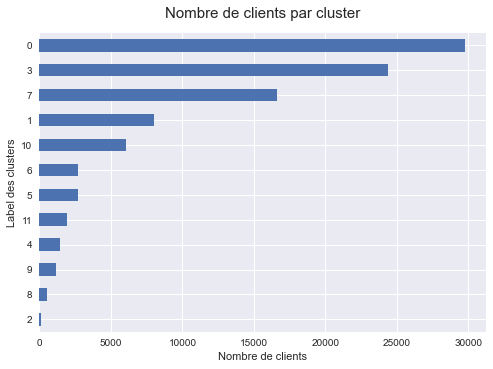

In [88]:
# Rappel du nombre de clients par segment (cluster)
gb_customers_clusters = df_load_customers_k_labels_2.groupby('k_label')['customer_unique_id'].agg('count')
df_customers_clusters = pd.DataFrame(gb_customers_clusters)
print(df_customers_clusters.sort_values('customer_unique_id', ascending=False))

graph = gb_customers_clusters.sort_values().plot(kind='barh')

plt.title("Nombre de clients par cluster", fontsize=15, pad=15)
plt.ylabel("Label des clusters")
plt.xlabel("Nombre de clients")

plt.show()

In [89]:
df_customers_clusters.loc[1]

customer_unique_id    7996
Name: 1, dtype: int64

In [90]:
# Caractérisation des clients du cluster numéro 2
# Note : La moyenne n'est pas la mesure la plus adaptée pour tous les types de variables
display(df_load_customers_k_labels_2[df_load_customers_k_labels_2['k_label'] == 2].mean())

customer_zip_code_prefix           32774.689076
number_orders                          2.235294
order_status                           2.000000
mean_delivery_time                    13.045327
number_reviews                         2.235294
mean_reviews_score                     2.946779
max_number_payments_type               1.084034
max_number_payments_spread             4.470588
total_payments_amount                359.115126
payment_type_boleto                    0.352941
payment_type_credit_card               1.789916
payment_type_debit_card                0.000000
payment_type_voucher                   0.201681
total_products_ordered                 2.554622
max_items_type_ordered                 1.075630
max_sellers_ordered                    1.000000
product_photos_qty                     5.134454
product_density                       78.972676
cat_auto                               0.126050
cat_books                              0.000000
cat_childhood                          0

In [91]:
# Localisation (état fédéral) la plus fréquente pour les clients
print("Etat avec le plus de clients : ", df_load_customers_k_labels_2['customer_state'].mode()[0], "\n")
print(df_load_customers_k_labels_2['customer_state'].value_counts())

Etat avec le plus de clients :  SP 

SP    39970
RJ    12299
MG    11175
RS     5248
PR     4839
SC     3508
BA     3257
DF     2061
ES     1955
GO     1941
PE     1602
CE     1304
PA      944
MT      872
MA      717
MS      688
PB      516
PI      481
RN      471
AL      399
SE      336
TO      272
RO      234
AM      142
AC       77
AP       67
RR       45
Name: customer_state, dtype: int64


In [92]:
# Inspection des clusters
gb_load_customers_k_labels_2 = df_customers_k_labels_2_num_std.groupby('k_label').agg({
    #'customer_zip_code_prefix' : lambda x: len(x.unique()), # nombre de code postaux différents pour un même cluster
    'number_orders' : 'mean',
    #'order_status' : 'mean', # livré, expédié, payé, etc
    'mean_delivery_time' : 'mean', # intéressant par cluster
    'number_reviews' : 'mean', # clients d'un cluster commentent plus qu'un autre ?
    'mean_reviews_score' :  'mean', # clients d'un cluster sont globalement plus satisfait qu'un autre ?
    'max_number_payments_type' : 'mean', # en moyenne le nombre de moyens de paiement employés par les clients 
    'max_number_payments_spread' : 'mean', # les clients payent de manière étalée ? (facilité de paiement en plusieurs fois ?)
    'total_payments_amount' : 'mean', # combien les clients dépesent en moyenne au total ?
    'payment_type_boleto' : 'mean', # type de paiement priviligié ?
    'payment_type_credit_card' : 'mean', # type de paiement priviligié ?
    'payment_type_debit_card' : 'mean', # type de paiement priviligié ?
    'payment_type_voucher' : 'mean', # type de paiement priviligié ?
    'total_products_ordered' : 'mean', # en moyenne combien les clients d'un cluster commandent de produits au total ? (différents ou non)
    'max_items_type_ordered' : 'mean', # en moyenne combien de produits différents commandent les clients ?
    'max_sellers_ordered' : 'mean', # les clients achètent leurs produits au même vendeur ? ou à plusieurs ?
    'product_photos_qty' : 'mean', # nombre de photos sur l'ensemble (permet de savoir/estimer l'importance des visuels)
    'product_density' : 'mean', # En moyenne, est-ce que les clients commandent des produits volumineux ou non ? (armoire vs smarphone ?)
    'cat_auto' : 'mean', # (mean) permet d'estimer l'importance d'une catégorie produit par rapport à une autre dans un même cluster
    'cat_books' : 'mean',
    'cat_childhood' : 'mean',
    'cat_construction_tools' : 'mean',
    'cat_fashion_clothes_accessories' : 'mean',
    'cat_food' : 'mean',
    'cat_gifts_art_decoration' : 'mean',
    'cat_health_beauty_hygiene' : 'mean',
    'cat_high_tech' : 'mean',
    'cat_home_comfort_appliance' : 'mean',
    'cat_home_office_furniture' : 'mean',
    'cat_professional' : 'mean',
    'cat_telephony' : 'mean',
    'cat_unknown' : 'mean',
    'cat_video_audio_instruments' : 'mean' ,
    #'centroid_lat' : 'mean', # à revoir car la moyenne n'est pas intéressante ici
    #'centroid_lng' : 'mean', # à revoir car la moyenne n'est pas intéressante ici
    'mean_time_between_order' : 'mean', # temps moyen entre plusieurs commandes (clients réguliers, fidèles ?)
    'mean_perct_freight' : 'mean', # part du coùt du transport moyen dans les commandes d'un même cluster
    'customer_mean_order' : 'mean' # dépense moyenne d'un client au sein du même cluster
    }).round(1)

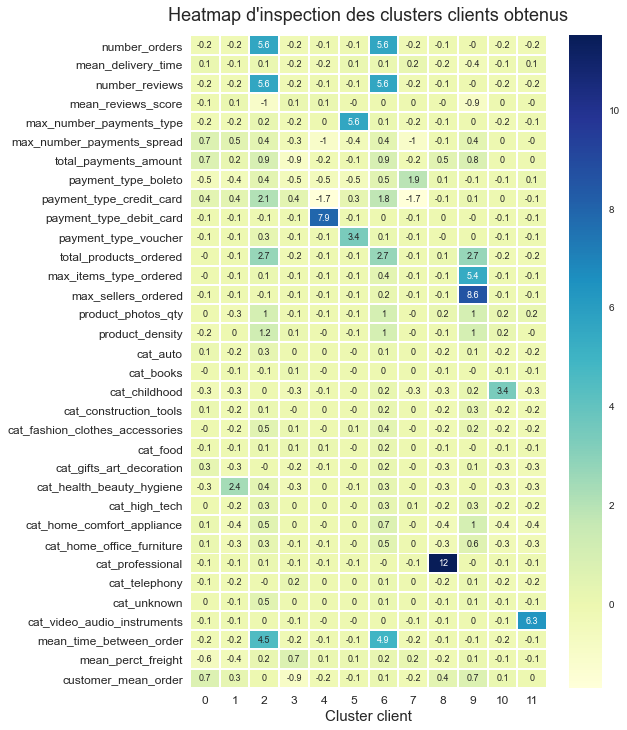

In [93]:
# On affiche les valeurs via une heatmap comme pour les précédents essais avec KMeans
plt.figure(figsize=(8, 12))

ax_k2 = sns.heatmap(
    gb_load_customers_k_labels_2.T,
    cmap='YlGnBu',
    linewidths=1,
    linecolor='white',
    annot=True,
    annot_kws={"size": 9}
)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Heatmap d'inspection des clusters clients obtenus", fontsize=18, pad=15)
plt.xlabel("Cluster client", fontsize=15)

plt.show()

In [94]:
#gb_load_customers_k_labels_2.T.iloc[:, [0]]

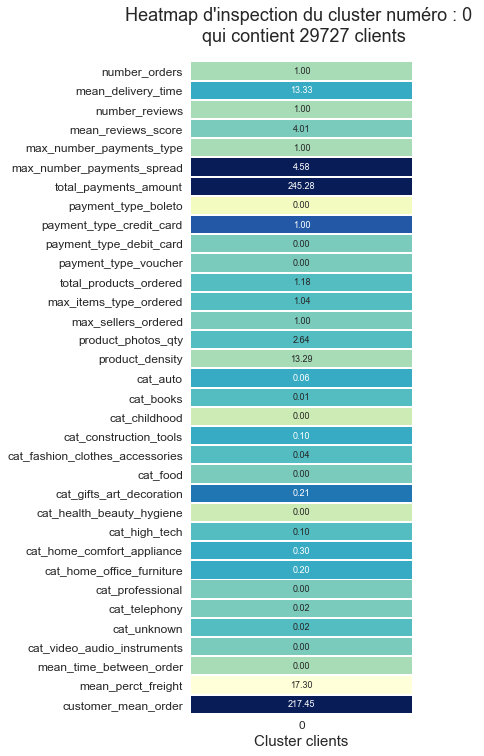

In [95]:
def inspect_customers_cluster(cluster_number):
    """
    Fonction qui permet d'afficher une heatmap en croisant la coloration des valeurs standardisées et 
    les chiffres des valeurs réelles.
    But : faire ressortir plus facilement visuellement les particularités d'un segment clients (cluster).
    
    Args:
        cluster_number (int, list): Label du cluster que l'on souhaite inspecter ou une liste des labels de clusters à comparer
        
    Returns:
        plt.show() (graphic): Retourne un graphique contenant les valeurs du cluster à étudier via une heatmap.
    """
    
    compare_clusters = False
    
    if type(cluster_number) == list and all(isinstance(item, int) for item in cluster_number):
        compare_clusters = True
    else:
        cluster_number = int(cluster_number)
    
    agg_functions = {
        #'customer_zip_code_prefix' : lambda x: len(x.unique()), # nombre de code postaux différents pour un même cluster
        'number_orders' : 'mean',
        #'order_status' : 'mean', # livré, expédié, payé, etc
        'mean_delivery_time' : 'mean', # intéressant par cluster
        'number_reviews' : 'mean', # clients d'un cluster commentent plus qu'un autre ?
        'mean_reviews_score' :  'mean', # clients d'un cluster sont globalement plus satisfait qu'un autre ?
        'max_number_payments_type' : 'mean', # en moyenne le nombre de moyens de paiement employés par les clients 
        'max_number_payments_spread' : 'mean', # les clients payent de manière étalée ? (facilité de paiement en plusieurs fois ?)
        'total_payments_amount' : 'mean', # combien les clients dépesent en moyenne au total ?
        'payment_type_boleto' : 'mean', # type de paiement priviligié ?
        'payment_type_credit_card' : 'mean', # type de paiement priviligié ?
        'payment_type_debit_card' : 'mean', # type de paiement priviligié ?
        'payment_type_voucher' : 'mean', # type de paiement priviligié ?
        'total_products_ordered' : 'mean', # en moyenne combien les clients d'un cluster commandent de produits au total ? (différents ou non)
        'max_items_type_ordered' : 'mean', # en moyenne combien de produits différents commandent les clients ?
        'max_sellers_ordered' : 'mean', # les clients achètent leurs produits au même vendeur ? ou à plusieurs ?
        'product_photos_qty' : 'mean', # nombre de photos sur l'ensemble (permet de savoir/estimer l'importance des visuels)
        'product_density' : 'mean', # En moyenne, est-ce que les clients commandent des produits volumineux ou non ? (armoire vs smarphone ?)
        'cat_auto' : 'mean', # (mean) permet d'estimer l'importance d'une catégorie produit par rapport à une autre dans un même cluster
        'cat_books' : 'mean',
        'cat_childhood' : 'mean',
        'cat_construction_tools' : 'mean',
        'cat_fashion_clothes_accessories' : 'mean',
        'cat_food' : 'mean',
        'cat_gifts_art_decoration' : 'mean',
        'cat_health_beauty_hygiene' : 'mean',
        'cat_high_tech' : 'mean',
        'cat_home_comfort_appliance' : 'mean',
        'cat_home_office_furniture' : 'mean',
        'cat_professional' : 'mean',
        'cat_telephony' : 'mean',
        'cat_unknown' : 'mean',
        'cat_video_audio_instruments' : 'mean' ,
        #'centroid_lat' : 'mean', # à revoir car la moyenne n'est pas intéressante ici
        #'centroid_lng' : 'mean', # à revoir car la moyenne n'est pas intéressante ici
        'mean_time_between_order' : 'mean', # temps moyen entre plusieurs commandes (clients réguliers, fidèles ?)
        'mean_perct_freight' : 'mean', # part du coùt du transport moyen dans les commandes d'un même cluster
        'customer_mean_order' : 'mean' # dépense moyenne d'un client au sein du même cluster
    }
    
    # Nombre de clients dans le cluster
    #print("Nombre de clients présents dans le cluster {} : \n {}".format(cluster_number, df_customers_clusters.loc[cluster_number]))
    
    # Inspection visuelle par le graphique (heatmap)
    gb_load_customers_k_labels_2 = df_customers_k_labels_2_num_std.groupby('k_label').agg(agg_functions).round(1)
    
    # Inspection pour observer des valeurs réelles
    gb_load_customers_k_labels_2_real_values = df_load_customers_k_labels_2.groupby('k_label').agg(agg_functions).round(2)
    df_load_customers_k_labels_2_real_values = pd.DataFrame(gb_load_customers_k_labels_2_real_values)
    #display(df_load_customers_k_labels_2_real_values.iloc[cluster_number, :])
    
    if compare_clusters:
        real_values = df_load_customers_k_labels_2_real_values.iloc[cluster_number, :].T.apply(pd.Series)
        arr_real_values = np.asarray(real_values)
        #display(real_values)
    else:
        real_values = df_load_customers_k_labels_2_real_values.iloc[cluster_number, :].apply(pd.Series)
        arr_real_values = np.asarray(real_values)    
    
    # On affiche les valeurs via une heatmap comme pour les précédents essais avec KMeans
    if compare_clusters:
        data = gb_load_customers_k_labels_2.T.iloc[:, cluster_number]
    else:
        data = gb_load_customers_k_labels_2.T.iloc[:, [cluster_number]]
    
    if compare_clusters and len(cluster_number) > 4:
        plt.figure(figsize=(12, 12))
    else:
        plt.figure(figsize=(4, 12))
    

    ax_k2 = sns.heatmap(
        data,
        cmap='YlGnBu',
        linewidths=1,
        linecolor='white',
        #annot=True,
        annot_kws={"size": 9},
        annot = arr_real_values,
        fmt='.2f', # Astuce suprême pour éviter la notation scientifique par défaut :=) Merci la documentation.
        cbar=False # Pas utile car on utilise la coloration issue de la colormap des données standardisées pour la mise en valeur des valeurs réelles.
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    if compare_clusters == True:
        nbr_customers_list = [str(value).strip('[]') for value in df_customers_clusters.loc[cluster_number].values]
        nbr_customers_list = str(nbr_customers_list).strip('[]').replace("'", "")
        plt.title("Heatmap d'inspection des clusters numéros : {} \n qui contiennent {} clients" \
                  .format(str(cluster_number)[1:-1], nbr_customers_list), fontsize=18, pad=20)
        
    else:
        plt.title("Heatmap d'inspection du cluster numéro : {} \n qui contient {} clients" \
                  .format(cluster_number, df_customers_clusters.loc[cluster_number].apply(str)[0]), fontsize=18, pad=20)
        
    plt.xlabel("Cluster clients", fontsize=15)

    return plt.show()

# Test de la fonction
inspect_customers_cluster(cluster_number=0)

#### Caractérisation Cluster 0 : ( à nommer ensuite) -> étiquette marketing possible
- clients à achat unique
- temps de livraison moyen de 2 semaines environ
- clients qui commentent une unique fois
- clients globalement très satisfaits indice 4 sur une échelle de 1 à 5
- clients qui prévilégient une seul type de paiement
- clients qui étalent le paiement en plusieurs fois (4,58 moy.)
- clients qui ont une moyenne de total d'achats de 245,28 réals (la moyenne pour une commande sera quasi identique)
- client qui ne payent pas en espèces, pas avec la carte débit, et pas avec des coupons
- clients qui utilisent la carte de crédit uniquement
- clients qui commandent à peine plus d'un article / commande
- clients qui commandent à peine plus d'un article différent
- clients qui commandent à un unique vendeur
- clients qui commandent des produits à plus de 2 photos (2,64)
- clients qui commandent des produits qui ont un poids volumérique de 13,29 g/cm3 (unité à revérifier)
- clients qui parmi toutes les catégories sont orientés plutôt (cat_gifts_art_decoration, home_appliance, home_office, cat_construction, cat_high_tech)
- clients qui payent en moyenne environ 17,30% de frais de port sur leur commande.
- clients dont le panier de commande à une moyenne de 217,45 réals (confirme que ce sont majoritairement des commandes uniques à produit unique)

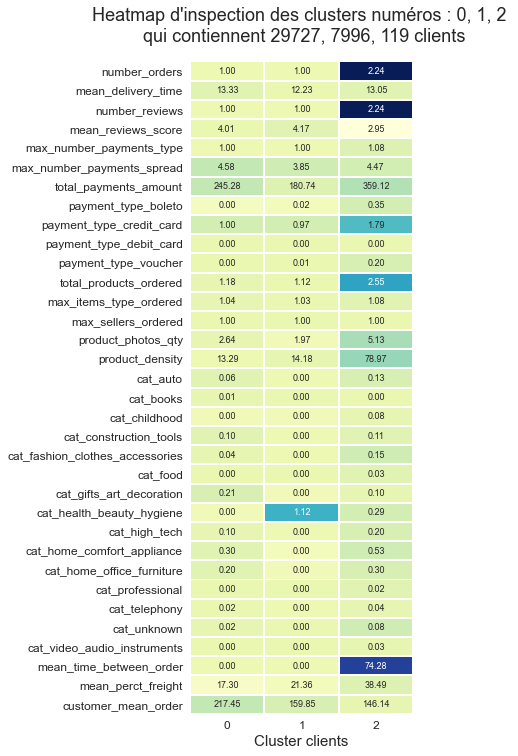

In [96]:
inspect_customers_cluster(cluster_number=[0,1,2])

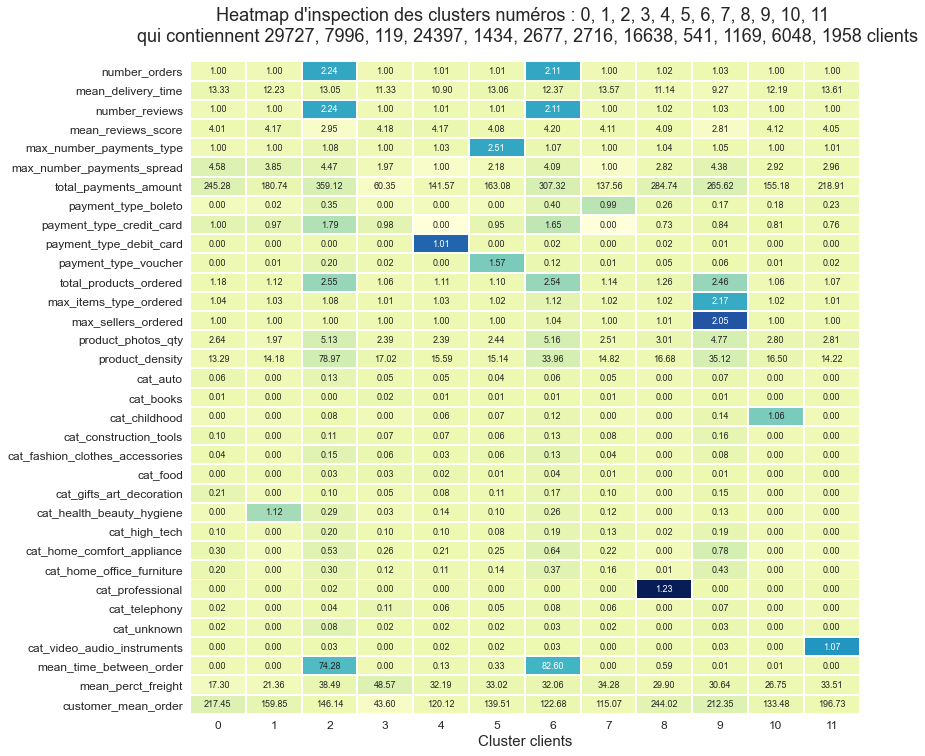

In [97]:
inspect_customers_cluster(cluster_number=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

#### Spécificité par segment type de clients  :
- Rappel : "debit card" -> correspond à la carte de crédit au sens français (donc argent que les clients ont sur leur compte en théorie)
- Rappel : "credit card" -> correspond à une carte de retrait où le client ne possède pas la somme et par conséquent va empreinter (d'où la constation de l'étalement de paiement en plusieurs fois certainement)<br /><br />

- segment 0 de 29727 clients : commande unique, commande moy. de 220 reals env., prévilégient la "credit card", étalent le paiement, satisfaction 4/5, plusieurs catégories d'achats.
- segment 1 de 7996 clients : commande unique, commande moy. de 160 reals env., prévilégient la "credit card", étalement le paiement, satisfaction de 3,85/5, catégorie health/beauty/hygiene privilégiée
- segment 2 de 119 clients: plus de 2 commandes en moy., commande moy de 146 reals env., "credit card" mais pas seulement, étale les paiements, satisfaction 2,95/5, toutes catégories, produits plus lourds, temps entre commandes plus de 2 mois.
- segment 3 de 24397 clients : commande unique, commande moy. de 44 reals env., prévilégient la "credit card", étale le paiement, satisfaction 4,18/5, toutes catégories (cats home plus marquées)
- segment 4 de 1434 clients : commande unique, commande moy. de 120 reals env., prévilégient la "debit card", n'étale pas le paiement,
- etc
- on peut donc caractériser les segments très spécifiquement mais ce n'est pas intelligible pour un service marketing/commercial facilement.
-> Cela peut donc être une aide complémentaire (analyse plus fine) à la caractérisation RFM que j'effectue ensuite.

### Analyse de segmentation RFM

In [98]:
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp'
]
df_rfm_seg = pd.read_csv(path + '/df_rfm_analysis.csv', sep='\t', encoding='utf-8', parse_dates=date_cols)
print(df_rfm_seg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_estimated_delivery_date  99441 non-null  datetime64[ns]
 11  order_delivery_

In [99]:
# On se base sur le statut de commande 'delivered' car 'invoiced' est peu représenté et permet d'éviter les 'canceled'
df_rfm_seg = df_rfm_seg.loc[df_rfm_seg['order_status'] == 'delivered']

In [100]:
# On sélectionne les colonnées d'intérêt
df_rfm_seg = df_rfm_seg[[
    'customer_unique_id',
    'order_id',
    'payment_value',
    'order_purchase_timestamp',
    'order_status'
]]

In [101]:
# On drop les 'erreurs' 
df_rfm_seg.isna().sum()

customer_unique_id          0
order_id                    0
payment_value               1
order_purchase_timestamp    0
order_status                0
dtype: int64

In [102]:
df_rfm_seg.dropna(inplace=True)

In [103]:
df_rfm_seg['order_purchase_timestamp'].min().strftime("%m/%d/%Y")

'10/03/2016'

#### But : Calculer la RFM (les 3 métriques pour segmenter les clients ensuite)
- Recency : Nombre de jours/mois entre la commande et le dernier achat client sur la période étudiée.
- Frequency : Nombre de commandes effectuées par client sur une période définie (12, 24 mois, etc)
- Monetary : Montant total des achats effectués par un client sur la période d'intérêt


In [104]:
# On récupère la période d'étude qui correspond à la première et dernière date d'achat (order_purchase_timestamp)
print(
    "Première date de commande : {} \nDernière date de commande : {}"
    .format(df_rfm_seg['order_purchase_timestamp'].min().strftime("%m/%d/%Y"),
            df_rfm_seg['order_purchase_timestamp'].max().strftime("%m/%d/%Y"))
)

dates_col = df_rfm_seg['order_purchase_timestamp'].sort_values().reset_index(drop=True)
#print(dates_col)
print("Ce qui correspond à une période de {}".format(dates_col.iloc[-1] - dates_col.iloc[0]))

Première date de commande : 10/03/2016 
Dernière date de commande : 08/29/2018
Ce qui correspond à une période de 695 days 05:15:47


In [105]:
# Définition de la date de référence pour le calcul des trois métriques
# On ajoute +1 pour éviter d'avoir zéro lorsque l'on calcule la recency (si le client n'a fait qu'un achat le dernier jour)
ref_date =  df_rfm_seg['order_purchase_timestamp'].max() + datetime.timedelta(days=1)
print(ref_date)

2018-08-30 15:00:37


In [106]:
# On utilise un groupby pour effectuer les calculs
gb_customer_rfm_values = df_rfm_seg.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda x: (ref_date - x.max()).days, #timestamp
    'order_id' : 'count', # nombre totale de commandes passées
    'payment_value' : 'sum' # montant total dépensé par le client
})

gb_customer_rfm_values.rename(columns={
    'order_purchase_timestamp' : 'recency',
    'order_id' : 'frequency',
    'payment_value' : 'monetary'
}, inplace=True)

In [107]:
display(gb_customer_rfm_values.head())

recency  frequency  monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
0000f46a3911fa3c0805444483337064      537          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
0004aac84e0df4da2b147fca70cf8255      288          1    196.89

In [108]:
# Rappel pour moi : plus la recency est basse, plus le client a été 'actif' récemment
# donc inversement il faudra lui attribuer un "ranking" plus élevé par exemple.
print(gb_customer_rfm_values['recency'].min())
print(gb_customer_rfm_values['recency'].max())

1
695


#### RFM Score et Segment
- Par contre il faut définir un nombre de segment.
- D'après l'EDA, intuitement (grossièrement) je distingue plutôt 3/4 groupes de clients
- Basés sur : La Fidélité, Le montant(bas/haut), L'activité(récente/ancienne) -> 8 combinaisons
- Partons sur un essai de 4 segments pour voir si l'on peut les caractériser déjà correctement.

In [109]:
# Définition du ranking par métrique (inversé -> car plus haut = plus récent donc basse valeur de recency)
recency_rank_label = range(4, 0, -1)
frequency_rank_label = range(1, 5)
monetary_rank_label = range(1, 5)

In [110]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
# Rappel : autant de quantiles que de labels...
recency_qcut = pd.qcut(gb_customer_rfm_values['recency'], q=4, labels=recency_rank_label)
frequency_qcut = pd.qcut(gb_customer_rfm_values['frequency'].rank(method='first'), q=4, labels=frequency_rank_label)
monetary_qcut = pd.qcut(gb_customer_rfm_values['monetary'], q=4, labels=monetary_rank_label)

In [111]:
# On ajoute les valeurs par colonnes respectives
gb_customer_rfm_values = gb_customer_rfm_values.assign(
    r_rank = recency_qcut.values,
    f_rank = frequency_qcut.values,
    m_rank = monetary_qcut.values
)

display(gb_customer_rfm_values.head())

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank  
customer_unique_id                       
0000366f3b9a7992bf8c76cfdf3221e2      3  
0000b849f77a49e4a4ce2b2a4ca5be3f      1  
0000f46a3911fa3c0805444483337064      2  
0000f6ccb0745a6a4b88665a16c9f078      1  
0004aac84e0df4da2b147fca70cf8255      4

In [112]:
# On ajoute le segment RFM à l'ensemble avant de calculer RFM score qui est la somme des colonnes 'rank' par ligne
gb_customer_rfm_values['rfm_segment'] = \
gb_customer_rfm_values[['r_rank', 'f_rank', 'm_rank']]\
.apply(lambda x: ''.join(str(x.values))[1:-1].replace(" ", ""), axis=1)

In [113]:
# Calcul du Score RFM
gb_customer_rfm_values['rfm_score'] = gb_customer_rfm_values[['r_rank', 'f_rank', 'm_rank']].sum(axis=1)

In [114]:
display(gb_customer_rfm_values.head())

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5  
0000f46a3911fa3c0805444483337064      2         112          4  
0000f6ccb0745a6a4b88665a16c9f078      1         211          4  
0004aac84e0df4da2b147fca70cf8255      4         214          7

In [115]:
# https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.size.html
gb_customer_rfm_values.groupby('rfm_segment').size().sort_values(ascending=False).head(25)

rfm_segment
444    1781
344    1748
244    1621
122    1602
121    1587
232    1584
313    1552
423    1551
421    1539
144    1538
343    1538
132    1531
112    1520
111    1519
311    1518
321    1518
413    1516
131    1510
222    1508
433    1504
212    1496
331    1493
231    1493
431    1492
223    1485
dtype: int64

In [116]:
# regardons les valeurs de segment [111] correspondant à des clients à commande unique et très peu élevée
gb_customer_rfm_values[gb_customer_rfm_values['rfm_score'] == 3].sort_values('monetary').head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
2ab9d099a3848dd313d2c91159ddff27      370          1     14.13      1      1   
0651cfbea51afc6cfa5ec45bca3ee692      469          1     14.78      1      1   
4079d39cb3fdea47201540107c1673dc      580          1     14.86      1      1   
1b10d58aef8d0d26651c02d40f765cae      574          1     15.29      1      1   
04544a89f79714c0abcc3ae49e884209      580          1     15.71      1      1   

                                 m_rank rfm_segment  rfm_score  
customer_unique_id                                              
2ab9d099a3848dd313d2c91159ddff27      1         111          3  
0651cfbea51afc6cfa5ec45bca3ee692      1         111          3  
4079d39cb3fdea47201540107c1673dc      1         111          3  
1b10d58aef8d0d26651c02d40f765cae      1         111          3  
04544a89f79714c0abcc3ae49e884209      1         111          3

In [117]:
# Statistiques descriptives en groupant par RFM score
gb_customer_rfm_values.groupby('rfm_score').agg({
    'recency' : 'mean', 
    'frequency' : ['mean', 'max'], # les deux sont intéressant car le dataset est assez particulier
    'monetary' : ['mean', 'count'] # on ajoute 'count' (pour avoir une idée de la répartition des montants moyens représentatifs)
}).round(1)

recency frequency     monetary       
             mean      mean max     mean  count
rfm_score                                      
3           455.1       1.0   1     43.9   1519
4           395.2       1.0   1     56.9   4578
5           346.9       1.0   1     72.5   8970
6           300.9       1.0   3    109.3  14486
7           252.7       1.0   4    138.0  17457
8           212.0       1.0   6    170.4  16929
9           175.6       1.0   4    219.9  14173
10          134.1       1.1   5    257.0   8872
11          100.1       1.2   9    314.6   4592
12           58.6       1.4  15    408.2   1781

- On remarque que plus le score est élevé plus les trois métriques le sont également.
- la métrique 'monetary' partie 'count', permet de distinguer 4 ou 5 groupes de clients.

#### Commercial / Marking possible segmentation issue de cette RFM

In [118]:
# update -> apply sur toute la colonne -> bien plus rapide
def segment_characterization(gb_rfm):
    """
    Fonction qui permet de réduire le nombre de segments clients en les caractérisant par un label en fonction du score RFM.
    
    Args:
        gb_rfm (DataFrame): Dataframe contenant la RFM score ('rfm_score') avec les métriques aggrégées.
        
    Returns:
        segment_label (string): Label que l'on souhaite donner pour caractériser un segment particulier.
    """
    
    if gb_rfm['rfm_score'] == 3:
        return 'occasional'
    elif gb_rfm['rfm_score'] >= 4 and gb_rfm['rfm_score'] < 6:
        return 'occasional++' # meilleure dépense moyenne qu' "occasional"
    elif gb_rfm['rfm_score'] >= 6 and gb_rfm['rfm_score'] <= 10:
        return 'actual target' # caractérise la majorité des clients actuels
    elif gb_rfm['rfm_score'] >= 11:
        return 'interesting potential++' # récents, plus réguliers, à fort potentiel d'achat(s)

gb_customer_rfm_values['segment_label'] = gb_customer_rfm_values.apply(segment_characterization, axis=1)
display(gb_customer_rfm_values.head())

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target  
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++  
0000f46a3911fa3c0805444483337064      2         112          4   occasional++  
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++  
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target

In [119]:
# On effectue à nouveau les mêmes statistiques descriptives à partir des labels créés pour vérifier leur pertinence
gb_agg_seg_label = gb_customer_rfm_values.groupby('segment_label').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : ['mean', 'count']
}).round(1)

display(gb_agg_seg_label)

recency frequency monetary       
                           mean      mean     mean  count
segment_label                                            
actual target             223.0       1.0    170.7  71917
interesting potential++    88.5       1.2    340.8   6373
occasional                455.1       1.0     43.9   1519
occasional++              363.2       1.0     67.3  13548

In [120]:
gb_agg_seg_label.columns = ['recency_mean', 'frequency_mean', 'monetary_mean', 'monetary_count']

In [121]:
percent_agg_seg_label = gb_agg_seg_label.apply(lambda x: x/x.sum()).multiply(100).round(1)

In [122]:
display(percent_agg_seg_label)

recency_mean  frequency_mean  monetary_mean  \
segment_label                                                          
actual target                    19.7            23.8           27.4   
interesting potential++           7.8            28.6           54.7   
occasional                       40.3            23.8            7.0   
occasional++                     32.1            23.8           10.8   

                         monetary_count  
segment_label                            
actual target                      77.0  
interesting potential++             6.8  
occasional                          1.6  
occasional++                       14.5

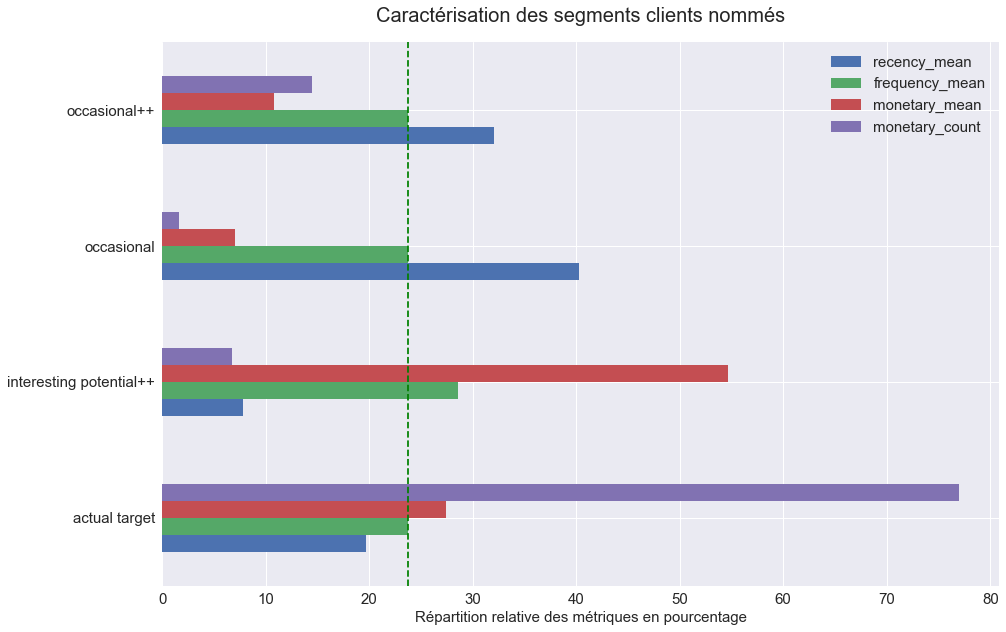

In [123]:
percent_agg_seg_label.plot.barh(figsize=(15,10))

plt.axvline(x=23.8, color="g", linestyle="--")

plt.title("Caractérisation des segments clients nommés", fontsize=20, pad=20)
plt.ylabel("")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Répartition relative des métriques en pourcentage", fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

#### Analyses complémentaires RFM
- voir si croisement avec résultats K-Means possible

In [124]:
# Statistiques sur les trois métriques RFM pour regarder les différences de variance, moyenne.
gb_customer_rfm_values[['recency', 'frequency', 'monetary']].agg(['count', 'mean', 'std', 'min']).round(2)

recency  frequency  monetary
count  93357.00   93357.00  93357.00
mean     237.94       1.03    165.20
std      152.58       0.21    226.31
min        1.00       1.00      9.59

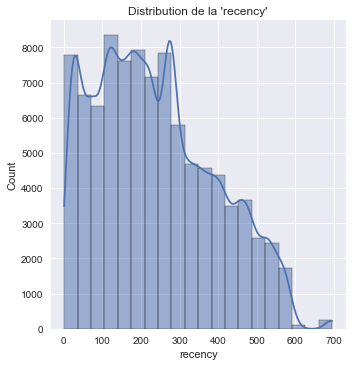

In [125]:
# Caractérisation visuelle de la forme des métriques RFM
# Distribution de la 'recency' : right skewed
# Note : sns.distplot est déprécié -> à remplacer par displot avec paramètres kde + bins pour équivalent
g_r = sns.displot(gb_customer_rfm_values['recency'], kde=True, bins=20)
plt.title("Distribution de la 'recency'")
plt.show()

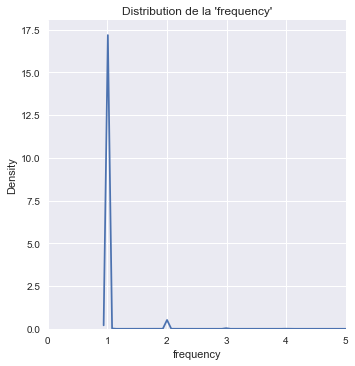

In [126]:
# conclusion : right skewed
g_f = sns.displot(gb_customer_rfm_values['frequency'], kind='kde')
plt.title("Distribution de la 'frequency'")
plt.xlim([0, 5])
plt.show()

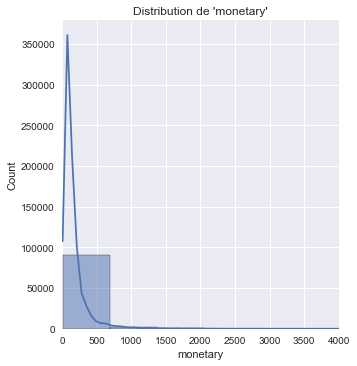

In [127]:
# conclusion : right skewed
g_m = sns.displot(gb_customer_rfm_values['monetary'], kde=True, bins=20)
plt.title("Distribution de 'monetary'")
plt.xlim([0, 4000])
plt.show()

#### Transformation des variables comme pour KMeans et boxcox

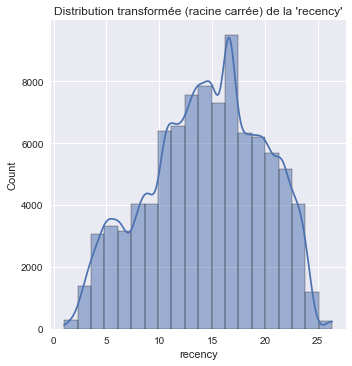

In [128]:
# ici transformation par la racine carrée.
# le log donne de moins bons résultats pour la symétrie sur cette distribution
sqrt_recency = np.sqrt(gb_customer_rfm_values['recency'])
g_r_sqrt = sns.displot(sqrt_recency, kde=True, bins=20)
plt.title("Distribution transformée (racine carrée) de la 'recency'")
plt.show()

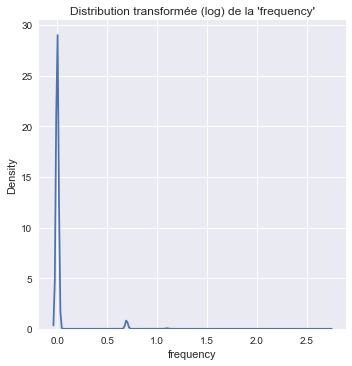

In [129]:
# Pas de changement et c'est normal vu les valeurs de la distribution d'origine
log_frequency = np.log(gb_customer_rfm_values['frequency'])
g_f_log = sns.displot(log_frequency, kind='kde')
plt.title("Distribution transformée (log) de la 'frequency'")
#plt.xlim([0, 5])
plt.show()

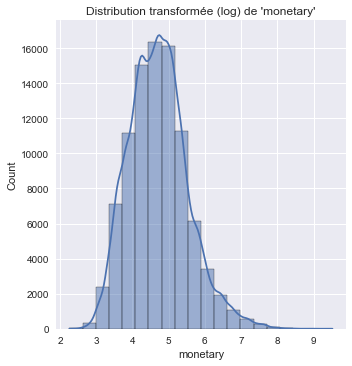

In [130]:
log_monetary = np.log(gb_customer_rfm_values['monetary'])
g_m_log = sns.displot(log_monetary, kde=True, bins=20)
plt.title("Distribution transformée (log) de 'monetary'")
#plt.xlim([0, 4000])
plt.show()

In [131]:
# On ajoute les distributions transformées au dataframe
# On ne change pas la 'frequency car aucune amélioration via np.sqrt ou np.log'
gb_customer_rfm_values['sqrt_recency'] = sqrt_recency
gb_customer_rfm_values['log_monetary'] = log_monetary
display(gb_customer_rfm_values.head())

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123  
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849  
0000f46a3911fa3c0805444483337064     23.173260      4.456902  
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516  
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645

#### On centre et on met à l'échelle les trois métriques RFM
- centering : on soustrait chaque valeur par la moyenne de la série (mean -> proche 0)
- scaling :   on divise par l'écart type de la série (std -> max 1)
- On utilise comme pour KMeans StandardScaler de sklearn

In [132]:
rfm_scaler = StandardScaler()
# Attention retourne bien un ndarray
arr_customer_rfm_values_std = \
rfm_scaler.fit_transform(gb_customer_rfm_values[['sqrt_recency', 'frequency', 'log_monetary']])

In [133]:
print(arr_customer_rfm_values_std[:5])

[[-0.71821914 -0.15983028  0.29136246]
 [-0.6920906  -0.15983028 -1.73257586]
 [ 1.61817824 -0.15983028 -0.31892845]
 [ 0.64266627 -0.15983028 -1.153587  ]
 [ 0.46713194 -0.15983028  0.69255853]]


In [134]:
# On vérifie le résultat + round() pour faciliter la lecture 
print("Moyennes RFM obtenues:", arr_customer_rfm_values_std.mean(axis=0).round(1))
print("Déviations Std RFM obtenues:", arr_customer_rfm_values_std.std(axis=0).round(1))

Moyennes RFM obtenues: [ 0. -0.  0.]
Déviations Std RFM obtenues: [1. 1. 1.]


In [135]:
# On recréé un dataframe à partir de l'array transformé
df_rfm_values_std = pd.DataFrame(
    arr_customer_rfm_values_std,
    index=gb_customer_rfm_values.index,
    columns=['std_recency', 'std_frequency', 'std_monetary']
)

display(df_rfm_values_std.describe().loc[['count', 'mean', 'std']].round(2))

std_recency  std_frequency  std_monetary
count      93357.0        93357.0       93357.0
mean           0.0            0.0           0.0
std            1.0            1.0           1.0

In [136]:
df_customer_rfm_values = pd.concat([gb_customer_rfm_values, df_rfm_values_std], axis=1)

In [137]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362  
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576  
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928  
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587  
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559

#### K-Means clustering sur les données RFM normalisées

In [138]:
%%time
%%script false
# On récupère les données des métriques en fonctions de l'évolution du nombre de clusters impliqués
rfm_inertia_silhouette_idx_db = cal_metrics_w_clusters_nbr(
    df_customer_rfm_values[['std_recency', 'std_frequency', 'std_monetary']],
    k_range=range(2, 13)
)

Couldn't find program: 'false'
Wall time: 7 ms


In [139]:
%%script false
# On sauvegarde le résultat dans un fichier pickle
pickle.dump(rfm_inertia_silhouette_idx_db, open("rfm_inertia_silhouette_idx_db.pkl", "wb"))

Couldn't find program: 'false'


In [140]:
# On recharge les données via le fichier pickle
rfm_inertia_silhouette_idx_db = pickle.load(open("rfm_inertia_silhouette_idx_db.pkl", "rb"))

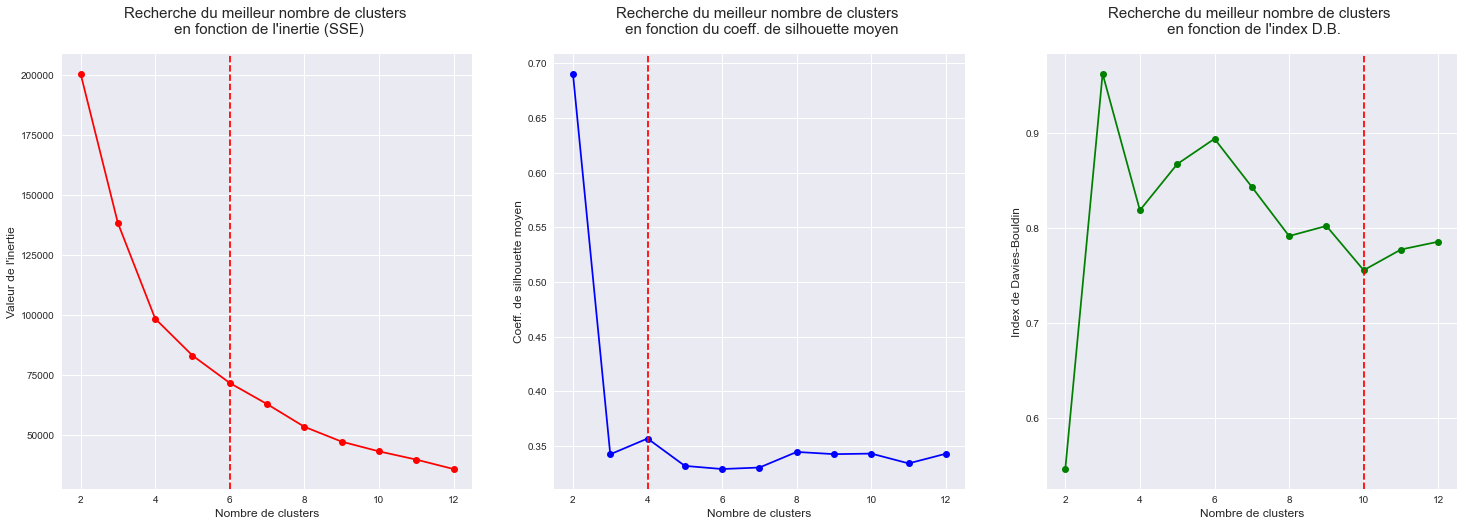

In [141]:
find_best_clusters_nbr(rfm_inertia_silhouette_idx_db, k_range=range(2, 13), x_lines=[6, 4, 10])

In [142]:
%%time
# Un bon compromis en tenant compte des trois indices serait à 10 clusters ou 4,
# si l'on en veut moins pour faciliter l'interprétation
nbr_clusters_rfm = 4
dataframe_of_interest = df_customer_rfm_values[['std_recency', 'std_frequency', 'std_monetary']]

km_model_rfm = KMeans(init='k-means++', n_clusters=nbr_clusters_rfm, random_state=42)
km_labels_rfm = km_model_rfm.fit_predict(dataframe_of_interest) 
# ou simplement fit() -> km_model.labels_

# SSE -> Inertia (plus la valeur est basse, plus c'est intéressant)
inertia_value = km_model_rfm.inertia_
print("Clusters Inertia (SSE) : ", inertia_value)

# silhouette_score -> moyenne pour l'ensemble (donne une idée de la densité/niveau de séparation des clusters)
silhouette_avg = silhouette_score(dataframe_of_interest, km_labels_rfm)
print("Silhouette avg :", silhouette_avg)

# Index Davies-Bouldin -> doit être le plus proche de zéro pour une bonne séparation inter-clusters
davies_bouldin_index = davies_bouldin_score(dataframe_of_interest, km_labels_rfm)
print("Davies-Bouldin index : ", davies_bouldin_index)

Clusters Inertia (SSE) :  98536.68130049255
Silhouette avg : 0.3569513612833366
Davies-Bouldin index :  0.8183446419815763
Wall time: 3min 22s


In [143]:
# On ajoute les labels obtenues au dataframe initial pour caractériser ensuite par clusters
df_customer_rfm_values = df_customer_rfm_values.assign(k_label=km_labels_rfm)

In [144]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  k_label  
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362        2  
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576        2  
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928        1  
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587        1  
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559        0

In [145]:
df_seg_label_dummies = pd.get_dummies(df_customer_rfm_values[['segment_label']], prefix=['cat'])

In [146]:
df_customer_rfm_values = pd.concat([df_customer_rfm_values, df_seg_label_dummies], axis=1)

In [147]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  k_label  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362        2   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576        2   
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928        1   
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587        1   
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559        0   

                                  cat_actual target  \
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0   
0000f46a3911fa3c0805444483337064                  0   
0000f6ccb0745a6a4b88665a16c9f078                  0   
0004aac84e0df4da2b147fca70cf8255                  1   

                                  cat_interesting potential++  cat_occasional  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                            0               0   
0000b849f77a49e4a4ce2b2a4ca5be3f                            0               0   
0000f46a3911fa3c0805444483337064                            0               0   
0000f6ccb0745a6a4b88665a16c9f078                            0               0   
0004aac84e0df4da2b147fca70cf8255                            0               0   

                                  cat_occasional++  
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2                 0  
0000b849f77a49e4a4ce2b2a4ca5be3f                 1  
0000f46a3911fa3c0805444483337064                 1  
0000f6ccb0745a6a4b88665a16c9f078                 1  
0004aac84e0df4da2b147fca70cf8255                 0

In [148]:
gb_rfm_k_labels = df_customer_rfm_values.groupby('k_label').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : ['mean', 'count'],
    'cat_actual target' : 'sum',
    'cat_interesting potential++' : 'sum',
    'cat_occasional' : 'sum',
    'cat_occasional++' : 'sum'
}).round(1) # arrondi suffisant

In [149]:
gb_rfm_k_labels

recency frequency monetary        cat_actual target  \
           mean      mean     mean  count               sum   
k_label                                                       
0         266.0       1.0    345.4  25410           22677.0   
1         345.8       1.0     75.4  35859           21696.0   
2          83.3       1.0    105.0  29287           25933.0   
3         220.3       2.1    308.6   2801            1611.0   

        cat_interesting potential++ cat_occasional cat_occasional++  
                                sum            sum              sum  
k_label                                                              
0                            2485.0            0.0            248.0  
1                               0.0         1519.0          12644.0  
2                            2698.0            0.0            656.0  
3                            1190.0            0.0              0.0

In [150]:
gb_rfm_k_labels.columns = [
    'recency_mean',
    'frequency_mean',
    'monetary_mean',
    'monetary_count',
    'cat_actual target',
    'cat_interesting potential++',
    'cat_occasional',
    'cat_occasional++',
]

In [151]:
gb_rfm_k_labels.sort_values(by=['recency_mean', 'monetary_mean'])

recency_mean  frequency_mean  monetary_mean  monetary_count  \
k_label                                                                
2                83.3             1.0          105.0           29287   
3               220.3             2.1          308.6            2801   
0               266.0             1.0          345.4           25410   
1               345.8             1.0           75.4           35859   

         cat_actual target  cat_interesting potential++  cat_occasional  \
k_label                                                                   
2                  25933.0                       2698.0             0.0   
3                   1611.0                       1190.0             0.0   
0                  22677.0                       2485.0             0.0   
1                  21696.0                          0.0          1519.0   

         cat_occasional++  
k_label                    
2                   656.0  
3                     0.0  
0                   248.0  
1                 12644.0

In [152]:
gb_rfm_k_labels[[
    'cat_actual target',
    'cat_interesting potential++',
    'cat_occasional',
    'cat_occasional++'
]] = gb_rfm_k_labels[[
    'cat_actual target',
    'cat_interesting potential++',
    'cat_occasional',
    'cat_occasional++'
]].apply(lambda x: x/x.sum()).multiply(100).round(1)

In [153]:
# Comparaison entre le clustering et la segmentation RFM avec les labels de segment en %
gb_rfm_k_labels.sort_values(by=['recency_mean', 'monetary_mean'])

recency_mean  frequency_mean  monetary_mean  monetary_count  \
k_label                                                                
2                83.3             1.0          105.0           29287   
3               220.3             2.1          308.6            2801   
0               266.0             1.0          345.4           25410   
1               345.8             1.0           75.4           35859   

         cat_actual target  cat_interesting potential++  cat_occasional  \
k_label                                                                   
2                     36.1                         42.3             0.0   
3                      2.2                         18.7             0.0   
0                     31.5                         39.0             0.0   
1                     30.2                          0.0           100.0   

         cat_occasional++  
k_label                    
2                     4.8  
3                     0.0  
0                     1.8  
1                    93.3

#### Interprétation des segments K-means/RFM
- Précédent graphique pas évident à interpréter -> test de visualisation de type "snake plots"


In [154]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  k_label  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362        2   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576        2   
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928        1   
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587        1   
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559        0   

                                  cat_actual target  \
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0   
0000f46a3911fa3c0805444483337064                  0   
0000f6ccb0745a6a4b88665a16c9f078                  0   
0004aac84e0df4da2b147fca70cf8255                  1   

                                  cat_interesting potential++  cat_occasional  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                            0               0   
0000b849f77a49e4a4ce2b2a4ca5be3f                            0               0   
0000f46a3911fa3c0805444483337064                            0               0   
0000f6ccb0745a6a4b88665a16c9f078                            0               0   
0004aac84e0df4da2b147fca70cf8255                            0               0   

                                  cat_occasional++  
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2                 0  
0000b849f77a49e4a4ce2b2a4ca5be3f                 1  
0000f46a3911fa3c0805444483337064                 1  
0000f6ccb0745a6a4b88665a16c9f078                 1  
0004aac84e0df4da2b147fca70cf8255                 0

In [155]:
# On utilise les valeurs (métriques RFM standardisées) pour pouvoir les comparer
# Il faut passer du format de données "wide" to "long" pour pouvoir les afficher facilement
df_melt_customer_rfm_values = pd.melt(
    df_customer_rfm_values[['k_label', 'std_recency', 'std_frequency', 'std_monetary']].reset_index(), # reset_index essentiel pour le graphique
    id_vars=['customer_unique_id', 'k_label'], # colonnes que l'on ne pivotent pas
    value_vars=['std_recency', 'std_frequency', 'std_monetary'], # variables "wide" to "long"
    var_name='rfm_metrics', value_name='rfm_value'
)

display(df_melt_customer_rfm_values)

customer_unique_id  k_label   rfm_metrics  rfm_value
0       0000366f3b9a7992bf8c76cfdf3221e2        2   std_recency  -0.718219
1       0000b849f77a49e4a4ce2b2a4ca5be3f        2   std_recency  -0.692091
2       0000f46a3911fa3c0805444483337064        1   std_recency   1.618178
3       0000f6ccb0745a6a4b88665a16c9f078        1   std_recency   0.642666
4       0004aac84e0df4da2b147fca70cf8255        0   std_recency   0.467132
...                                  ...      ...           ...        ...
280066  fffcf5a5ff07b0908bd4e2dbc735a684        0  std_monetary   3.572900
280067  fffea47cd6d3cc0a88bd621562a9d061        1  std_monetary  -0.342453
280068  ffff371b4d645b6ecea244b27531430a        1  std_monetary   0.006533
280069  ffff5962728ec6157033ef9805bacc48        2  std_monetary   0.218357
280070  ffffd2657e2aad2907e67c3e9daecbeb        1  std_monetary  -0.547216

[280071 rows x 4 columns]

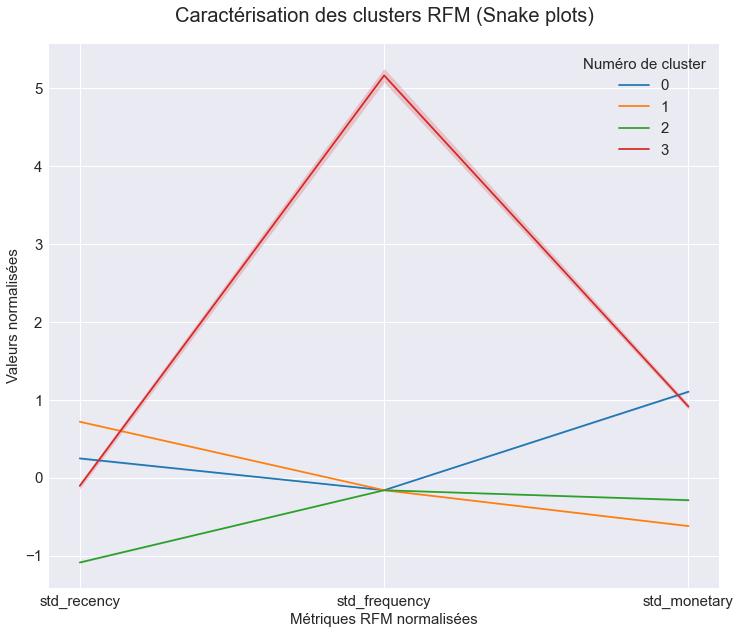

In [156]:
plt.figure(figsize=(12,10))

sns.lineplot(
    data=df_melt_customer_rfm_values,
    x='rfm_metrics',
    y='rfm_value',
    hue='k_label',
    palette=sns.color_palette("tab10")[:4]
)
plt.title("Caractérisation des clusters RFM (Snake plots)", fontsize=20, pad=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Métriques RFM normalisées", fontsize=15)
plt.ylabel("Valeurs normalisées", fontsize=15)
legend = plt.legend(title="Numéro de cluster", prop={'size': 15})
legend.get_title().set_fontsize('15')

plt.show()

#### Caractérisation des segments RFM par rapport au nombre de clients total
- Je cherche à obtenir l'importance de chaque métrique (RFM) relative dans un segment et pouvoir comparer l'ensemble ensuite plus facilement
- Cela revient à calculer le rapport entre la moyenne RFM par cluster par la moyenne RFM pour l'ensemble des clients
- Les valeurs positives/négatives les plus significatives mettront en évidence la spécificité des clusters

In [157]:
# Valeurs non normalisées puisque l'on effectue un rapport de même grandeur de valeurs (moyenne à moyenne)
df_rfm_values = df_customer_rfm_values[['recency', 'frequency', 'monetary']].copy() # copy optionnel -> sécurité
df_rfm_values_w_k_label = df_customer_rfm_values[['recency', 'frequency', 'monetary', 'k_label']].copy()

In [158]:
# On calcule les moyennes RFM par clusters et RFM pour l'ensemble des clients
clusters_rfm_avg = df_rfm_values_w_k_label.groupby('k_label').mean()
customers_rfm_avg = df_rfm_values.mean()
# calcul du rapport
rfm_seg_relative_weight = clusters_rfm_avg / customers_rfm_avg - 1
print(rfm_seg_relative_weight)

          recency  frequency  monetary
k_label                               
0        0.117929  -0.032339  1.090923
1        0.453124  -0.032339 -0.543383
2       -0.650032  -0.032339 -0.364202
3       -0.074146   1.045526  0.867985


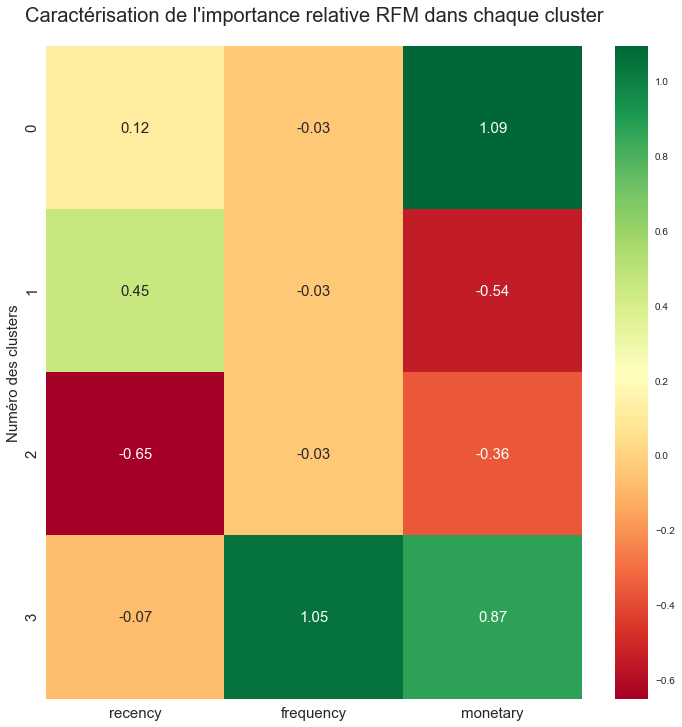

In [159]:
# Heatmap pour faciliter la lecture et l'interprétation
plt.figure(figsize=(12,12))

sns.heatmap(
    data=rfm_seg_relative_weight,
    annot=True,
    annot_kws={"size":15},
    fmt='.2f',
    cmap='RdYlGn' # Red Yellow Green -> idéal
)
plt.title("Caractérisation de l'importance relative RFM dans chaque cluster", fontsize=20, pad=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Numéro des clusters", fontsize=15)

plt.show()

### Croisement des données RFM/KMeans avec NMF des catégories

In [160]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  k_label  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362        2   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576        2   
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928        1   
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587        1   
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559        0   

                                  cat_actual target  \
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0   
0000f46a3911fa3c0805444483337064                  0   
0000f6ccb0745a6a4b88665a16c9f078                  0   
0004aac84e0df4da2b147fca70cf8255                  1   

                                  cat_interesting potential++  cat_occasional  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                            0               0   
0000b849f77a49e4a4ce2b2a4ca5be3f                            0               0   
0000f46a3911fa3c0805444483337064                            0               0   
0000f6ccb0745a6a4b88665a16c9f078                            0               0   
0004aac84e0df4da2b147fca70cf8255                            0               0   

                                  cat_occasional++  
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2                 0  
0000b849f77a49e4a4ce2b2a4ca5be3f                 1  
0000f46a3911fa3c0805444483337064                 1  
0000f6ccb0745a6a4b88665a16c9f078                 1  
0004aac84e0df4da2b147fca70cf8255                 0

In [161]:
cat_prod_cols = [cat_prod for cat_prod in df_customers.columns if cat_prod.startswith('cat_')] + ['customer_unique_id']
print(cat_prod_cols)

['cat_auto', 'cat_books', 'cat_childhood', 'cat_construction_tools', 'cat_fashion_clothes_accessories', 'cat_food', 'cat_gifts_art_decoration', 'cat_health_beauty_hygiene', 'cat_high_tech', 'cat_home_comfort_appliance', 'cat_home_office_furniture', 'cat_professional', 'cat_telephony', 'cat_unknown', 'cat_video_audio_instruments', 'customer_unique_id']


In [162]:
df_rfm_km_w_cat_prod = pd.merge(
    df_customer_rfm_values.reset_index(),
    df_customers[cat_prod_cols],
    on='customer_unique_id',
    how='left' # jointure gauche sur la référence rfm
)

display(df_rfm_km_w_cat_prod.head())

customer_unique_id  recency  frequency  monetary r_rank  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3   
2  0000f46a3911fa3c0805444483337064      537          1     86.22      1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2   

  f_rank m_rank rfm_segment  rfm_score  segment_label  sqrt_recency  \
0      1      3         413          8  actual target     10.583005   
1      1      1         311          5   occasional++     10.723805   
2      1      2         112          4   occasional++     23.173260   
3      1      1         211          4   occasional++     17.916473   
4      1      4         214          7  actual target     16.970563   

   log_monetary  std_recency  std_frequency  std_monetary  k_label  \
0      4.955123    -0.718219       -0.15983      0.291362        2   
1      3.302849    -0.692091       -0.15983     -1.732576        2   
2      4.456902     1.618178       -0.15983     -0.318928        1   
3      3.775516     0.642666       -0.15983     -1.153587        1   
4      5.282645     0.467132       -0.15983      0.692559        0   

   cat_actual target  cat_interesting potential++  cat_occasional  \
0                  1                            0               0   
1                  0                            0               0   
2                  0                            0               0   
3                  0                            0               0   
4                  1                            0               0   

   cat_occasional++  cat_auto  cat_books  cat_childhood  \
0                 0       0.0        0.0            0.0   
1                 1       0.0        0.0            0.0   
2                 1       0.0        0.0            0.0   
3                 1       0.0        0.0            0.0   
4                 0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  
0            0.0          0.0                          0.0  
1            0.0          0.0                          0.0  
2            0.0          0.0                          0.0  
3            1.0          0.0                          0.0  
4            1.0          0.0                          0.0

In [163]:
gb_rfm_km_w_cat_prod = df_rfm_km_w_cat_prod.groupby('segment_label').agg({
    'cat_auto' : 'sum',
    'cat_books' : 'sum',
    'cat_childhood' : 'sum',
    'cat_construction_tools' : 'sum',
    'cat_fashion_clothes_accessories' : 'sum',
    'cat_food' : 'sum',
    'cat_gifts_art_decoration' : 'sum',
    'cat_health_beauty_hygiene' : 'sum',
    'cat_high_tech' : 'sum',
    'cat_home_comfort_appliance' : 'sum',
    'cat_home_office_furniture' : 'sum',
    'cat_professional' : 'sum',
    'cat_telephony' : 'sum',
    'cat_unknown' : 'sum',
    'cat_video_audio_instruments'  : 'sum'
})

display(gb_rfm_km_w_cat_prod)

cat_auto  cat_books  cat_childhood  \
segment_label                                                 
actual target              3303.0      691.0         5387.0   
interesting potential++     360.0       43.0          495.0   
occasional                   58.0       11.0           99.0   
occasional++                425.0      112.0         1034.0   

                         cat_construction_tools  \
segment_label                                     
actual target                            5203.0   
interesting potential++                   721.0   
occasional                                 40.0   
occasional++                              641.0   

                         cat_fashion_clothes_accessories  cat_food  \
segment_label                                                        
actual target                                     2662.0     873.0   
interesting potential++                            228.0     105.0   
occasional                                          66.0      13.0   
occasional++                                       700.0     140.0   

                         cat_gifts_art_decoration  cat_health_beauty_hygiene  \
segment_label                                                                  
actual target                              7900.0                     9953.0   
interesting potential++                    1115.0                     1230.0   
occasional                                   75.0                      154.0   
occasional++                                939.0                     1518.0   

                         cat_high_tech  cat_home_comfort_appliance  \
segment_label                                                        
actual target                   6353.0                     16985.0   
interesting potential++          784.0                      2211.0   
occasional                       159.0                       274.0   
occasional++                    1017.0                      2722.0   

                         cat_home_office_furniture  cat_professional  \
segment_label                                                          
actual target                              10276.0             530.0   
interesting potential++                     1325.0             113.0   
occasional                                   140.0               2.0   
occasional++                                1475.0              26.0   

                         cat_telephony  cat_unknown  \
segment_label                                         
actual target                   3074.0       1162.0   
interesting potential++          231.0         78.0   
occasional                       217.0         37.0   
occasional++                    1167.0        267.0   

                         cat_video_audio_instruments  
segment_label                                         
actual target                                 1652.0  
interesting potential++                        156.0  
occasional                                      39.0  
occasional++                                   369.0

In [164]:
graph_gb_rfm_km_w_cat_prod = pd.melt(
    gb_rfm_km_w_cat_prod.reset_index(),
    id_vars='segment_label',
    var_name='cat_name',
    value_name='item_count'
).sort_values(by='segment_label')

display(graph_gb_rfm_km_w_cat_prod.head())

segment_label                         cat_name  item_count
0   actual target                         cat_auto      3303.0
20  actual target                         cat_food       873.0
28  actual target        cat_health_beauty_hygiene      9953.0
32  actual target                    cat_high_tech      6353.0
16  actual target  cat_fashion_clothes_accessories      2662.0

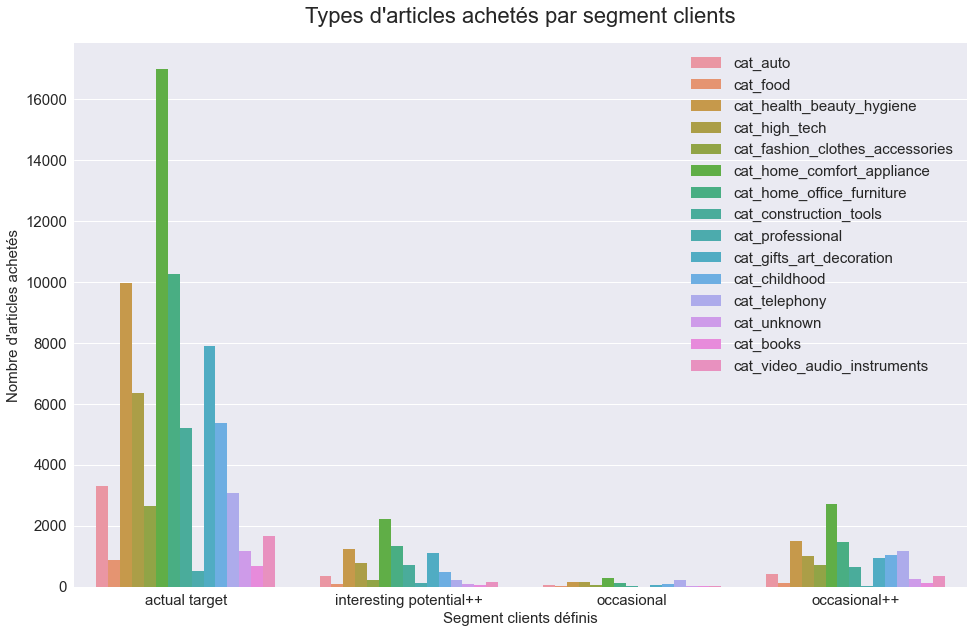

In [165]:
# Interesting_potential & occasional++ commandent des produits de catégories similaires (à part pour la téléphonie -> occasional++)
# Element intéressant pour le marketing pour récupérer ou fidéliser au mieux ces deux segments de clients en fonction de leur prédilection d'achats
plt.figure(figsize=(16, 10))
# option : à normaliser si l'on veut comparer des segments entre eux pour les catégories seulement
ax = sns.barplot(
    data=graph_gb_rfm_km_w_cat_prod,
    x='segment_label',
    y='item_count',
    hue='cat_name'
)

plt.title("Types d'articles achetés par segment clients", fontsize=22, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Segment clients définis", fontsize=15)
plt.ylabel("Nombre d'articles achetés", fontsize=15)
plt.legend(fontsize=15)

plt.show()

#### Comparaison entre le segmentation marketing (basée sur le RFM Score) et les labels des clusters obtenus par le KMeans

In [166]:
crosstab_seg_k_labels = pd.crosstab(df_rfm_km_w_cat_prod['k_label'], df_rfm_km_w_cat_prod['segment_label'])
display(crosstab_seg_k_labels)
# Ce qui me confirme que le choix de segmentation nommée en fonction du score RFM est bien représentatif de l'ensemble des clients.

segment_label  actual target  interesting potential++  occasional  \
k_label                                                             
0                      22677                     2485           0   
1                      21696                        0        1519   
2                      25933                     2698           0   
3                       1611                     1190           0   

segment_label  occasional++  
k_label                      
0                       248  
1                     12644  
2                       656  
3                         0

#### Comparaison entre la segmentation et la répartion géographique des clients

In [167]:
df_customers.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [168]:
df_rfm_km_w_cat_prod.head()

customer_unique_id  recency  frequency  monetary r_rank  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3   
2  0000f46a3911fa3c0805444483337064      537          1     86.22      1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2   

  f_rank m_rank rfm_segment  rfm_score  segment_label  sqrt_recency  \
0      1      3         413          8  actual target     10.583005   
1      1      1         311          5   occasional++     10.723805   
2      1      2         112          4   occasional++     23.173260   
3      1      1         211          4   occasional++     17.916473   
4      1      4         214          7  actual target     16.970563   

   log_monetary  std_recency  std_frequency  std_monetary  k_label  \
0      4.955123    -0.718219       -0.15983      0.291362        2   
1      3.302849    -0.692091       -0.15983     -1.732576        2   
2      4.456902     1.618178       -0.15983     -0.318928        1   
3      3.775516     0.642666       -0.15983     -1.153587        1   
4      5.282645     0.467132       -0.15983      0.692559        0   

   cat_actual target  cat_interesting potential++  cat_occasional  \
0                  1                            0               0   
1                  0                            0               0   
2                  0                            0               0   
3                  0                            0               0   
4                  1                            0               0   

   cat_occasional++  cat_auto  cat_books  cat_childhood  \
0                 0       0.0        0.0            0.0   
1                 1       0.0        0.0            0.0   
2                 1       0.0        0.0            0.0   
3                 1       0.0        0.0            0.0   
4                 0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  
0            0.0          0.0                          0.0  
1            0.0          0.0                          0.0  
2            0.0          0.0                          0.0  
3            1.0          0.0                          0.0  
4            1.0          0.0                          0.0

In [169]:
cols_geo = ['customer_city', 'customer_state', 'centroid_lat', 'centroid_lng'] + ['customer_unique_id']
df_rfm_km_w_cat_prod_geo = pd.merge(
    df_rfm_km_w_cat_prod,
    df_customers[cols_geo],
    on='customer_unique_id',
    how='left'
)

display(df_rfm_km_w_cat_prod_geo.head())

customer_unique_id  recency  frequency  monetary r_rank  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3   
2  0000f46a3911fa3c0805444483337064      537          1     86.22      1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2   

  f_rank m_rank rfm_segment  rfm_score  segment_label  sqrt_recency  \
0      1      3         413          8  actual target     10.583005   
1      1      1         311          5   occasional++     10.723805   
2      1      2         112          4   occasional++     23.173260   
3      1      1         211          4   occasional++     17.916473   
4      1      4         214          7  actual target     16.970563   

   log_monetary  std_recency  std_frequency  std_monetary  k_label  \
0      4.955123    -0.718219       -0.15983      0.291362        2   
1      3.302849    -0.692091       -0.15983     -1.732576        2   
2      4.456902     1.618178       -0.15983     -0.318928        1   
3      3.775516     0.642666       -0.15983     -1.153587        1   
4      5.282645     0.467132       -0.15983      0.692559        0   

   cat_actual target  cat_interesting potential++  cat_occasional  \
0                  1                            0               0   
1                  0                            0               0   
2                  0                            0               0   
3                  0                            0               0   
4                  1                            0               0   

   cat_occasional++  cat_auto  cat_books  cat_childhood  \
0                 0       0.0        0.0            0.0   
1                 1       0.0        0.0            0.0   
2                 1       0.0        0.0            0.0   
3                 1       0.0        0.0            0.0   
4                 0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments customer_city  \
0            0.0          0.0                          0.0       cajamar   
1            0.0          0.0                          0.0        osasco   
2            0.0          0.0                          0.0      sao jose   
3            1.0          0.0                          0.0         belem   
4            1.0          0.0                          0.0      sorocaba   

  customer_state  centroid_lat  centroid_lng  
0             SP    -23.340235    -46.830140  
1             SP    -23.559115    -46.787626  
2  

In [170]:
# caractérisation par états
gb_rfm_km_w_cat_prod_geo = df_rfm_km_w_cat_prod_geo.groupby('customer_state').agg({
    'cat_actual target' : 'sum',
    'cat_interesting potential++' : 'sum',
    'cat_occasional' : 'sum',
    'cat_occasional++' : 'sum',
})

display(gb_rfm_km_w_cat_prod_geo.T)

customer_state                 AC     AL     AM    AP      BA      CE      DF  \
cat_actual target            57.0  306.0  106.0  54.0  2452.0  1002.0  1570.0   
cat_interesting potential++   5.0   36.0   10.0   7.0   237.0    94.0   164.0   
cat_occasional                1.0    1.0    1.0   0.0    42.0    17.0    22.0   
cat_occasional++             13.0   44.0   23.0   5.0   427.0   144.0   262.0   

customer_state                   ES      GO     MA      MG     MS     MT  \
cat_actual target            1480.0  1466.0  571.0  8443.0  536.0  678.0   
cat_interesting potential++   124.0   142.0   48.0   783.0   46.0   64.0   
cat_occasional                 16.0    27.0   13.0   167.0    9.0   10.0   
cat_occasional++              307.0   259.0   66.0  1605.0   90.0  103.0   

customer_state                  PA     PB      PE     PI      PR      RJ  \
cat_actual target            714.0  413.0  1201.0  355.0  3616.0  9230.0   
cat_interesting potential++   75.0   48.0   138.0   43.0   350.0   816.0   
cat_occasional                13.0    3.0    22.0    4.0    84.0   168.0   
cat_occasional++             120.0   40.0   187.0   62.0   718.0  1699.0   

customer_state                  RN     RO    RR      RS      SC     SE  \
cat_actual target            366.0  174.0  27.0  3960.0  2644.0  259.0   
cat_interesting potential++   37.0   19.0   4.0   331.0   245.0   21.0   
cat_occasional                 5.0    5.0   2.0   109.0    62.0    6.0   
cat_occasional++              56.0   32.0   7.0   767.0   493.0   41.0   

customer_state                    SP     TO  
cat_actual target            30036.0  201.0  
cat_interesting potential++   2458.0   28.0  
cat_occasional                 708.0    2.0  
cat_occasional++              5942.0   36.0

In [171]:
graph_rfm_km_w_cat_prod_geo = pd.melt(
    gb_rfm_km_w_cat_prod_geo.T.reset_index(),
    id_vars='index', # vu que l'on reset_index -> correspond à segment_label
    var_name='customers_state',
    value_name='customers_count'
)

graph_rfm_km_w_cat_prod_geo.rename(columns={'index' : 'segment_label'}, inplace=True)
display(graph_rfm_km_w_cat_prod_geo.sort_values(by='segment_label').head())

segment_label customers_state  customers_count
0   cat_actual target              AC             57.0
48  cat_actual target              MT            678.0
36  cat_actual target              MA            571.0
52  cat_actual target              PA            714.0
56  cat_actual target              PB            413.0

In [172]:
def display_customers_geo_seg(segment_label_col):
    """
    Fonction qui permet d'afficher la répartition des clients par états en fonction de leur segment marketing.
    
    Args:
        segment_label_col (string): Nom du label client correspondant à la valeur de colonne du dataframe utilisé.
        
    Returns:
        plt.show (graphic): Pie chart avec les états où le nombre de clients est le plus important.
    """
    
    customers_actuel_target_cities = \
    graph_rfm_km_w_cat_prod_geo[graph_rfm_km_w_cat_prod_geo['segment_label'] == segment_label_col].sort_values(by='customers_count')
    display(customers_actuel_target_cities.nlargest(5, 'customers_count'))

    # permet de mettre en évidence les 5 états les plus importants via le pie chart (paramètre : explode)
    customers_actuel_target_cities['explode'] = 0
    customers_actuel_target_cities.loc[customers_actuel_target_cities['customers_count'].nlargest(2).index, 'explode'] = 0.1

    
    plt.figure(figsize=(8,8))
    plt.style.use('seaborn')

    labels=customers_actuel_target_cities['customers_count'].astype(int)
    explode = customers_actuel_target_cities['explode']
    states = customers_actuel_target_cities['customers_state']

    wedges, texts, autotexts = plt.pie(
        customers_actuel_target_cities['customers_count'],
        labels=labels, # chiffres
        autopct='%1.1f%%',
        textprops=dict(color="b"),
        shadow=True,
        startangle=90,
        explode=explode,
        #pctdistance=1.1, 
        #labeldistance=1.2,
        #textprops={'fontsize': 14}
    )

    # Permet de n'afficher que certaines parties (pas optimal à recoder à l'occasion)
    for idx in range(len(wedges)-1, -1, -1):
        if idx < len(wedges) - 5:
            wedges[idx].set_visible(False)
            texts[idx].set_visible(False)
            autotexts[idx].set_visible(False)

    legend = plt.legend(wedges[22:27], states[22:27], title="États", bbox_to_anchor=(1, 0.5), fontsize=15)
    legend.get_title().set_fontsize('15')
    
    plt.setp(autotexts, size=15, weight="bold")
    plt.setp(texts, fontsize=15) # taille des chiffres
    
    plt.axis('equal')
    plt.title(
        "États dans lesquels le nombre de clients est important pour le segment : {}".format(
            segment_label_col.replace('cat_', '')
        ),
        fontsize=18,
        pad=10
    )

    return plt.show()

segment_label customers_state  customers_count
100  cat_actual target              SP          30036.0
72   cat_actual target              RJ           9230.0
40   cat_actual target              MG           8443.0
88   cat_actual target              RS           3960.0
68   cat_actual target              PR           3616.0

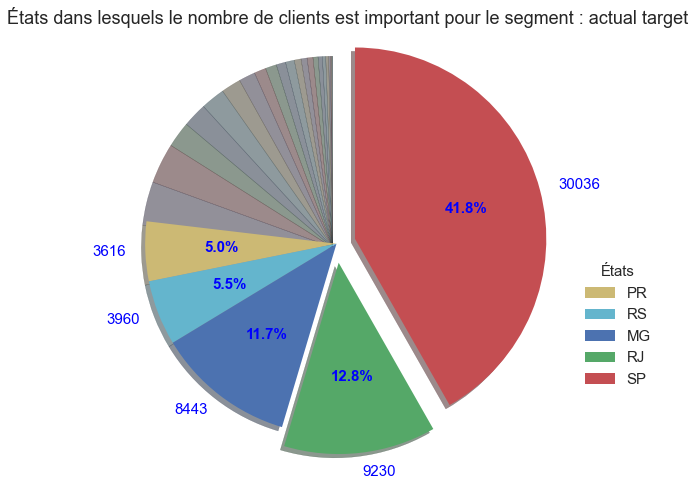

In [173]:
display_customers_geo_seg('cat_actual target')

segment_label customers_state  customers_count
102  cat_occasional              SP            708.0
74   cat_occasional              RJ            168.0
42   cat_occasional              MG            167.0
90   cat_occasional              RS            109.0
70   cat_occasional              PR             84.0

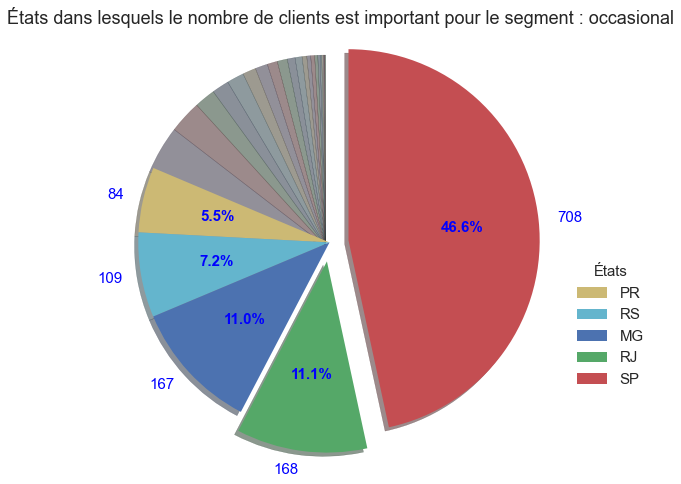

In [174]:
display_customers_geo_seg('cat_occasional')

segment_label customers_state  customers_count
103  cat_occasional++              SP           5942.0
75   cat_occasional++              RJ           1699.0
43   cat_occasional++              MG           1605.0
91   cat_occasional++              RS            767.0
71   cat_occasional++              PR            718.0

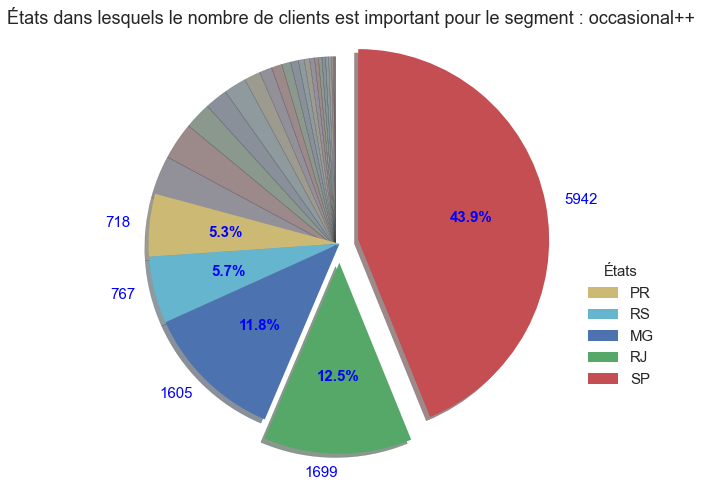

In [175]:
display_customers_geo_seg('cat_occasional++')

segment_label customers_state  customers_count
101  cat_interesting potential++              SP           2458.0
73   cat_interesting potential++              RJ            816.0
41   cat_interesting potential++              MG            783.0
69   cat_interesting potential++              PR            350.0
89   cat_interesting potential++              RS            331.0

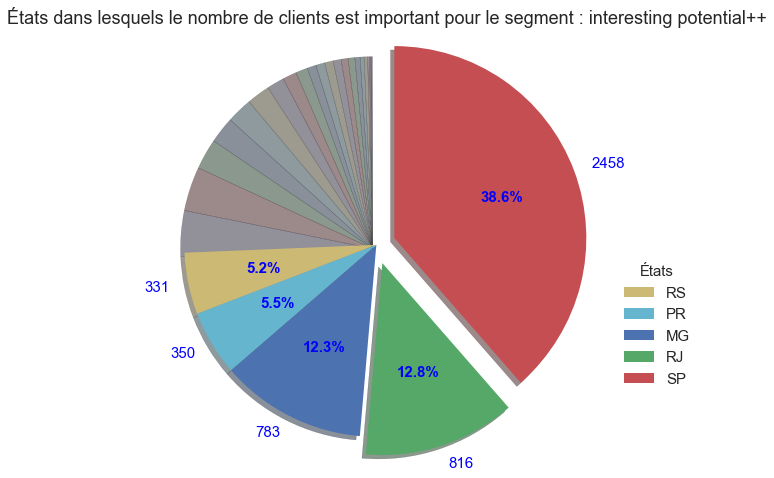

In [176]:
display_customers_geo_seg('cat_interesting potential++')

#### Comparaison des segments clients avec les moyens de paiement utilisés

In [177]:
cols_cat_payment = [col for col in df_customers.columns if col.startswith('payment_')]
cols_cat_payment.extend(['customer_unique_id'])
#print(cols_cat_payment)

df_rfm_km_w_cat_prod_geo_payment = pd.merge(
    df_rfm_km_w_cat_prod,
    df_customers[cols_cat_payment],
    on='customer_unique_id',
    how='left'
)

display(df_rfm_km_w_cat_prod_geo_payment.head())

customer_unique_id  recency  frequency  monetary r_rank  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3   
2  0000f46a3911fa3c0805444483337064      537          1     86.22      1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2   

  f_rank m_rank rfm_segment  rfm_score  segment_label  sqrt_recency  \
0      1      3         413          8  actual target     10.583005   
1      1      1         311          5   occasional++     10.723805   
2      1      2         112          4   occasional++     23.173260   
3      1      1         211          4   occasional++     17.916473   
4      1      4         214          7  actual target     16.970563   

   log_monetary  std_recency  std_frequency  std_monetary  k_label  \
0      4.955123    -0.718219       -0.15983      0.291362        2   
1      3.302849    -0.692091       -0.15983     -1.732576        2   
2      4.456902     1.618178       -0.15983     -0.318928        1   
3      3.775516     0.642666       -0.15983     -1.153587        1   
4      5.282645     0.467132       -0.15983      0.692559        0   

   cat_actual target  cat_interesting potential++  cat_occasional  \
0                  1                            0               0   
1                  0                            0               0   
2                  0                            0               0   
3                  0                            0               0   
4                  1                            0               0   

   cat_occasional++  cat_auto  cat_books  cat_childhood  \
0                 0       0.0        0.0            0.0   
1                 1       0.0        0.0            0.0   
2                 1       0.0        0.0            0.0   
3                 1       0.0        0.0            0.0   
4                 0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  \
0            0.0          0.0                          0.0   
1            0.0          0.0                          0.0   
2            0.0          0.0                          0.0   
3            1.0          0.0                          0.0   
4            1.0          0.0                          0.0   

   payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0 

In [178]:
gb_rfm_km_w_cat_prod_geo_payment = df_rfm_km_w_cat_prod_geo_payment.groupby('segment_label').agg({
    'payment_type_boleto' : 'sum',
    'payment_type_credit_card' : 'sum',
    'payment_type_debit_card' : 'sum',
    'payment_type_voucher' : 'sum'
})

display(gb_rfm_km_w_cat_prod_geo_payment)

payment_type_boleto  payment_type_credit_card  \
segment_label                                                            
actual target                        14362.0                   57421.0   
interesting potential++               1242.0                    6310.0   
occasional                             397.0                    1058.0   
occasional++                          3212.0                    9891.0   

                         payment_type_debit_card  payment_type_voucher  
segment_label                                                           
actual target                             1110.0                4056.0  
interesting potential++                    178.0                 329.0  
occasional                                  14.0                 124.0  
occasional++                               184.0                 992.0

In [179]:
graph_rfm_km_w_cat_prod_geo_payment = pd.melt(
    gb_rfm_km_w_cat_prod_geo_payment.reset_index(),
    id_vars='segment_label', # segment_label
    var_name='payment_type',
    value_name='nbr_time_used'
).sort_values(by='segment_label')

display(graph_rfm_km_w_cat_prod_geo_payment)

segment_label              payment_type  nbr_time_used
0             actual target       payment_type_boleto        14362.0
4             actual target  payment_type_credit_card        57421.0
8             actual target   payment_type_debit_card         1110.0
12            actual target      payment_type_voucher         4056.0
1   interesting potential++       payment_type_boleto         1242.0
5   interesting potential++  payment_type_credit_card         6310.0
9   interesting potential++   payment_type_debit_card          178.0
13  interesting potential++      payment_type_voucher          329.0
2                occasional       payment_type_boleto          397.0
6                occasional  payment_type_credit_card         1058.0
10               occasional   payment_type_debit_card           14.0
14               occasional      payment_type_voucher          124.0
3              occasional++       payment_type_boleto         3212.0
7              occasional++  payment_type_credit_card         9891.0
11             occasional++   payment_type_debit_card          184.0
15             occasional++      payment_type_voucher          992.0

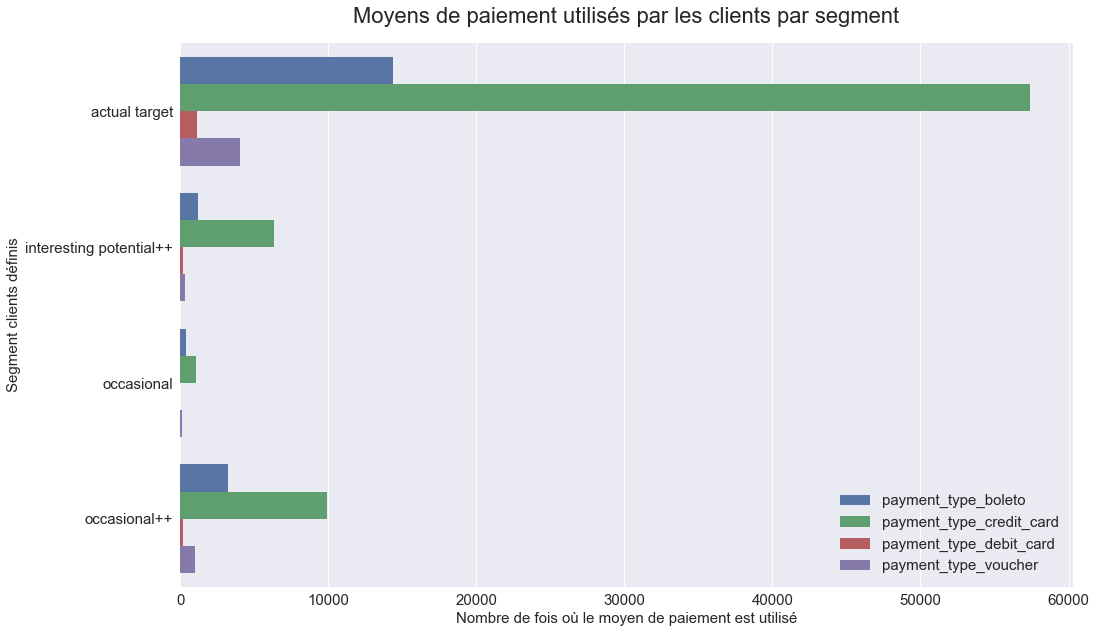

In [180]:
plt.figure(figsize=(16, 10))

ax = sns.barplot(
    data=graph_rfm_km_w_cat_prod_geo_payment,
    y='segment_label',
    x='nbr_time_used',
    hue='payment_type'
)

plt.title("Moyens de paiement utilisés par les clients par segment", fontsize=22, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Segment clients définis", fontsize=15)
plt.xlabel("Nombre de fois où le moyen de paiement est utilisé", fontsize=15)
plt.legend(fontsize=15)

plt.show()

### DBSCAN comparaison du nombre et type de clusters obtenus par rapport à KMeans/RFM
Rappels:<br />
- DBSCAN détermine le nombre de clusters optimal, pas besoin de le fixer à l'avance.
- KMeans fonctionne bien sur les formes de données convexes et peu concaves (à part avec un KMeans à kernel)
- DBSCAN est sensible (niveau résultats) s'il y a trop de variation de densité, outliers (permet de faire de la détection d'anomalies)<br />

Deux paramètres essentiels à définir pour DBSCAN:
- eps (Epsilon) : qui est la taille du rayon de voinnage autour d'un point p de nos données.
- min_samples : le minimum de points que doit contenir le voisionnage pour définir un cluster local.
- DBSCAN détermine trois types de points (core, border, outlier)<br />

Méthodes possibles de comparaison avec KMeans (métriques)<br />
- sklean.metrics.mutual_info_score
- sklean.metrics.homogeneity_score

#### Point sur la caractérisation des données avec les techniques précédentes.

In [181]:
df_customer_rfm_values.head()

recency  frequency  monetary r_rank f_rank  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90      4      1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19      3      1   
0000f46a3911fa3c0805444483337064      537          1     86.22      1      1   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62      2      1   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89      2      1   

                                 m_rank rfm_segment  rfm_score  segment_label  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      3         413          8  actual target   
0000b849f77a49e4a4ce2b2a4ca5be3f      1         311          5   occasional++   
0000f46a3911fa3c0805444483337064      2         112          4   occasional++   
0000f6ccb0745a6a4b88665a16c9f078      1         211          4   occasional++   
0004aac84e0df4da2b147fca70cf8255      4         214          7  actual target   

                                  sqrt_recency  log_monetary  std_recency  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2     10.583005      4.955123    -0.718219   
0000b849f77a49e4a4ce2b2a4ca5be3f     10.723805      3.302849    -0.692091   
0000f46a3911fa3c0805444483337064     23.173260      4.456902     1.618178   
0000f6ccb0745a6a4b88665a16c9f078     17.916473      3.775516     0.642666   
0004aac84e0df4da2b147fca70cf8255     16.970563      5.282645     0.467132   

                                  std_frequency  std_monetary  k_label  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2       -0.15983      0.291362        2   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.15983     -1.732576        2   
0000f46a3911fa3c0805444483337064       -0.15983     -0.318928        1   
0000f6ccb0745a6a4b88665a16c9f078       -0.15983     -1.153587        1   
0004aac84e0df4da2b147fca70cf8255       -0.15983      0.692559        0   

                                  cat_actual target  \
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                  0   
0000f46a3911fa3c0805444483337064                  0   
0000f6ccb0745a6a4b88665a16c9f078                  0   
0004aac84e0df4da2b147fca70cf8255                  1   

                                  cat_interesting potential++  cat_occasional  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                            0               0   
0000b849f77a49e4a4ce2b2a4ca5be3f                            0               0   
0000f46a3911fa3c0805444483337064                            0               0   
0000f6ccb0745a6a4b88665a16c9f078                            0               0   
0004aac84e0df4da2b147fca70cf8255                            0               0   

                                  cat_occasional++  
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2                 0  
0000b849f77a49e4a4ce2b2a4ca5be3f                 1  
0000f46a3911fa3c0805444483337064                 1  
0000f6ccb0745a6a4b88665a16c9f078                 1  
0004aac84e0df4da2b147fca70cf8255                 0

In [182]:
data_of_interest = df_customer_rfm_values[['std_recency', 'std_frequency', 'std_monetary', 'k_label', 'segment_label']]

In [183]:
le = LabelEncoder()
le.fit(data_of_interest['segment_label'].unique())
#print(le.classes_)

encoded_segment_label = le.transform(data_of_interest['segment_label'].values)
data_of_interest = data_of_interest.copy()
data_of_interest.loc[:, 'enc_segment_label'] = encoded_segment_label.tolist()
#display(data_of_interest['enc_segment_label'].head())

In [184]:
data_of_interest.head()

std_recency  std_frequency  std_monetary  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2    -0.718219       -0.15983      0.291362   
0000b849f77a49e4a4ce2b2a4ca5be3f    -0.692091       -0.15983     -1.732576   
0000f46a3911fa3c0805444483337064     1.618178       -0.15983     -0.318928   
0000f6ccb0745a6a4b88665a16c9f078     0.642666       -0.15983     -1.153587   
0004aac84e0df4da2b147fca70cf8255     0.467132       -0.15983      0.692559   

                                  k_label  segment_label  enc_segment_label  
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2        2  actual target                  0  
0000b849f77a49e4a4ce2b2a4ca5be3f        2   occasional++                  3  
0000f46a3911fa3c0805444483337064        1   occasional++                  3  
0000f6ccb0745a6a4b88665a16c9f078        1   occasional++                  3  
0004aac84e0df4da2b147fca70cf8255        0  actual target                  0

In [185]:
def display_3d_data(x, y, z, hue, title):
    """
    Fonction qui permet d'affichier des données suivant trois axes avec une variable coloration.
    
    Args:
        xs (pandas.Series): Coordonnées des données à représenter suivant cet axe.
        ys (pandas.Series): Coordonnées des données à représenter suivant cet axe.
        zs (pandas.Series): Coordonnées des données à représenter suivant cet axe.
        hue (pandas.Series): Données catégorielles numérisées permettant la coloration.
        title (string): Titre du graphique 3D.
    
    Returns:
        plt.show (graphic): Graphique en 3D des données.
    """
    
    fig = plt.figure(figsize=(8,8))
    plt.style.use("default")
    
    ax = fig.add_subplot(111, projection='3d')
    graph_3d = ax.scatter(
        xs=x,
        ys=y,
        zs=z,
        c=hue,
        alpha=0.5
    )
    
    title = str(title)
    ax.set_title(title, fontsize=18, pad=15)
    ax.set_xlabel(x.name, fontsize=15, labelpad=15)
    ax.set_ylabel(y.name, fontsize=15, labelpad=15)
    ax.set_zlabel(z.name, fontsize=15, labelpad=15)
    
    legend = ax.legend(*graph_3d.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend)

    return plt.show()

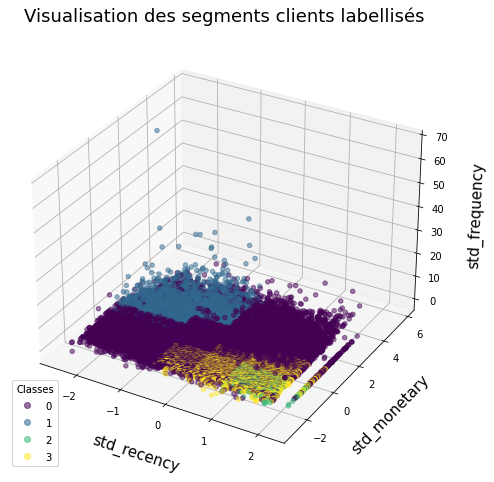

In [186]:
display_3d_data(
    x=data_of_interest['std_recency'],
    z=data_of_interest['std_frequency'],
    y=data_of_interest['std_monetary'],
    hue=data_of_interest['enc_segment_label'],
    title="Visualisation des segments clients labellisés"
)

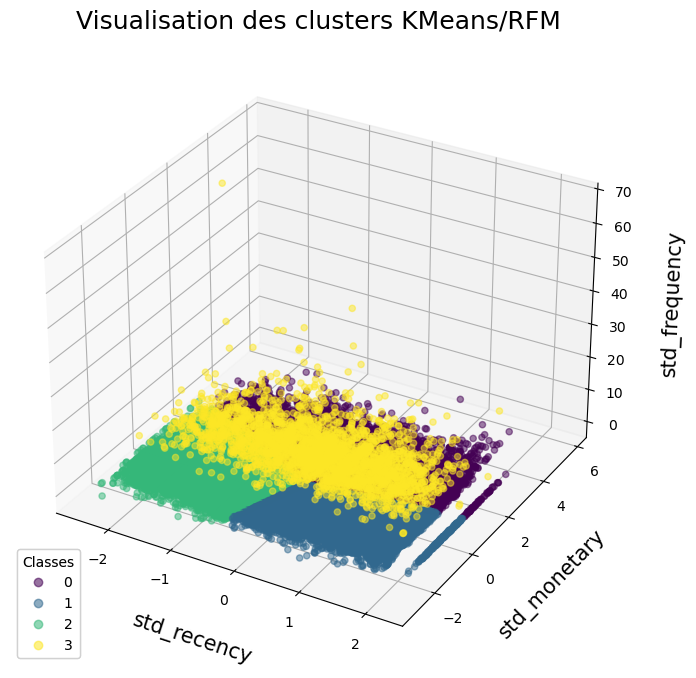

In [187]:
display_3d_data(
    x=data_of_interest['std_recency'],
    z=data_of_interest['std_frequency'],
    y=data_of_interest['std_monetary'],
    hue=data_of_interest['k_label'],
    title="Visualisation des clusters KMeans/RFM"
)

In [188]:
data_of_interest.head()

std_recency  std_frequency  std_monetary  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2    -0.718219       -0.15983      0.291362   
0000b849f77a49e4a4ce2b2a4ca5be3f    -0.692091       -0.15983     -1.732576   
0000f46a3911fa3c0805444483337064     1.618178       -0.15983     -0.318928   
0000f6ccb0745a6a4b88665a16c9f078     0.642666       -0.15983     -1.153587   
0004aac84e0df4da2b147fca70cf8255     0.467132       -0.15983      0.692559   

                                  k_label  segment_label  enc_segment_label  
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2        2  actual target                  0  
0000b849f77a49e4a4ce2b2a4ca5be3f        2   occasional++                  3  
0000f46a3911fa3c0805444483337064        1   occasional++                  3  
0000f6ccb0745a6a4b88665a16c9f078        1   occasional++                  3  
0004aac84e0df4da2b147fca70cf8255        0  actual target                  0

#### DBSCAN sur les données RFM normalisées pour comparaison

In [189]:
def display_dbscan_gs_results(df, epsilon, min_samples):
    """
    Fonction qui permet de déterminer les meilleurs paramètres pour DBSCAN.
    
    Args:
        df (DataFrame): Le dataframe à passer en argument pour obtenir les résultats de DBSCAN.
        eps (list): Liste des valeurs d'epsilon à tester.
        samples (list): Liste du nombre de voisins à tester.
        
    Returns:
        dbscan_results (dictionary): Un dictionnaire avec les résultats en fonction des paramètres testés.
    """
    #epsilon = [0.5, 0.75, 1]
    #min_samples = [20, 15, 10]
    #epsilon = [0.2, 0.4, 0.6]
    #min_samples = [10, 20, 30]
    dbscan_results = {}
    combinaison_nbr = 1

    for eps in epsilon:
        for neighbors in min_samples:
            dbscan_model = DBSCAN(eps=eps, min_samples=neighbors)
            dbscan_model.fit(df)
            # On reporte les résultats
            dbscan_results[combinaison_nbr] = {} # nested dictionary
            dbscan_results[combinaison_nbr]['eps'] = eps
            dbscan_results[combinaison_nbr]['min_samples'] = neighbors

            dbscan_labels = dbscan_model.labels_
            # Permet de sélectionner les données sélectionnées par DBSCAN en excluant les points considérés comme outliers s'il y a en a
            core_samples = np.zeros_like(dbscan_labels, dtype = bool) # On passe tout à False (même taille d'array qu'initialement)
            core_samples[dbscan_model.core_sample_indices_] = True # On passe seulement les points de l'index issus de DBSCAN à True
            
            # https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
            n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # retourne le nombre des clusters total sans les points classés en "bruit"
            n_noise_ = list(dbscan_labels).count(-1) # compte le nombre de points taggés -1

            dbscan_results[combinaison_nbr]['n_clusters'] = n_clusters_
            dbscan_results[combinaison_nbr]['n_noise'] = n_noise_
            
            # plus le rapport est élevé avec un un faible bruit, mieux c'est
            dbscan_results[combinaison_nbr]['custom_score'] = (neighbors / eps) / n_noise_

            combinaison_nbr += 1

    return dbscan_results

In [190]:
%%time
%%script false
dbscan_results = display_dbscan_gs_results(
    df=data_of_interest[['std_recency', 'std_frequency', 'std_monetary']],
    epsilon=[0.2, 0.4, 0.6],
    min_samples=[10, 20, 30]
)

Couldn't find program: 'false'
Wall time: 4.98 ms


In [191]:
%%script false
pickle.dump(dbscan_results, open("dbscan_results.pkl", "wb"))

Couldn't find program: 'false'


In [192]:
# Rechargement des résultats pour affichage et comparaison
dbscan_results_grid = pickle.load(open("dbscan_results.pkl", "rb"))
#display(dbscan_results_grid)

df_dbscan_results = pd.DataFrame.from_dict(dbscan_results_grid, orient='index')
df_dbscan_results.sort_values(by='custom_score', ascending=False)

eps  min_samples  n_clusters  n_noise  custom_score
8  0.6           20           3       97      0.343643
9  0.6           30           3      176      0.284091
7  0.6           10           3       68      0.245098
4  0.4           10           4      114      0.219298
6  0.4           30           2      345      0.217391
5  0.4           20           3      271      0.184502
2  0.2           20           6      835      0.119760
3  0.2           30           7     1434      0.104603
1  0.2           10           5      491      0.101833

In [193]:
%%time
dbscan_model = DBSCAN(eps=0.6, min_samples=20)
dbscan_model.fit(data_of_interest[['std_recency', 'std_frequency', 'std_monetary']])
dbscan_labels = dbscan_model.labels_
print(np.unique(dbscan_labels))
print(dbscan_labels.size)

core_samples = np.zeros_like(dbscan_labels, dtype = bool) 
core_samples[dbscan_model.core_sample_indices_] = True
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) 
n_noise_ = list(dbscan_labels).count(-1)

print('Nombre de clusters estimés: {}'.format(n_clusters_))
print('Nombre de points estimés comme outliers (noise): {}'.format(n_noise_))
print('Silhouette coefficient (avg): {:.3f}'\
      .format(silhouette_score(data_of_interest[['std_recency', 'std_frequency', 'std_monetary']], dbscan_labels)))

[-1  0  1  2]
93357
Nombre de clusters estimés: 3
Nombre de points estimés comme outliers (noise): 97
Silhouette coefficient (avg): 0.662
Wall time: 6min 41s


In [194]:
ps_dbscan_labels = pd.Series(dbscan_labels, name='dbscan_label')

In [195]:
ps_dbscan_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: dbscan_label, dtype: int64

In [196]:
data_of_interest_w_ds = pd.concat([data_of_interest.reset_index(), ps_dbscan_labels], axis=1)

In [197]:
data_of_interest_w_ds.head()

customer_unique_id  std_recency  std_frequency  std_monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2    -0.718219       -0.15983      0.291362   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    -0.692091       -0.15983     -1.732576   
2  0000f46a3911fa3c0805444483337064     1.618178       -0.15983     -0.318928   
3  0000f6ccb0745a6a4b88665a16c9f078     0.642666       -0.15983     -1.153587   
4  0004aac84e0df4da2b147fca70cf8255     0.467132       -0.15983      0.692559   

   k_label  segment_label  enc_segment_label  dbscan_label  
0        2  actual target                  0             0  
1        2   occasional++                  3             0  
2        1   occasional++                  3             0  
3        1   occasional++                  3             0  
4        0  actual target                  0             0

In [198]:
data_of_interest_w_ds[data_of_interest_w_ds['k_label'] == 3]

customer_unique_id  std_recency  std_frequency  \
104    004288347e5e88a27ded2bb23747066c     0.119947        4.62263   
243    00a39521eb40f7012db50455bf083460    -0.941309        4.62263   
305    00cc12a6d8b578b8ebd21ea4e2ae8b27     1.573906        4.62263   
404    011575986092c30523ecb71ff10cb473    -0.542008        4.62263   
419    011b4adcd54683b480c4d841250a987f    -0.084121        4.62263   
...                                 ...          ...            ...   
92990  ff03923ad1eb9e32304deb7f9b2a45c9    -0.863902        4.62263   
93084  ff44401d0d8f5b9c54a47374eb48c1b8     1.328115        4.62263   
93186  ff8892f7c26aa0446da53d01b18df463     0.400824        4.62263   
93204  ff922bdd6bafcdf99cb90d7f39cea5b3     0.789605        9.40509   
93313  ffe254cc039740e17dd15a5305035928     1.525078        4.62263   

       std_monetary  k_label            segment_label  enc_segment_label  \
104        1.412452        3            actual target                  0   
243        0.118759        3  interesting potential++                  1   
305        0.147732        3            actual target                  0   
404        0.799775        3  interesting potential++                  1   
419        0.916058        3  interesting potential++                  1   
...             ...      ...                      ...                ...   
92990      0.970603        3  interesting potential++                  1   
93084     -0.609723        3            actual target                  0   
93186      1.325696        3            actual target                  0   
93204      0.271345        3            actual target                  0   
93313     -0.408811        3            actual target                  0   

       dbscan_label  
104               1  
243               1  
305               1  
404               1  
419               1  
...             ...  
92990             1  
93084             1  
93186             1  
93204             2  
93313             1  

[2801 rows x 8 columns]

In [199]:
ct_km_vs_seg = pd.crosstab(data_of_interest_w_ds['k_label'], data_of_interest_w_ds['segment_label'])
display(ct_km_vs_seg)

segment_label  actual target  interesting potential++  occasional  \
k_label                                                             
0                      22677                     2485           0   
1                      21696                        0        1519   
2                      25933                     2698           0   
3                       1611                     1190           0   

segment_label  occasional++  
k_label                      
0                       248  
1                     12644  
2                       656  
3                         0

In [200]:
ct_seg_vs_db = pd.crosstab(data_of_interest_w_ds['dbscan_label'], data_of_interest_w_ds['segment_label'])
display(ct_seg_vs_db)

segment_label  actual target  interesting potential++  occasional  \
dbscan_label                                                        
-1                        34                       63           0   
 0                     70301                     5183        1519   
 1                      1506                     1058           0   
 2                        76                       69           0   

segment_label  occasional++  
dbscan_label                 
-1                        0  
 0                    13548  
 1                        0  
 2                        0

### Comparaison RFM/KMeans vs RFM/DBSCAN

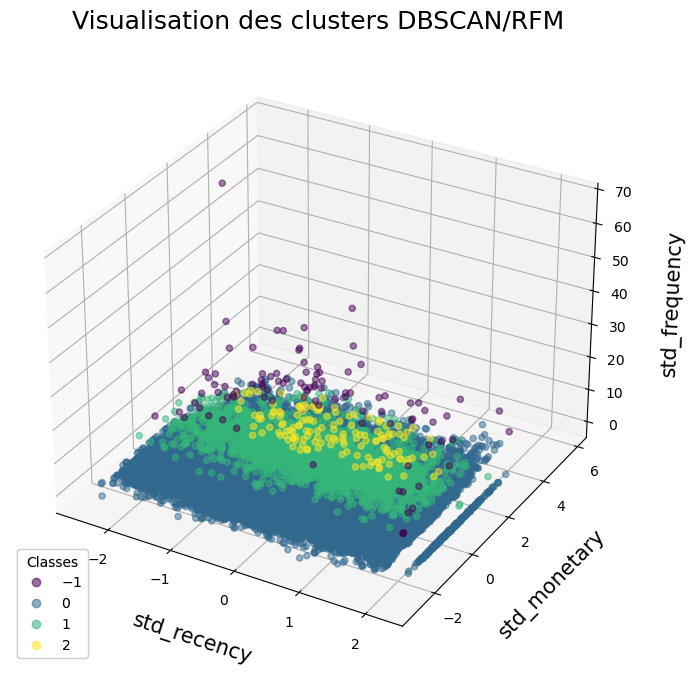

In [201]:
display_3d_data(
    x=data_of_interest_w_ds['std_recency'],
    z=data_of_interest_w_ds['std_frequency'],
    y=data_of_interest_w_ds['std_monetary'],
    hue=data_of_interest_w_ds['dbscan_label'],
    title="Visualisation des clusters DBSCAN/RFM"
)

In [202]:
df_melt_customer_rfm_dbscan_values = pd.melt(
    data_of_interest_w_ds[['customer_unique_id', 'dbscan_label', 'std_recency', 'std_frequency', 'std_monetary']], 
    id_vars=['customer_unique_id', 'dbscan_label'], # colonnes que l'on ne pivotent pas
    value_vars=['std_recency', 'std_frequency', 'std_monetary'], # variables "wide" to "long"
    var_name='rfm_metrics', value_name='rfm_value'
)

display(df_melt_customer_rfm_dbscan_values)

customer_unique_id  dbscan_label   rfm_metrics  \
0       0000366f3b9a7992bf8c76cfdf3221e2             0   std_recency   
1       0000b849f77a49e4a4ce2b2a4ca5be3f             0   std_recency   
2       0000f46a3911fa3c0805444483337064             0   std_recency   
3       0000f6ccb0745a6a4b88665a16c9f078             0   std_recency   
4       0004aac84e0df4da2b147fca70cf8255             0   std_recency   
...                                  ...           ...           ...   
280066  fffcf5a5ff07b0908bd4e2dbc735a684             0  std_monetary   
280067  fffea47cd6d3cc0a88bd621562a9d061             0  std_monetary   
280068  ffff371b4d645b6ecea244b27531430a             0  std_monetary   
280069  ffff5962728ec6157033ef9805bacc48             0  std_monetary   
280070  ffffd2657e2aad2907e67c3e9daecbeb             0  std_monetary   

        rfm_value  
0       -0.718219  
1       -0.692091  
2        1.618178  
3        0.642666  
4        0.467132  
...           ...  
280066   3.572900  
280067  -0.342453  
280068   0.006533  
280069   0.218357  
280070  -0.547216  

[280071 rows x 4 columns]

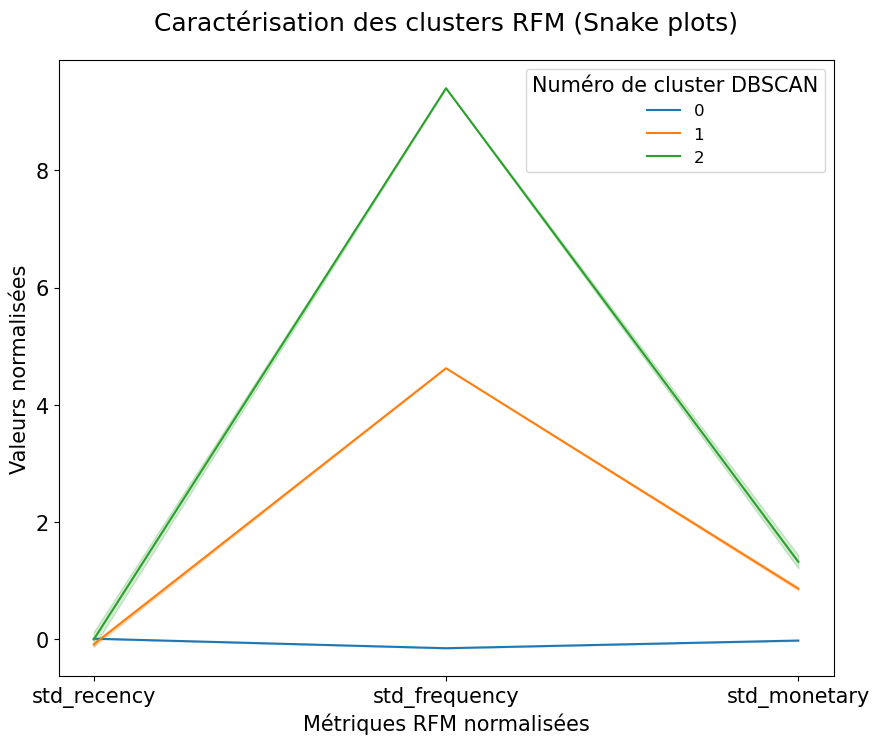

In [203]:
plt.figure(figsize=(10,8))

sns.lineplot(
    data=df_melt_customer_rfm_dbscan_values[df_melt_customer_rfm_dbscan_values['dbscan_label'] != -1],
    x='rfm_metrics',
    y='rfm_value',
    hue='dbscan_label',
    palette=sns.color_palette("tab10")[:3]
)

plt.title("Caractérisation des clusters RFM (Snake plots)", fontsize=18, pad=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Métriques RFM normalisées", fontsize=15)
plt.ylabel("Valeurs normalisées", fontsize=15)
legend = plt.legend(title="Numéro de cluster DBSCAN", prop={'size': 12})
legend.get_title().set_fontsize('15')

plt.show()

In [204]:
# Essai DBSCAN avec données complètes
df_2nd_kmeans_all_features_std.head()

customer_mean_order  max_items_type_ordered  max_number_payments_spread  \
0             0.481628               -0.186459                    1.474121   
1            -1.699552               -0.186459                   -0.967751   
2            -0.196389               -0.186459                    1.474121   
3            -1.314759               -0.186459                    0.970521   
4             0.817624               -0.186459                    1.290489   

   max_number_payments_type  max_sellers_ordered  mean_delivery_time  \
0                  -0.17908            -0.116328           -0.698158   
1                  -0.17908            -0.116328           -1.623555   
2                  -0.17908            -0.116328            1.430243   
3                  -0.17908            -0.116328            1.025504   
4                  -0.17908            -0.116328            0.364961   

   mean_perct_freight  mean_reviews_score  mean_time_between_order  \
0           -1.078956            0.781478                -0.151289   
1            0.827045           -0.401647                -0.151289   
2            0.121750           -1.202960                -0.151289   
3            1.384609           -0.401647                -0.151289   
4           -1.060488            0.781478                -0.151289   

   number_orders  number_reviews  order_status  product_density  \
0      -0.177453       -0.177453     -0.035337        -0.677539   
1      -0.177453       -0.177453     -0.035337         0.369419   
2      -0.177453       -0.177453     -0.035337         1.175338   
3      -0.177453       -0.177453     -0.035337        -0.346603   
4      -0.177453       -0.177453     -0.035337        -4.763415   

   product_photos_qty  total_payments_amount  total_products_ordered  \
0           -1.078191               0.369200               -0.376904   
1           -1.078191              -1.965208               -0.376904   
2            0.738093              -0.254325               -0.376904   
3            1.288142              -1.215781               -0.376904   
4            0.738093               0.746084               -0.376904   

   cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0 -0.186343   -0.08903       -0.25828               -0.208131   
1 -0.186343   -0.08903       -0.25828               -0.208131   
2 -0.186343   -0.08903       -0.25828               -0.208131   
3 -0.186343   -0.08903       -0.25828               -0.208131   
4 -0.186343   -0.08903       -0.25828               -0.208131   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                         -0.17769 -0.084801                 -0.311129   
1                         -0.17769 -0.084801                 -0.311129   
2                         -0.17769 -0.084801                 -0.311129   
3                         -0.17769 -0.084801                 -0.311129   
4                         -0.17769 -0.084801                 -0.311129   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                  -0.342224      -0.244159                    1.380912   
1                   2.145210      -0.244159                   -0.428075   
2                  -0.342224      -0.244159                   -0.428075   
3                  -0.342224      -0.244159                   -0.428075   
4                  -0.342224      -0.244159                   -0.428075   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                  -0.298287         -0.066832      -0.192498    -0.115005   
1                  -0.298287         -0.066832      -0.192498    -0.115005   
2                   1.814274         -0.066832      -0.192498    -0.115005   
3                  -0.298287         -0.066832       3.627031    -0.115005   
4                  -0.298287         -0.066832       3.627031    -0.115005   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0      

In [205]:
%%time
%%script false
dbscan_results = display_dbscan_gs_results(
    df=df_2nd_kmeans_all_features_std,
    epsilon=[0.2, 0.4, 0.6],
    min_samples=[10, 20, 30]
)

Couldn't find program: 'false'
Wall time: 404 ms


In [206]:
%%script false
pickle.dump(dbscan_results, open("dbscan_results_2.pkl", "wb"))

Couldn't find program: 'false'


In [207]:
# Rechargement des résultats pour affichage et comparaison
dbscan_results_grid_2 = pickle.load(open("dbscan_results_2.pkl", "rb"))
#display(dbscan_results_grid)

df_dbscan_results_2 = pd.DataFrame.from_dict(dbscan_results_grid_2, orient='index')
df_dbscan_results_2.sort_values(by='custom_score', ascending=False)
# Conclusion: DBSCAN sur les données complètes n'est pas concluant.

eps  min_samples  n_clusters  n_noise  custom_score
3  0.2           30           0    95420      0.001572
2  0.2           20           0    95420      0.001048
6  0.4           30           3    95136      0.000788
9  0.6           30          36    89750      0.000557
5  0.4           20          18    94511      0.000529
1  0.2           10           9    95280      0.000525
8  0.6           20          77    85494      0.000390
4  0.4           10         131    91061      0.000275
7  0.6           10         287    75355      0.000221

### 3ème K-Means avec données RFM normalisées + numériques + catégorielles sélectionnées

In [208]:
display(data_of_interest.head())
print(data_of_interest.shape)

std_recency  std_frequency  std_monetary  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2    -0.718219       -0.15983      0.291362   
0000b849f77a49e4a4ce2b2a4ca5be3f    -0.692091       -0.15983     -1.732576   
0000f46a3911fa3c0805444483337064     1.618178       -0.15983     -0.318928   
0000f6ccb0745a6a4b88665a16c9f078     0.642666       -0.15983     -1.153587   
0004aac84e0df4da2b147fca70cf8255     0.467132       -0.15983      0.692559   

                                  k_label  segment_label  enc_segment_label  
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2        2  actual target                  0  
0000b849f77a49e4a4ce2b2a4ca5be3f        2   occasional++                  3  
0000f46a3911fa3c0805444483337064        1   occasional++                  3  
0000f6ccb0745a6a4b88665a16c9f078        1   occasional++                  3  
0004aac84e0df4da2b147fca70cf8255        0  actual target                  0

(93357, 6)


In [209]:
display(df_customers.head())
print(df_customers.shape)

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

(95420, 43)


In [210]:
# On merge les deux sur customer_unique_id (méthode inner) avant séletion des colonnes
df_3rd_kmeans_init = pd.merge(df_customers, data_of_interest, on='customer_unique_id', how='inner')
print(df_3rd_kmeans_init.shape)

(93357, 49)


In [211]:
# Synthèse données normalisées RFM + sélection sur les normalisées numériques du 2nd K-Means
# Features selection -> manuel après les différents résultats obtenus (intuition d'améloriation)
col_3rd_km = [
    # variables RFM normalisées
    'std_recency',
    'std_frequency',
    'std_monetary',
    # variables complémentaires
    'mean_delivery_time',
    'mean_perct_freight',
    'number_reviews',
    'mean_reviews_score',
    'product_density',
    'product_photos_qty',
    # variables de catégories
    'cat_auto',
    'cat_books',
    'cat_childhood',
    'cat_construction_tools',
    'cat_fashion_clothes_accessories',
    'cat_food',
    'cat_gifts_art_decoration',
    'cat_health_beauty_hygiene',
    'cat_high_tech',
    'cat_home_comfort_appliance',
    'cat_home_office_furniture',
    'cat_professional',
    'cat_telephony',
    'cat_unknown',
    'cat_video_audio_instruments',
    'payment_type_boleto',
    'payment_type_credit_card',
    'payment_type_debit_card',
    'payment_type_voucher' 
]

In [212]:
df_3rd_kmeans = df_3rd_kmeans_init[col_3rd_km]
print(df_3rd_kmeans.shape)

(93357, 28)


In [213]:
df_3rd_kmeans.head()

std_recency  std_frequency  std_monetary  mean_delivery_time  \
0    -0.718219       -0.15983      0.291362            6.411227   
1    -0.692091       -0.15983     -1.732576            3.285590   
2     1.618178       -0.15983     -0.318928           25.731759   
3     0.642666       -0.15983     -1.153587           20.037083   
4     0.467132       -0.15983      0.692559           13.141134   

   mean_perct_freight  number_reviews  mean_reviews_score  product_density  \
0            9.237875               1                 5.0         5.077333   
1           43.862434               1                 4.0        13.728000   
2           24.956522               1                 3.0        29.166667   
3           67.833782               1                 4.0         6.966667   
4            9.383333               1                 5.0         0.087273   

   product_photos_qty  cat_auto  cat_books  cat_childhood  \
0                 1.0       0.0        0.0            0.0   
1                 1.0       0.0        0.0            0.0   
2                 3.0       0.0        0.0            0.0   
3                 5.0       0.0        0.0            0.0   
4                 3.0       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  \
0            0.0          0.0                          0.0   
1            0.0          0.0                          0.0   
2            0.0          0.0                          0.0   
3            1.0          0.0                          0.0   
4            1.0          0.0                          0.0   

   payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0   
2                  0.0                       1.0                      0.0   
3                  0.0                       1.0                      0.0   
4                  0.0                       1.0                      0.0   

   payment_type_voucher  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [214]:
df_3rd_kmeans.agg(['mean', 'median', 'std', 'min']).round(2)

std_recency  std_frequency  std_monetary  mean_delivery_time  \
mean           0.00           0.00          0.00               12.57   
median         0.06          -0.16         -0.05               10.23   
std            1.00           1.00          1.00                9.54   
min           -2.50          -0.16         -3.01                0.53   

        mean_perct_freight  number_reviews  mean_reviews_score  \
mean                 30.90            1.03                4.14   
median               22.63            1.00                5.00   
std                  30.93            0.21                1.29   
min                   0.43            1.00                1.00   

        product_density  product_photos_qty  cat_auto  cat_books  \
mean              15.44                2.61      0.04       0.01   
median             9.76                2.00      0.00       0.00   
std               35.61                2.35      0.24       0.10   
min                0.01                1.00      0.00       0.00   

        cat_childhood  cat_construction_tools  \
mean             0.08                    0.07   
median           0.00                    0.00   
std              0.29                    0.34   
min              0.00                    0.00   

        cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
mean                               0.04      0.01                      0.11   
median                             0.00      0.00                      0.00   
std                                0.22      0.14                      0.35   
min                                0.00      0.00                      0.00   

        cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
mean                         0.14           0.09                        0.24   
median                       0.00           0.00                        0.00   
std                          0.40           0.37                        0.55   
min                          0.00           0.00                        0.00   

        cat_home_office_furniture  cat_professional  cat_telephony  \
mean                         0.14              0.01           0.05   
median                       0.00              0.00           0.00   
std                          0.47              0.11           0.26   
min                          0.00              0.00           0.00   

        cat_unknown  cat_video_audio_instruments  payment_type_boleto  \
mean           0.02                         0.02                 0.21   
median         0.00                         0.00                 0.00   
std            0.15                         0.16                 0.42   
min            0.00                         0.00                 0.00   

        payment_type_credit_card  payment_type_debit_card  \
mean                        0.80                     0.02   
median                      1.00                     0.00   
std                         0.48                     0.13   
min                         0.00                     0.00   

        payment_type_voucher  
mean                    0.06  
median                  0.00  
std                     0.43  
min                     0.00

In [215]:
km3_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
df_3rd_kmeans_std = km3_scaler.fit_transform(df_3rd_kmeans)
df_3rd_kmeans_std = pd.DataFrame(
    data = df_3rd_kmeans_std,
    index = df_3rd_kmeans.index,
    columns = df_3rd_kmeans.columns
)

df_3rd_kmeans_std.agg(['mean', 'median', 'std', 'min']).round(2)

std_recency  std_frequency  std_monetary  mean_delivery_time  \
mean           0.00           0.00         -0.00                0.00   
median         0.06          -0.16         -0.05               -0.24   
std            1.00           1.00          1.00                1.00   
min           -2.50          -0.16         -3.01               -1.26   

        mean_perct_freight  number_reviews  mean_reviews_score  \
mean                 -0.00           -0.00                0.00   
median               -0.27           -0.16                0.67   
std                   1.00            1.00                1.00   
min                  -0.99           -0.16               -2.43   

        product_density  product_photos_qty  cat_auto  cat_books  \
mean               0.00                0.00      0.00      -0.00   
median            -0.16               -0.26     -0.19      -0.09   
std                1.00                1.00      1.00       1.00   
min               -0.43               -0.68     -0.19      -0.09   

        cat_childhood  cat_construction_tools  \
mean            -0.00                    0.00   
median          -0.26                   -0.21   
std              1.00                    1.00   
min             -0.26                   -0.21   

        cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
mean                              -0.00      0.00                      0.00   
median                            -0.18     -0.09                     -0.31   
std                                1.00      1.00                      1.00   
min                               -0.18     -0.09                     -0.31   

        cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
mean                         0.00           0.00                        0.00   
median                      -0.34          -0.24                       -0.43   
std                          1.00           1.00                        1.00   
min                         -0.34          -0.24                       -0.43   

        cat_home_office_furniture  cat_professional  cat_telephony  \
mean                         -0.0              0.00          -0.00   
median                       -0.3             -0.07          -0.19   
std                           1.0              1.00           1.00   
min                          -0.3             -0.07          -0.19   

        cat_unknown  cat_video_audio_instruments  payment_type_boleto  \
mean          -0.00                         0.00                 0.00   
median        -0.11                        -0.14                -0.49   
std            1.00                         1.00                 1.00   
min           -0.11                        -0.14                -0.49   

        payment_type_credit_card  payment_type_debit_card  \
mean                        0.00                     0.00   
median                      0.42                    -0.13   
std                         1.00                     1.00   
min                        -1.68                    -0.13   

        payment_type_voucher  
mean                    0.00  
median                 -0.14  
std                     1.00  
min                    -0.14

In [216]:
%%time
%%script false
# Faire varier le nombre de variables impliquées si les résultats ne sont pas concluants
clusters_range = range(2, 16)
# On récupère les données des métriques en fonctions de l'évolution du nombre de clusters impliqués
inertia_silhouette_idx_db_3 = cal_metrics_w_clusters_nbr(df_3rd_kmeans_std, k_range=clusters_range)

Couldn't find program: 'false'
Wall time: 6 ms


In [217]:
%%script false
# On sauvegarde les résultats pour éviter de refaire les calculs qui sont identiques.
pickle.dump(inertia_silhouette_idx_db_3, open("inertia_silhouette_idx_db_3.pkl", "wb"))

Couldn't find program: 'false'


In [218]:
# On recharge les résultats à partir du fichier pickle
inertia_silhouette_idx_db_3 = pickle.load(open("inertia_silhouette_idx_db_3.pkl", "rb"))

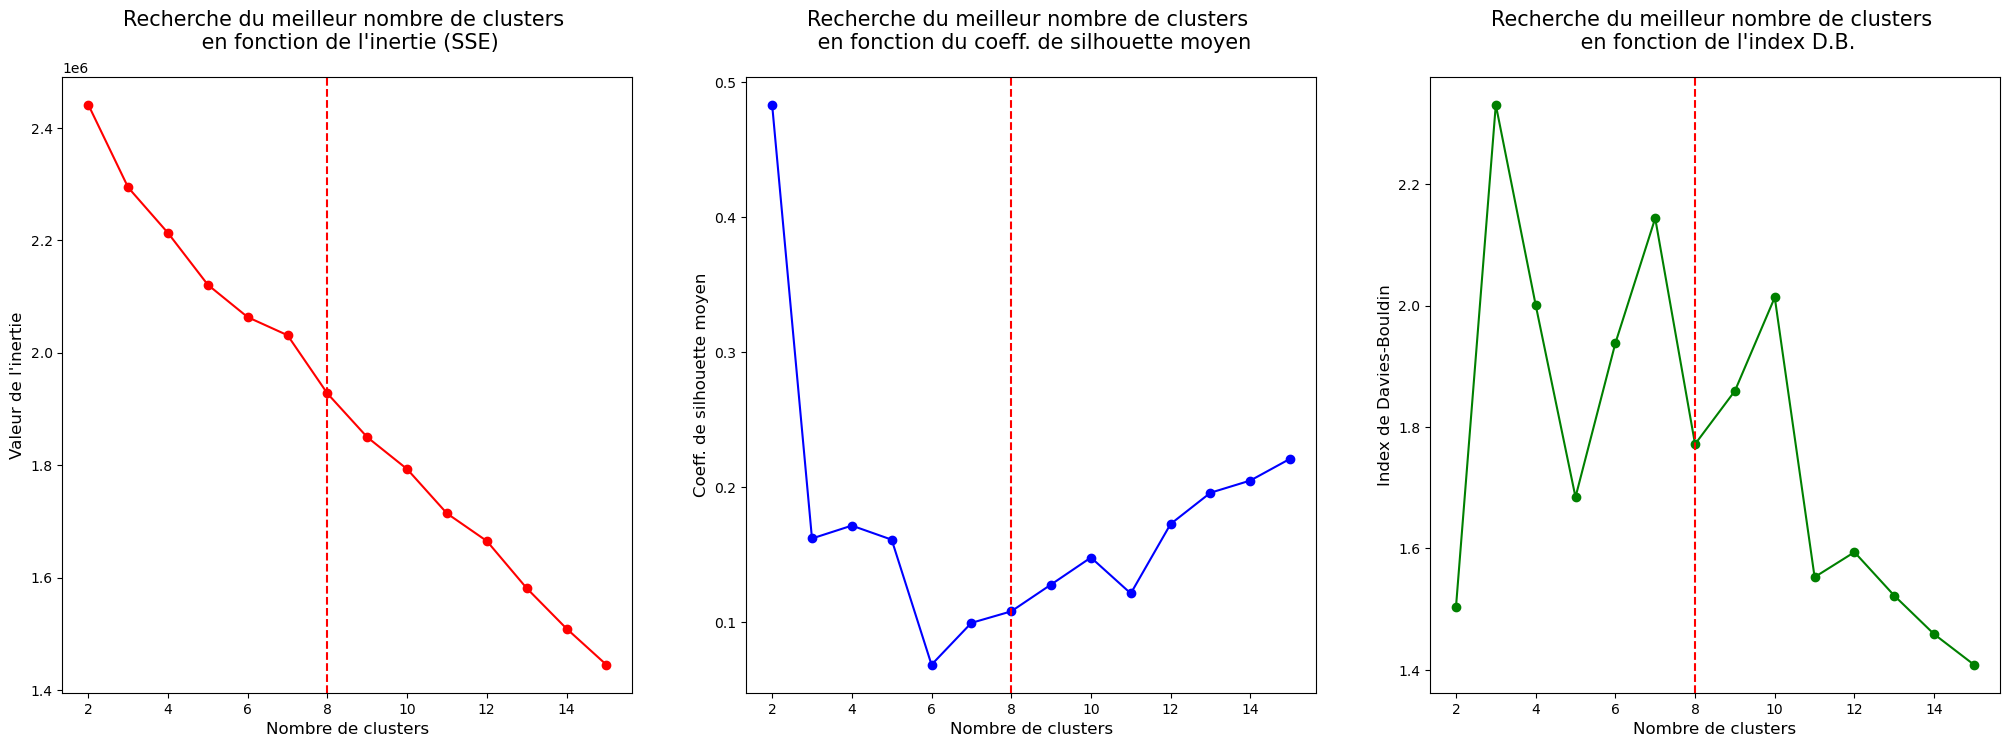

In [219]:
find_best_clusters_nbr(inertia_silhouette_idx_db_3, k_range=range(2, 16), x_lines=[8, 8, 8])

In [220]:
# On reéssaie avec moins de variables pour voir si on peut avoir une amélioration (22 variables)
df_3rd_kmeans_std_v2 = df_3rd_kmeans_std[df_3rd_kmeans_std.columns.difference([
    'mean_delivery_time',
    'mean_perct_freight',
    'number_reviews',
    'mean_reviews_score',
    'product_density',
    'product_photos_qty'    
])]

display(df_3rd_kmeans_std_v2.head())
print(df_3rd_kmeans_std_v2.shape)

cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0 -0.186355  -0.088646      -0.258083               -0.208498   
1 -0.186355  -0.088646      -0.258083               -0.208498   
2 -0.186355  -0.088646      -0.258083               -0.208498   
3 -0.186355  -0.088646      -0.258083               -0.208498   
4 -0.186355  -0.088646      -0.258083               -0.208498   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                         -0.17749 -0.085071                 -0.311159   
1                         -0.17749 -0.085071                 -0.311159   
2                         -0.17749 -0.085071                 -0.311159   
3                         -0.17749 -0.085071                 -0.311159   
4                         -0.17749 -0.085071                 -0.311159   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                  -0.342167      -0.243928                    1.374727   
1                   2.142758      -0.243928                   -0.428693   
2                  -0.342167      -0.243928                   -0.428693   
3                  -0.342167      -0.243928                   -0.428693   
4                  -0.342167      -0.243928                   -0.428693   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                  -0.298459         -0.066943      -0.192078    -0.113839   
1                  -0.298459         -0.066943      -0.192078    -0.113839   
2                   1.809838         -0.066943      -0.192078    -0.113839   
3                  -0.298459         -0.066943       3.632156    -0.113839   
4                  -0.298459         -0.066943       3.632156    -0.113839   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0                    -0.144379            -0.491516                  0.420951   
1                    -0.144379            -0.491516                  0.420951   
2                    -0.144379            -0.491516                  0.420951   
3                    -0.144379            -0.491516                  0.420951   
4                    -0.144379            -0.491516                  0.420951   

   payment_type_debit_card  payment_type_voucher  std_frequency  std_monetary  \
0                -0.125811              -0.13597       -0.15983      0.291362   
1                -0.125811              -0.13597       -0.15983     -1.732576   
2                -0.125811              -0.13597       -0.15983     -0.318928   
3                -0.125811              -0.13597       -0.15983     -1.153587   
4                -0.125811              -0.13597       -0.15983      0.692559   

   std_recency  
0    -0.718219  
1    -0.692091  
2     1.618178  
3     0.642666  
4     0.467132

(93357, 22)


In [221]:
%%time
%%script false
# Faire varier le nombre de variables impliquées si les résultats ne sont pas concluants
clusters_range = range(2, 16)
# On récupère les données des métriques en fonctions de l'évolution du nombre de clusters impliqués
inertia_silhouette_idx_db_4 = cal_metrics_w_clusters_nbr(df_3rd_kmeans_std_v2, k_range=clusters_range)

Couldn't find program: 'false'
Wall time: 5.99 ms


In [222]:
%%script false
# On sauvegarde les résultats pour éviter de refaire les calculs qui sont identiques.
pickle.dump(inertia_silhouette_idx_db_4, open("inertia_silhouette_idx_db_4.pkl", "wb"))

Couldn't find program: 'false'


In [223]:
# On recharge les résultats à partir du fichier pickle
inertia_silhouette_idx_db_4 = pickle.load(open("inertia_silhouette_idx_db_4.pkl", "rb"))

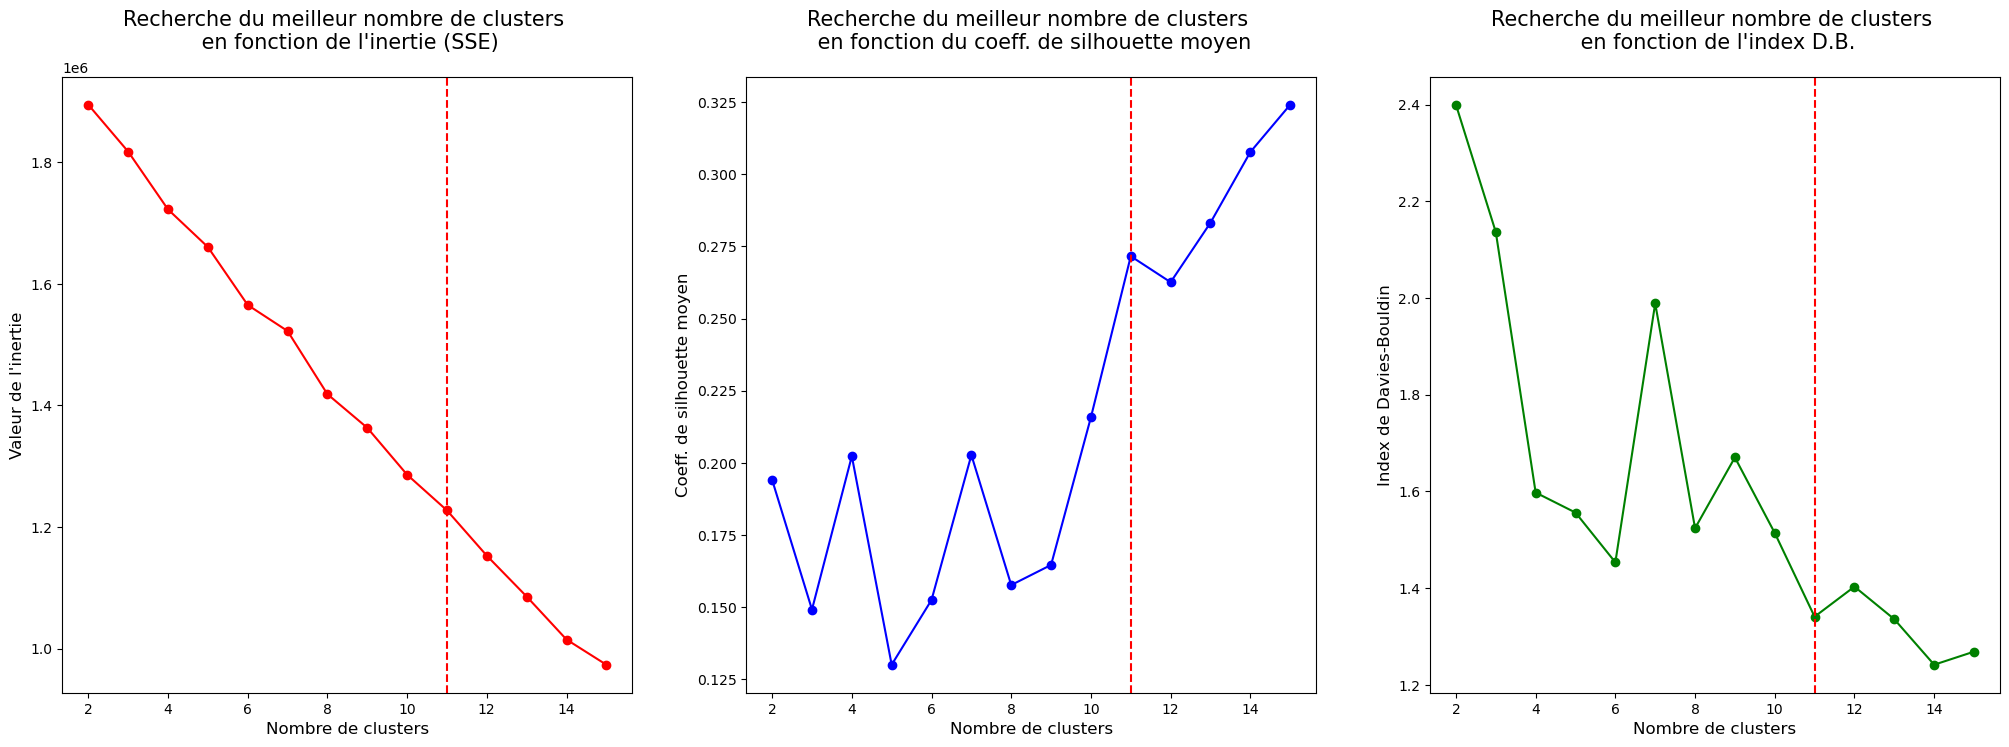

In [224]:
find_best_clusters_nbr(inertia_silhouette_idx_db_4, k_range=range(2, 16), x_lines=[11, 11, 11])

#### Comparaison des résultats des méthodes avec K-Means

In [225]:
# comparaison entre les trois méthodes à 15 clusters max. (ici 12 et les autres 14)
print("SSE v1:", inertia_silhouette_idx_db_1[0][-1]) # 12 clusters ici.
print("SSE v2:", inertia_silhouette_idx_db_2[0][-1])
print("SSE v3:", inertia_silhouette_idx_db_3[0][-1])
print("SSE v4:", inertia_silhouette_idx_db_4[0][-1], "\n")

print("Coef. silhouette (avg) v1:", inertia_silhouette_idx_db_1[1][-1])
print("Coef. silhouette (avg) v2:", inertia_silhouette_idx_db_2[1][-1])
print("Coef. silhouette (avg) v3:", inertia_silhouette_idx_db_3[1][-1])
print("Coef. silhouette (avg) v4", inertia_silhouette_idx_db_4[1][-1], "\n")

print("Indice D.B. v1:", inertia_silhouette_idx_db_1[2][-1])
print("Indice D.B. v2:", inertia_silhouette_idx_db_2[2][-1])
print("Indice D.B. v3:", inertia_silhouette_idx_db_3[2][-1])
print("Indice D.B. v4", inertia_silhouette_idx_db_4[2][-1])

SSE v1: 488473.59608701075
SSE v2: 1830773.5273070568
SSE v3: 1444971.7064221047
SSE v4: 973379.3793354544 

Coef. silhouette (avg) v1: 0.1825690067251885
Coef. silhouette (avg) v2: 0.14469913160230666
Coef. silhouette (avg) v3: 0.2209864972528391
Coef. silhouette (avg) v4 0.32415795279537835 

Indice D.B. v1: 1.1949244280956244
Indice D.B. v2: 1.6083607005723057
Indice D.B. v3: 1.408433670495033
Indice D.B. v4 1.2687835872766497


In [226]:
# Est-ce que ma segmentation (v2) est aussi intéressante que ma v4 avec variables RFM ?
# Le tout à 12 clusters pour les comparer deux à deux ?
print("SSE v2:", inertia_silhouette_idx_db_2[0][10])
print("SSE v4:", inertia_silhouette_idx_db_4[0][10])
print("SSE v4 à 14 clusters:", inertia_silhouette_idx_db_4[0][-2], "\n")

print("Coef. silhouette (avg) v2:", inertia_silhouette_idx_db_2[1][10])
print("Coef. silhouette (avg) v4", inertia_silhouette_idx_db_4[1][10])
print("Coef. silhouette (avg) v4 à 14 clusters", inertia_silhouette_idx_db_4[1][-2], "\n")

print("Indice D.B. v2:", inertia_silhouette_idx_db_2[2][10])
print("Indice D.B. v4", inertia_silhouette_idx_db_4[2][10])
print("Indice D.B. v4 à 14 clusters", inertia_silhouette_idx_db_4[2][-2])

SSE v2: 2034921.008850878
SSE v4: 1152778.3708744124
SSE v4 à 14 clusters: 1014823.8872500154 

Coef. silhouette (avg) v2: 0.11518973074510294
Coef. silhouette (avg) v4 0.26261566643294726
Coef. silhouette (avg) v4 à 14 clusters 0.3077419061228306 

Indice D.B. v2: 1.5518027984726281
Indice D.B. v4 1.4031986636949485
Indice D.B. v4 à 14 clusters 1.241760348365552


#### Recalcul à 14 clusters pour vérifier si la caractérisation est possible ou non
Remarque : le nombre de catégories initial doit avoir une forte influence sur la clusterisation (à confirmer) avec la caractérisation des clusters.<br />
Un cluster = une catégorie produits typique ? (à confirmer ensuite)

In [227]:
%%time
km_model = KMeans(init = 'k-means++', n_clusters = 14, random_state = 42)
km_labels = km_model.fit_predict(df_3rd_kmeans_std_v2) 

silhouette_avg = silhouette_score(df_3rd_kmeans_std_v2, km_labels)
print("silhouette_avg :", silhouette_avg)

sample_silhouette_values = silhouette_samples(df_3rd_kmeans_std_v2, km_labels)

davies_bouldin_index = davies_bouldin_score(df_3rd_kmeans_std_v2, km_labels)
print("Davies-Bouldin index : ", davies_bouldin_index)

df_customers_km_v4 = df_3rd_kmeans_init.copy().assign(k_label = km_labels)

silhouette_avg : 0.3077419061228306
Davies-Bouldin index :  1.241760348365552
Wall time: 6min 56s


In [228]:
df_customers_km_v4.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [229]:
# Répartition des clusters calculés par rapport aux segments clients nommés
# Mise en évidence de la nécessité de caractérisation différente (KMeans vs RFM Segments)
ct_seg_k_labels = pd.crosstab(df_customers_km_v4['k_label'], df_customers_km_v4['segment_label'])
display(ct_seg_k_labels)

segment_label  actual target  interesting potential++  occasional  \
k_label                                                             
0                      17499                     1386         321   
1                       8001                      533         200   
2                       2329                      162          64   
3                       7282                      776         112   
4                       5164                      459         157   
5                       7265                      855          75   
6                       2937                      293          58   
7                       2697                      142         210   
8                       4863                      391          95   
9                       1522                      119          38   
10                      1088                      169          14   
11                      1017                       54          37   
12                      9609                     1003         127   
13                       644                       31          11   

segment_label  occasional++  
k_label                      
0                      3268  
1                      1781  
2                       659  
3                      1098  
4                       952  
5                       893  
6                       400  
7                      1099  
8                      1003  
9                       352  
10                      183  
11                      247  
12                     1505  
13                      108

In [230]:
 agg_functions = {
     'std_recency' : 'mean',
     'std_frequency' : 'mean',
     'std_monetary' : 'mean',
     'customer_city' : lambda x: x.value_counts().index[0], # retourne le 'mode' avec l'astuce du 'count'
     'customer_state' : lambda x: x.value_counts().index[0], 
     'segment_label' : lambda x: x.value_counts().index[0],
     'number_orders' : ['mean', 'median'],
     'mean_delivery_time' : ['mean', 'median'], # intéressant par cluster
     'number_reviews' : ['mean', 'median'], # clients d'un cluster commentent plus qu'un autre ?
     'mean_reviews_score' :  ['mean', 'median'], # clients d'un cluster sont globalement plus satisfait qu'un autre ?
     'max_number_payments_type' : ['mean', 'median'], # en moyenne le nombre de moyens de paiement employés par les clients 
     'max_number_payments_spread' : ['mean', 'median'], # les clients payent de manière étalée ? (facilité de paiement en plusieurs fois ?)
     'total_payments_amount' : ['mean', 'median'], # combien les clients dépesent en moyenne au total ?
     'payment_type_boleto' : ['mean', 'median'], # type de paiement priviligié ?
     'payment_type_credit_card' : ['mean', 'median'], # type de paiement priviligié ?
     'payment_type_debit_card' : ['mean', 'median'], # type de paiement priviligié ?
     'payment_type_voucher' : ['mean', 'median'], # type de paiement priviligié ?
     'total_products_ordered' : ['mean', 'median'], # en moyenne combien les clients d'un cluster commandent de produits au total ? (différents ou non)
     'max_items_type_ordered' : ['mean', 'median'], # en moyenne combien de produits différents commandent les clients ?
     'max_sellers_ordered' : ['mean', 'median'], # les clients achètent leurs produits au même vendeur ? ou à plusieurs ?
     'product_photos_qty' : ['mean', 'median'], # nombre de photos sur l'ensemble (permet de savoir/estimer l'importance des visuels)
     'product_density' : ['mean', 'median'], # En moyenne, est-ce que les clients commandent des produits volumineux ou non ? (armoire vs smarphone ?)
     'cat_auto' : ['mean', 'median'], # (mean) permet d'estimer l'importance d'une catégorie produit par rapport à une autre dans un même cluster
     'cat_books' : ['mean', 'median'],
     'cat_childhood' : ['mean', 'median'],
     'cat_construction_tools' : ['mean', 'median'],
     'cat_fashion_clothes_accessories' : ['mean', 'median'],
     'cat_food' : ['mean', 'median'],
     'cat_gifts_art_decoration' : ['mean', 'median'],
     'cat_health_beauty_hygiene' : ['mean', 'median'],
     'cat_high_tech' : ['mean', 'median'],
     'cat_home_comfort_appliance' : ['mean', 'median'],
     'cat_home_office_furniture' : ['mean', 'median'],
     'cat_professional' : ['mean', 'median'],
     'cat_telephony' : ['mean', 'median'],
     'cat_unknown' : ['mean', 'median'],
     'cat_video_audio_instruments' : ['mean', 'median'] ,
     'mean_time_between_order' : ['mean', 'median'], # temps moyen entre plusieurs commandes (clients réguliers, fidèles ?)
     'mean_perct_freight' : ['mean', 'median'], # part du coùt du transport moyen dans les commandes d'un même cluster
     'customer_mean_order' : ['mean', 'median'] # dépense moyenne d'un client au sein du même cluster
    }
    
display(df_customers_km_v4[df_customers_km_v4['k_label'] == 12].agg(agg_functions).round(2).T)

mean       <lambda>  median
std_recency                        0.01            NaN     NaN
std_frequency                       0.0            NaN     NaN
std_monetary                       0.19            NaN     NaN
customer_city                       NaN      sao paulo     NaN
customer_state                      NaN             SP     NaN
segment_label                       NaN  actual target     NaN
number_orders                      1.03            NaN     1.0
mean_delivery_time                13.33            NaN   10.97
number_reviews                     1.03            NaN     1.0
mean_reviews_score                 4.08            NaN     5.0
max_number_payments_type           1.06            NaN     1.0
max_number_payments_spread         3.62            NaN     3.0
total_payments_amount            183.97            NaN  126.68
payment_type_boleto                0.02            NaN     0.0
payment_type_credit_card            1.0            NaN     1.0
payment_type_debit_card             0.0            NaN     0.0
payment_type_voucher               0.08            NaN     0.0
total_products_ordered             1.33            NaN     1.0
max_items_type_ordered             1.06            NaN     1.0
max_sellers_ordered                1.02            NaN     1.0
product_photos_qty                 3.15            NaN     2.0
product_density                   17.49            NaN    8.34
cat_auto                            0.0            NaN     0.0
cat_books                           0.0            NaN     0.0
cat_childhood                       0.0            NaN     0.0
cat_construction_tools             0.42            NaN     0.0
cat_fashion_clothes_accessories     0.0            NaN     0.0
cat_food                            0.0            NaN     0.0
cat_gifts_art_decoration            0.0            NaN     0.0
cat_health_beauty_hygiene           0.0            NaN     0.0
cat_high_tech                       0.0            NaN     0.0
cat_home_comfort_appliance         0.02            NaN     0.0
cat_home_office_furniture          0.85            NaN     1.0
cat_professional                   0.04            NaN     0.0
cat_telephony                       0.0            NaN     0.0
cat_unknown                         0.0            NaN     0.0
cat_video_audio_instruments         0.0            NaN     0.0
mean_time_between_order            3.29            NaN     1.0
mean_perct_freight                30.88            NaN   24.98
customer_mean_order              147.83            NaN    99.0

In [231]:
k_customers_nbr = df_customers_km_v4.groupby('k_label')['customer_unique_id'].count()

In [232]:
print(k_customers_nbr)

k_label
0     22474
1     10515
2      3214
3      9268
4      6732
5      9088
6      3688
7      4148
8      6352
9      2031
10     1454
11     1355
12    12244
13      794
Name: customer_unique_id, dtype: int64


In [233]:
df_carac_14_clusters = pd.read_csv(path + '/caracterisation_14_clusters_kmean_v4.txt', sep='\t')

In [234]:
df_carac_14_clusters.set_index('Cluster numero :', inplace=True)

In [235]:
df_carac_14_clusters.index.rename('feature', inplace=True)

In [236]:
df_carac_14_clusters

0              1  \
feature                                                                 
std_recency                                      -0,04           0,02   
std_frequency                                    -0,02          -0,01   
std_monetary                                     -0,07          -0,17   
customer_city (mode)                         sao paulo      sao paulo   
customer_state (mode)                               SP             SP   
segment_label (mode)                     actual target  actual target   
number_orders                                     1,03           1,03   
mean_delivery_time (jours)                       12,05          13,47   
mean_reviews_score (sur 5)                        4,13           4,17   
max_number_payments_type                          1,06              1   
max_number_payments_spread                        3,38              1   
total_payments_amount (R$)                      150,62         136,23   
payment_type (mode)                        credit_card         boleto   
total_products_ordered                             1,2           1,14   
max_items_type_ordered                            1,05           1,02   
max_sellers_ordered                               1,02           1,01   
product_photos_qty                                2,36            2,4   
product_density (g/cm3)                          16,11          15,43   
cat_product (mode)              home_confort_appliance   home_confort   
cat_product (sup)                                  NaN    home_office   
mean_time_between_order (mois)                    2,82           2,81   
mean_perct_freight (en %)                         32,7          35,02   
customer_mean_order (R$)                        123,54         109,57   

                                                          2  \
feature                                                       
std_recency                                            0,24   
std_frequency                                          0,24   
std_monetary                                          -0,14   
customer_city (mode)                              sao paulo   
customer_state (mode)                                    SP   
segment_label (mode)                          actual target   
number_orders                                          1,09   
mean_delivery_time (jours)                            11,56   
mean_reviews_score (sur 5)                             4,24   
max_number_payments_type                               1,07   
max_number_payments_spread                              2,9   
total_payments_amount (R$)                            132,7   
payment_type (mode)                             credit_card   
total_products_ordered                                 1,19   
max_items_type_ordered                                 1,06   
max_sellers_ordered                                    1,02   
product_photos_qty                                     3,81   
product_density (g/cm3)                               17,25   
cat_product (mode)              fashion_clothes_accessories   
cat_product (sup)                                       NaN   
mean_time_between_order (mois)                         7,27   
mean_perct_freight (en %)                             30,37   
customer_mean_order (R$)                             101,56   

                                                    3              4  \
feature                                                                
std_recency                                     -0,09           0,03   
std_frequency                                    0,01          -0,01   
std_monetary                                     0,07           0,06   
customer_city (mode)                        sao paulo      sao paulo   
customer_state (mode)                              SP             SP   
segment_label (mode)                    actual target  actual target   
number_orders                                    1,04           1,03   
mea

In [237]:
feature_to_display = [
    'number_orders',
    'mean_delivery_time (jours)',
    'mean_reviews_score (sur 5)',
    'max_number_payments_type',
    'max_number_payments_spread',
    'total_payments_amount (R$)',
    'total_products_ordered',
    'max_items_type_ordered',
    'max_sellers_ordered',
    'product_photos_qty',
    'product_density (g/cm3)',
    'mean_time_between_order (mois)',
    'mean_perct_freight (en %)',
    'customer_mean_order (R$)'
]

In [238]:
df_carac_14_clusters_num = df_carac_14_clusters.loc[feature_to_display, :]

In [239]:
df_carac_14_clusters_num

0       1       2       3       4  \
feature                                                                  
number_orders                     1,03    1,03    1,09    1,04    1,03   
mean_delivery_time (jours)       12,05   13,47   11,56   11,96   13,17   
mean_reviews_score (sur 5)        4,13    4,17    4,24    4,22    4,08   
max_number_payments_type          1,06       1    1,07    1,04    1,04   
max_number_payments_spread        3,38       1     2,9    3,63    2,39   
total_payments_amount (R$)      150,62  136,23   132,7  170,06  192,74   
total_products_ordered             1,2    1,14    1,19    1,16    1,21   
max_items_type_ordered            1,05    1,02    1,06    1,03    1,03   
max_sellers_ordered               1,02    1,01    1,02    1,01    1,01   
product_photos_qty                2,36     2,4    3,81    2,05    2,19   
product_density (g/cm3)          16,11   15,43   17,25   15,95   17,45   
mean_time_between_order (mois)    2,82    2,81    7,27    3,74    3,28   
mean_perct_freight (en %)         32,7   35,02   30,37   26,55   29,27   
customer_mean_order (R$)        123,54  109,57  101,56  144,81  163,45   

                                     5       6       7       8       9  \
feature                                                                  
number_orders                     1,03    1,04    1,03    1,03    1,03   
mean_delivery_time (jours)       12,69   12,38   12,99   12,13   13,46   
mean_reviews_score (sur 5)        4,15    4,13    4,03    4,17    4,12   
max_number_payments_type          1,05    1,04    1,04    1,04    1,05   
max_number_payments_spread        3,58    2,88    2,33    2,97    2,95   
total_payments_amount (R$)      217,68  184,45  105,81  160,96  218,52   
total_products_ordered            1,09    1,14    1,13    1,11    1,12   
max_items_type_ordered            1,03    1,03    1,03    1,04    1,03   
max_sellers_ordered               1,01    1,01    1,01    1,02    1,01   
product_photos_qty                2,63    2,85    3,24    2,91    2,89   
product_density (g/cm3)          10,52   16,36    9,69    17,3   14,12   
mean_time_between_order (mois)    3,66    4,15    3,77    3,84    4,05   
mean_perct_freight (en %)        19,81   31,77   50,26   26,98   33,98   
customer_mean_order (R$)        192,58  154,35   84,88  134,39   191,4   

                                    10      11      12      13  
feature                                                         
number_orders                     1,04    1,07    1,03    1,03  
mean_delivery_time (jours)       10,81   12,74   13,33      11  
mean_reviews_score (sur 5)        4,23       4    4,08    4,49  
max_number_payments_type          1,04    1,07    1,06    1,02  
max_number_payments_spread        1,05     2,7    3,62    2,31  
total_payments_amount (R$)      146,55   155,6  183,97  106,13  
total_products_ordered            1,16    1,25    1,33    1,11  
max_items_type_ordered            1,04    1,06    1,06    1,05  
max_sellers_ordered               1,01    1,03    1,02    1,01  
product_photos_qty                2,48    2,63    3,15    1,75  
product_density (g/cm3)          16,07   13,09   17,49    8,47  
mean_time_between_order (mois)    5,17    5,67    3,29    3,27  
mean_perct_freight (en %)        32,07   31,32   30,88   34,39  
customer_mean_order (R$)        120,64  126,63  147,83   86,22

In [240]:
df_carac_14_clusters_num = df_carac_14_clusters_num.apply(lambda x: x.str.replace(',','.'))

In [241]:
df_carac_14_clusters_num = df_carac_14_clusters_num.astype('float')

In [242]:
df_carac_14_clusters_num.reset_index(inplace=True)

In [243]:
df_carac_14_clusters_num

feature       0       1       2       3       4  \
0                    number_orders    1.03    1.03    1.09    1.04    1.03   
1       mean_delivery_time (jours)   12.05   13.47   11.56   11.96   13.17   
2       mean_reviews_score (sur 5)    4.13    4.17    4.24    4.22    4.08   
3         max_number_payments_type    1.06    1.00    1.07    1.04    1.04   
4       max_number_payments_spread    3.38    1.00    2.90    3.63    2.39   
5       total_payments_amount (R$)  150.62  136.23  132.70  170.06  192.74   
6           total_products_ordered    1.20    1.14    1.19    1.16    1.21   
7           max_items_type_ordered    1.05    1.02    1.06    1.03    1.03   
8              max_sellers_ordered    1.02    1.01    1.02    1.01    1.01   
9               product_photos_qty    2.36    2.40    3.81    2.05    2.19   
10         product_density (g/cm3)   16.11   15.43   17.25   15.95   17.45   
11  mean_time_between_order (mois)    2.82    2.81    7.27    3.74    3.28   
12       mean_perct_freight (en %)   32.70   35.02   30.37   26.55   29.27   
13        customer_mean_order (R$)  123.54  109.57  101.56  144.81  163.45   

         5       6       7       8       9      10      11      12      13  
0     1.03    1.04    1.03    1.03    1.03    1.04    1.07    1.03    1.03  
1    12.69   12.38   12.99   12.13   13.46   10.81   12.74   13.33   11.00  
2     4.15    4.13    4.03    4.17    4.12    4.23    4.00    4.08    4.49  
3     1.05    1.04    1.04    1.04    1.05    1.04    1.07    1.06    1.02  
4     3.58    2.88    2.33    2.97    2.95    1.05    2.70    3.62    2.31  
5   217.68  184.45  105.81  160.96  218.52  146.55  155.60  183.97  106.13  
6     1.09    1.14    1.13    1.11    1.12    1.16    1.25    1.33    1.11  
7     1.03    1.03    1.03    1.04    1.03    1.04    1.06    1.06    1.05  
8     1.01    1.01    1.01    1.02    1.01    1.01    1.03    1.02    1.01  
9     2.63    2.85    3.24    2.91    2.89    2.48    2.63    3.15    1.75  
10   10.52   16.36    9.69   17.30   14.12   16.07   13.09   17.49    8.47  
11    3.66    4.15    3.77    3.84    4.05    5.17    5.67    3.29    3.27  
12   19.81   31.77   50.26   26.98   33.98   32.07   31.32   30.88   34.39  
13  192.58  154.35   84.88  134.39  191.40  120.64  126.63  147.83   86.22

In [244]:
df_carac_14_clusters_num.loc[len(df_carac_14_clusters_num) + 1] = ['customers_nbr'] + k_customers_nbr.tolist()

In [245]:
display(df_carac_14_clusters_num)

feature         0         1        2        3  \
0                    number_orders      1.03      1.03     1.09     1.04   
1       mean_delivery_time (jours)     12.05     13.47    11.56    11.96   
2       mean_reviews_score (sur 5)      4.13      4.17     4.24     4.22   
3         max_number_payments_type      1.06      1.00     1.07     1.04   
4       max_number_payments_spread      3.38      1.00     2.90     3.63   
5       total_payments_amount (R$)    150.62    136.23   132.70   170.06   
6           total_products_ordered      1.20      1.14     1.19     1.16   
7           max_items_type_ordered      1.05      1.02     1.06     1.03   
8              max_sellers_ordered      1.02      1.01     1.02     1.01   
9               product_photos_qty      2.36      2.40     3.81     2.05   
10         product_density (g/cm3)     16.11     15.43    17.25    15.95   
11  mean_time_between_order (mois)      2.82      2.81     7.27     3.74   
12       mean_perct_freight (en %)     32.70     35.02    30.37    26.55   
13        customer_mean_order (R$)    123.54    109.57   101.56   144.81   
15                   customers_nbr  22474.00  10515.00  3214.00  9268.00   

          4        5        6        7        8        9       10       11  \
0      1.03     1.03     1.04     1.03     1.03     1.03     1.04     1.07   
1     13.17    12.69    12.38    12.99    12.13    13.46    10.81    12.74   
2      4.08     4.15     4.13     4.03     4.17     4.12     4.23     4.00   
3      1.04     1.05     1.04     1.04     1.04     1.05     1.04     1.07   
4      2.39     3.58     2.88     2.33     2.97     2.95     1.05     2.70   
5    192.74   217.68   184.45   105.81   160.96   218.52   146.55   155.60   
6      1.21     1.09     1.14     1.13     1.11     1.12     1.16     1.25   
7      1.03     1.03     1.03     1.03     1.04     1.03     1.04     1.06   
8      1.01     1.01     1.01     1.01     1.02     1.01     1.01     1.03   
9      2.19     2.63     2.85     3.24     2.91     2.89     2.48     2.63   
10    17.45    10.52    16.36     9.69    17.30    14.12    16.07    13.09   
11     3.28     3.66     4.15     3.77     3.84     4.05     5.17     5.67   
12    29.27    19.81    31.77    50.26    26.98    33.98    32.07    31.32   
13   163.45   192.58   154.35    84.88   134.39   191.40   120.64   126.63   
15  6732.00  9088.00  3688.00  4148.00  6352.00  2031.00  1454.00  1355.00   

          12      13  
0       1.03    1.03  
1      13.33   11.00  
2       4.08    4.49  
3       1.06    1.02  
4       3.62    2.31  
5     183.97  106.13  
6       1.33    1.11  
7       1.06    1.05  
8       1.02    1.01  
9       3.15    1.75  
10     17.49    8.47  
11      3.29    3.27  
12     30.88   34.39  
13    147.83   86.22  
15  12244.00  794.00

In [246]:
df_carac_14_clusters_num.set_index('feature', inplace=True)

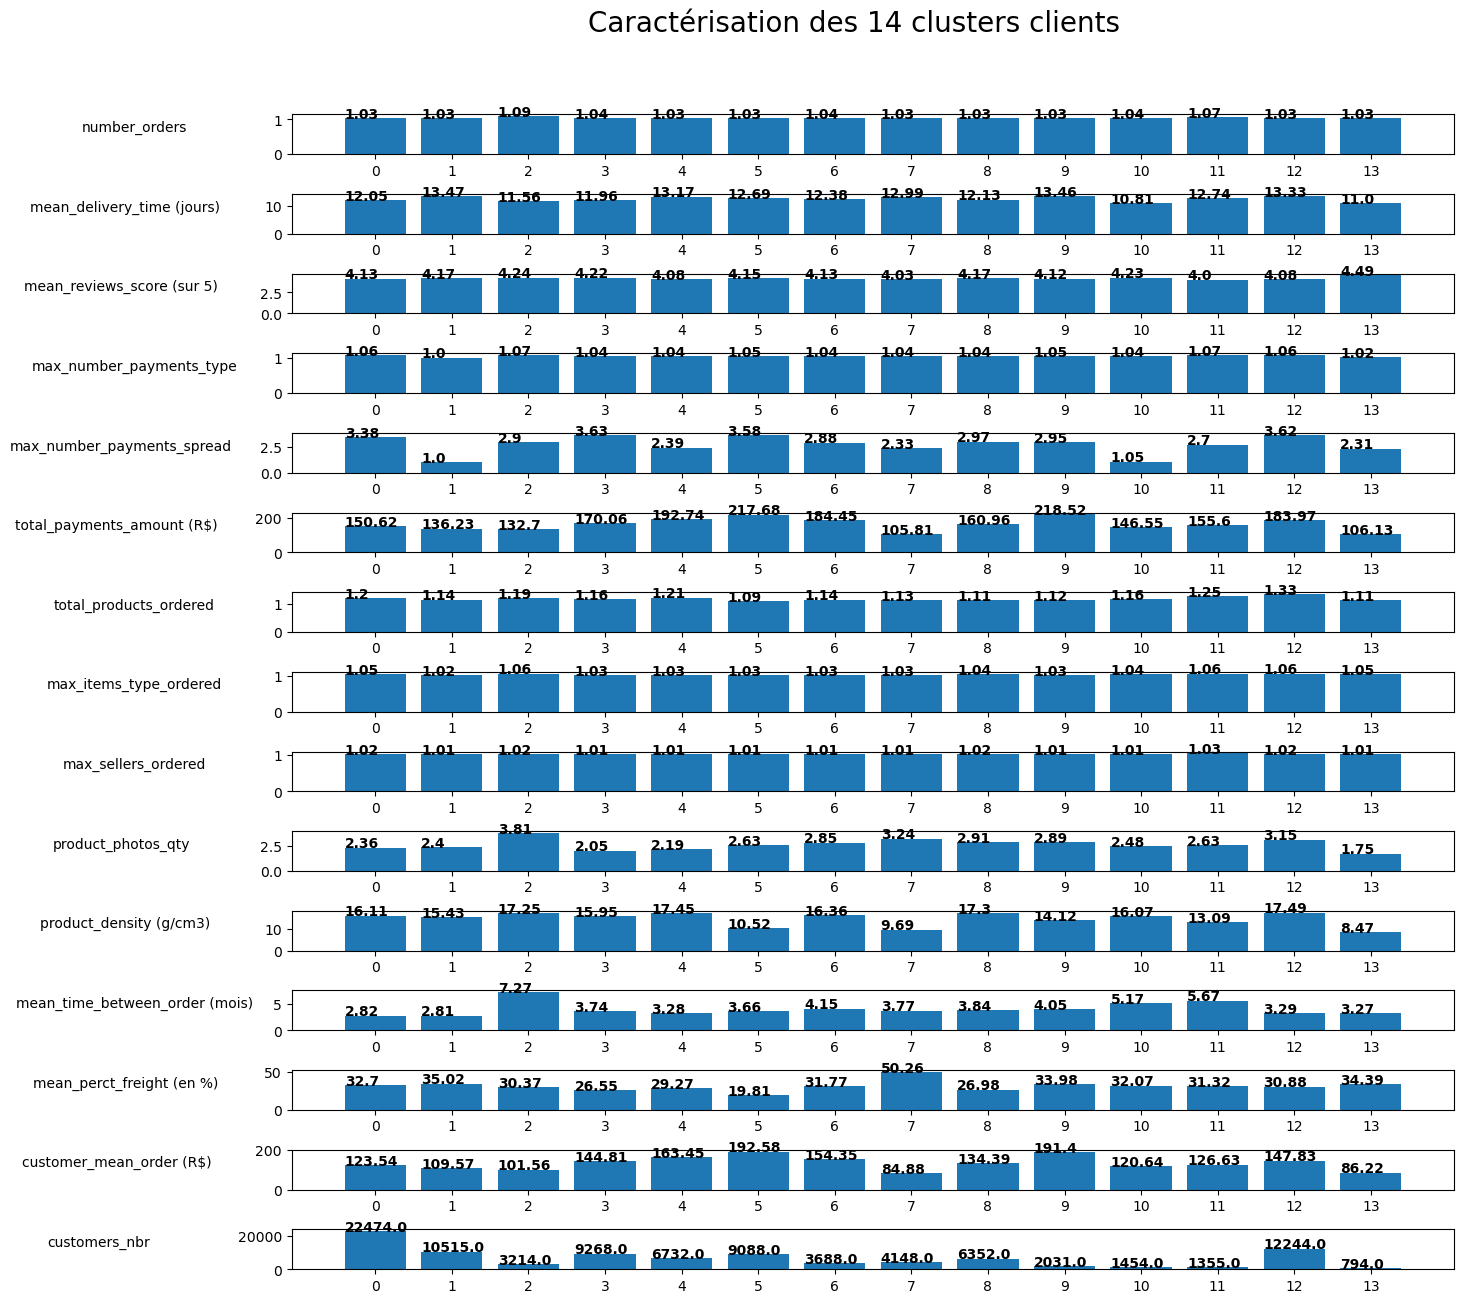

In [247]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=1, wspace=1)

for idx, name in enumerate(df_carac_14_clusters_num.index):
    ax = fig.add_subplot(len(df_carac_14_clusters_num.index), 1, idx+1)
    ax.bar(x=df_carac_14_clusters_num.columns, height=df_carac_14_clusters_num.loc[name, :], width=0.8)
    ax.set_ylabel(name, rotation=0, labelpad=100)
    for i, v in enumerate(df_carac_14_clusters_num.loc[name, :].values):
        #print(i, v)
        ax.text(i-0.4, v, str(v), color='black', fontweight='bold')
fig.suptitle("Caractérisation des 14 clusters clients", fontsize=20, y=0.95)

plt.show()

In [383]:
# Modification: préparation pour affichage sous forme de heatmap avec seaborn
k14_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
arr_features_std = {}

for idx, feature in enumerate(df_carac_14_clusters_num.index):
    arr_feature_std = km3_scaler.fit_transform(df_carac_14_clusters_num.loc[feature, :].apply(pd.Series))
    list_feature_std = [str(value)[1:-1] for value in arr_feature_std]
    arr_features_std[idx] = list_feature_std
# print(arr_features_std)

In [396]:
df_carac_k14 = pd.DataFrame.from_dict(
    arr_features_std,
    orient='index'
)

df_carac_k14 = df_carac_k14.astype(np.float64)
df_carac_k14.index = df_carac_14_clusters_num.index
#display(df_carac_k14)

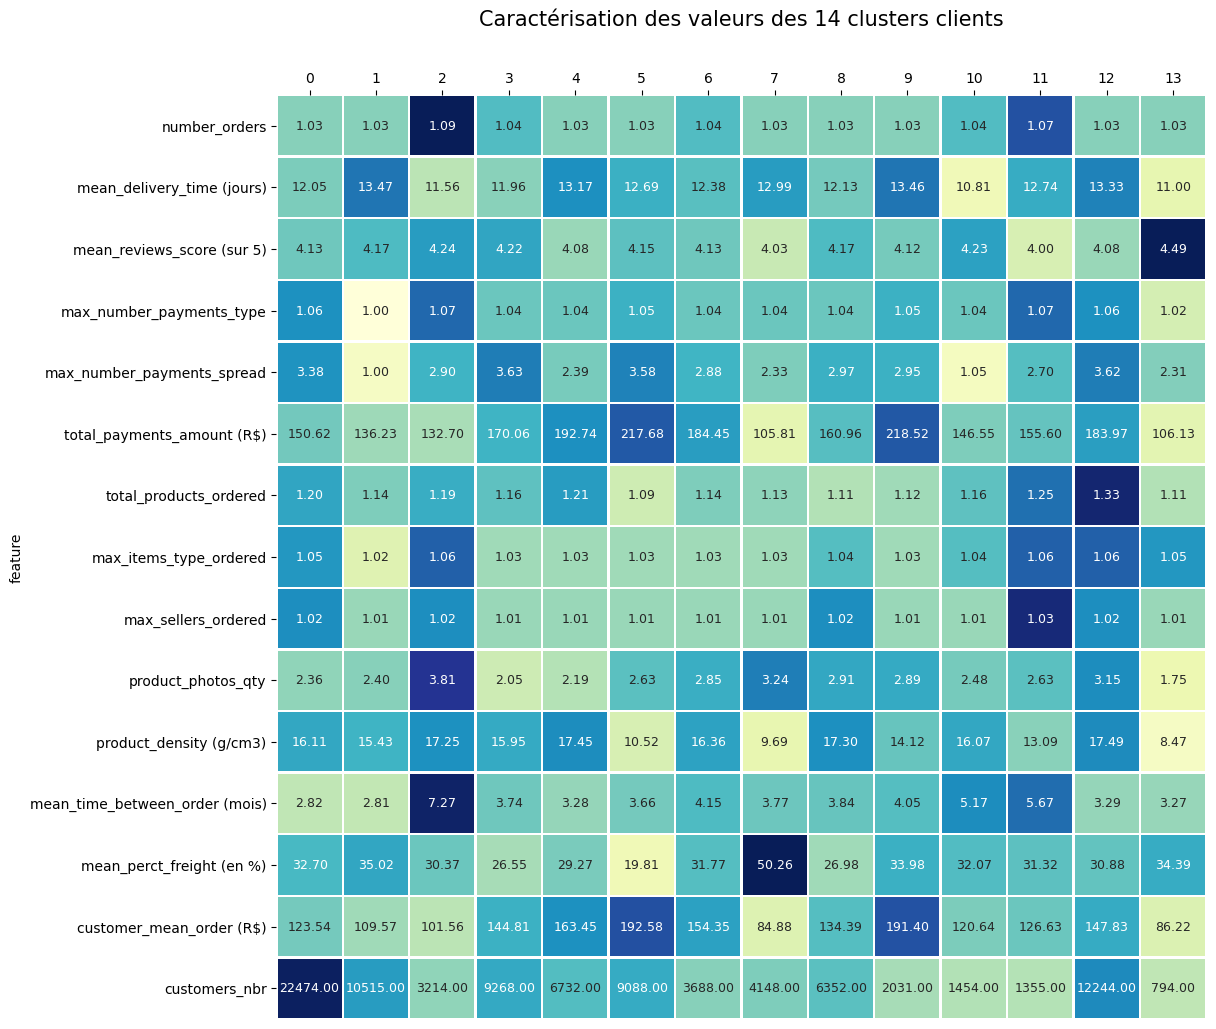

In [395]:
plt.figure(figsize=(12,12))

ax_k14 = sns.heatmap(
    df_carac_k14,
    cmap='YlGnBu',
    linewidths=1,
    linecolor='white',
    annot_kws={"size":9},
    annot=df_carac_14_clusters_num,
    fmt='.2f',
    cbar=False
)

ax_k14.xaxis.set_ticks_position('top')
ax_k14.set_title("Caractérisation des valeurs des 14 clusters clients", fontsize=15, pad=50)
plt.show()

### Détermination de la fréquence de maintenance

In [248]:
print(df_rfm_seg.shape)
print(df_3rd_kmeans_init.shape)

(96477, 5)
(93357, 49)


In [249]:
df_rfm_seg.head()

customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

   payment_value order_purchase_timestamp order_status  
0         146.87      2017-05-16 15:05:35    delivered  
1         335.48      2018-01-12 20:48:24    delivered  
2         157.73      2018-05-19 16:07:45    delivered  
3         173.30      2018-03-13 16:06:38    delivered  
4         252.25      2018-07-29 09:51:30    delivered

In [250]:
df_3rd_kmeans_std_v2.head()

cat_auto  cat_books  cat_childhood  cat_construction_tools  \
0 -0.186355  -0.088646      -0.258083               -0.208498   
1 -0.186355  -0.088646      -0.258083               -0.208498   
2 -0.186355  -0.088646      -0.258083               -0.208498   
3 -0.186355  -0.088646      -0.258083               -0.208498   
4 -0.186355  -0.088646      -0.258083               -0.208498   

   cat_fashion_clothes_accessories  cat_food  cat_gifts_art_decoration  \
0                         -0.17749 -0.085071                 -0.311159   
1                         -0.17749 -0.085071                 -0.311159   
2                         -0.17749 -0.085071                 -0.311159   
3                         -0.17749 -0.085071                 -0.311159   
4                         -0.17749 -0.085071                 -0.311159   

   cat_health_beauty_hygiene  cat_high_tech  cat_home_comfort_appliance  \
0                  -0.342167      -0.243928                    1.374727   
1                   2.142758      -0.243928                   -0.428693   
2                  -0.342167      -0.243928                   -0.428693   
3                  -0.342167      -0.243928                   -0.428693   
4                  -0.342167      -0.243928                   -0.428693   

   cat_home_office_furniture  cat_professional  cat_telephony  cat_unknown  \
0                  -0.298459         -0.066943      -0.192078    -0.113839   
1                  -0.298459         -0.066943      -0.192078    -0.113839   
2                   1.809838         -0.066943      -0.192078    -0.113839   
3                  -0.298459         -0.066943       3.632156    -0.113839   
4                  -0.298459         -0.066943       3.632156    -0.113839   

   cat_video_audio_instruments  payment_type_boleto  payment_type_credit_card  \
0                    -0.144379            -0.491516                  0.420951   
1                    -0.144379            -0.491516                  0.420951   
2                    -0.144379            -0.491516                  0.420951   
3                    -0.144379            -0.491516                  0.420951   
4                    -0.144379            -0.491516                  0.420951   

   payment_type_debit_card  payment_type_voucher  std_frequency  std_monetary  \
0                -0.125811              -0.13597       -0.15983      0.291362   
1                -0.125811              -0.13597       -0.15983     -1.732576   
2                -0.125811              -0.13597       -0.15983     -0.318928   
3                -0.125811              -0.13597       -0.15983     -1.153587   
4                -0.125811              -0.13597       -0.15983      0.692559   

   std_recency  
0    -0.718219  
1    -0.692091  
2     1.618178  
3     0.642666  
4     0.467132

In [251]:
df_3rd_kmeans_init.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status  mean_delivery_time  \
0             SP              1             1            6.411227   
1             SP              1             1            3.285590   
2             SC              1             1           25.731759   
3             PA              1             1           20.037083   
4             SP              1             1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.

In [252]:
df_freq_part_init = pd.merge(df_3rd_kmeans_init, df_rfm_seg, on='customer_unique_id', how='inner')  

In [253]:
df_freq_part_init.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  number_orders  order_status_x  mean_delivery_time  \
0             SP              1               1            6.411227   
1             SP              1               1            3.285590   
2             SC              1               1           25.731759   
3             PA              1               1           20.037083   
4             SP              1               1           13.141134   

   number_reviews  mean_reviews_score words_comments_title  \
0               1                 5.0      Super Recomendo   
1               1                 4.0                  NaN   
2               1                 3.0                  NaN   
3               1                 4.0                  NaN   
4               1                 5.0                  NaN   

                              words_comments_message  \
0  Adorei a cortina, ficou linda na minha sala, e...   
1                                                NaN   
2                                                NaN   
3                                       Bom vendedor   
4                                                NaN   

   max_number_payments_type  max_number_payments_spread  \
0                       1.0                         8.0   
1                       1.0                         1.0   
2                       1.0                         8.0   
3                       1.0                         4.0   
4                       1.0                         6.0   

   total_payments_amount  payment_type_boleto  payment_type_credit_card  \
0                 141.90                  0.0                       1.0   
1                  27.19                  0.0                       1.0   
2                  86.22                  0.0                       1.0   
3                  43.62                  0.0                       1.0   
4                 196.89                  0.0                       1.0   

   payment_type_debit_card  payment_type_voucher  total_products_ordered  \
0                      0.0                   0.0                     1.0   
1                      0.0                   0.0                     1.0   
2                      0.0                   0.0                     1.0   
3                      0.0                   0.0                     1.0   
4                      0.0                   0.0                     1.0   

   max_items_type_ordered  max_sellers_ordered  product_photos_qty  \
0                     1.0                  1.0                 1.0   
1                     1.0                  1.0                 1.0   
2                     1.0                  1.0                 3.0   
3                     1.0                  1.0                 5.0   
4                     1.0                  1.0                 3.0   

   product_density  cat_auto  cat_books  cat_childhood  \
0         5.077333       0.0        0.0            0.0   
1        13.728000       0.0        0.0            0.0   
2        29.166667       0.0        0.0            0.0   
3         6.966667       0.0        0.0            0.0   
4         0.087273       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4           

In [254]:
# sélection de la proportion du jeu de données en fonction de : 'order_purchase_timestamp'
df_freq_part_init['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [255]:
# https://dateutil.readthedocs.io/en/stable/relativedelta.html
ref_date_freq =  df_freq_part_init['order_purchase_timestamp'].max() + relativedelta(months=-3)
print(ref_date_freq)

2018-05-29 15:00:37


In [256]:
df_freq_part_init_select = df_freq_part_init[df_freq_part_init['order_purchase_timestamp'] < ref_date_freq]

In [257]:
df_freq_part_init_select['order_purchase_timestamp'].max()

Timestamp('2018-05-29 14:54:54')

In [258]:
df_freq_part_init_select.shape

(77523, 53)

In [259]:
col_freq_km = [
    # variables RFM normalisées
    'std_recency',
    'std_frequency',
    'std_monetary',
    # variables de catégories
    'cat_auto',
    'cat_books',
    'cat_childhood',
    'cat_construction_tools',
    'cat_fashion_clothes_accessories',
    'cat_food',
    'cat_gifts_art_decoration',
    'cat_health_beauty_hygiene',
    'cat_high_tech',
    'cat_home_comfort_appliance',
    'cat_home_office_furniture',
    'cat_professional',
    'cat_telephony',
    'cat_unknown',
    'cat_video_audio_instruments',
    'payment_type_boleto',
    'payment_type_credit_card',
    'payment_type_debit_card',
    'payment_type_voucher' 
]

In [260]:
df_km_freq_part = df_freq_part_init_select[col_freq_km]

In [261]:
df_km_freq_part.head()

std_recency  std_frequency  std_monetary  cat_auto  cat_books  \
0    -0.718219       -0.15983      0.291362       0.0        0.0   
1    -0.692091       -0.15983     -1.732576       0.0        0.0   
2     1.618178       -0.15983     -0.318928       0.0        0.0   
3     0.642666       -0.15983     -1.153587       0.0        0.0   
4     0.467132       -0.15983      0.692559       0.0        0.0   

   cat_childhood  cat_construction_tools  cat_fashion_clothes_accessories  \
0            0.0                     0.0                              0.0   
1            0.0                     0.0                              0.0   
2            0.0                     0.0                              0.0   
3            0.0                     0.0                              0.0   
4            0.0                     0.0                              0.0   

   cat_food  cat_gifts_art_decoration  cat_health_beauty_hygiene  \
0       0.0                       0.0                        0.0   
1       0.0                       0.0                        1.0   
2       0.0                       0.0                        0.0   
3       0.0                       0.0                        0.0   
4       0.0                       0.0                        0.0   

   cat_high_tech  cat_home_comfort_appliance  cat_home_office_furniture  \
0            0.0                         1.0                        0.0   
1            0.0                         0.0                        0.0   
2            0.0                         0.0                        1.0   
3            0.0                         0.0                        0.0   
4            0.0                         0.0                        0.0   

   cat_professional  cat_telephony  cat_unknown  cat_video_audio_instruments  \
0               0.0            0.0          0.0                          0.0   
1               0.0            0.0          0.0                          0.0   
2               0.0            0.0          0.0                          0.0   
3               0.0            1.0          0.0                          0.0   
4               0.0            1.0          0.0                          0.0   

   payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                  0.0                       1.0                      0.0   
1                  0.0                       1.0                      0.0   
2                  0.0                       1.0                      0.0   
3                  0.0                       1.0                      0.0   
4                  0.0                       1.0                      0.0   

   payment_type_voucher  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [262]:
km_freq_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
df_km_freq_part_std = km_freq_scaler.fit_transform(df_km_freq_part)
df_km_freq_part_std = pd.DataFrame(
    data = df_km_freq_part_std,
    index = df_km_freq_part.index,
    columns = df_km_freq_part.columns
)

df_km_freq_part_std.agg(['mean', 'std']).round(2)

std_recency  std_frequency  std_monetary  cat_auto  cat_books  \
mean          0.0           -0.0           0.0       0.0        0.0   
std           1.0            1.0           1.0       1.0        1.0   

      cat_childhood  cat_construction_tools  cat_fashion_clothes_accessories  \
mean           -0.0                    -0.0                              0.0   
std             1.0                     1.0                              1.0   

      cat_food  cat_gifts_art_decoration  cat_health_beauty_hygiene  \
mean      -0.0                      -0.0                        0.0   
std        1.0                       1.0                        1.0   

      cat_high_tech  cat_home_comfort_appliance  cat_home_office_furniture  \
mean           -0.0                         0.0                        0.0   
std             1.0                         1.0                        1.0   

      cat_professional  cat_telephony  cat_unknown  \
mean              -0.0           -0.0         -0.0   
std                1.0            1.0          1.0   

      cat_video_audio_instruments  payment_type_boleto  \
mean                          0.0                  0.0   
std                           1.0                  1.0   

      payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
mean                       0.0                      0.0                  -0.0  
std                        1.0                      1.0                   1.0

In [263]:
%%time
km_freq_model = KMeans(init = 'k-means++', n_clusters = 14, random_state = 42)
km_freq_labels = km_freq_model.fit_predict(df_km_freq_part_std)

inertia = km_freq_model.inertia_
print("Inertia SSE :", inertia)

silhouette_avg = silhouette_score(df_km_freq_part_std, km_freq_labels)
print("silhouette_avg :", silhouette_avg)

davies_bouldin_index = davies_bouldin_score(df_km_freq_part_std, km_freq_labels)
print("Davies-Bouldin index : ", davies_bouldin_index)

Inertia SSE : 886988.0924605905
silhouette_avg : 0.2605308762597513
Davies-Bouldin index :  1.2834180683200824
Wall time: 2min 31s


In [264]:
def display_metrics_variation_km(dataframe, period, k_clusters=14):
    """
    Fonction qui permet de tester l'évolution des métriques en fonction,
    de la proportion des données disponibles par rapport à la dernière date de commande.
    
    Args:
        dataframe (DataFrame): Dataframe préparé qui permet d'effectuer les calculs.
        period (range): Nombres de mois que l'on envèle au dataset pour effectuer les calculs.
    
    Returns:
        inertia_values, silhouette_avg_values, davies_bouldin_values (float) : Métriques d'intérêt.
    """
    
    inertia_values = []
    silhouette_avg_values = []
    davies_bouldin_values = []
    
    col_freq_km = [
        # variables RFM normalisées
        'std_recency',
        'std_frequency',
        'std_monetary',
        # variables de catégories
        'cat_auto',
        'cat_books',
        'cat_childhood',
        'cat_construction_tools',
        'cat_fashion_clothes_accessories',
        'cat_food',
        'cat_gifts_art_decoration',
        'cat_health_beauty_hygiene',
        'cat_high_tech',
        'cat_home_comfort_appliance',
        'cat_home_office_furniture',
        'cat_professional',
        'cat_telephony',
        'cat_unknown',
        'cat_video_audio_instruments',
        'payment_type_boleto',
        'payment_type_credit_card',
        'payment_type_debit_card',
        'payment_type_voucher' 
    ]
    
    for month in period:
    
        ref_date_freq =  dataframe['order_purchase_timestamp'].max() + relativedelta(months=-month)
        #print(ref_date_freq)
    
        df_freq_part_init_select = dataframe[dataframe['order_purchase_timestamp'] < ref_date_freq]
    
        df_km_freq_part = df_freq_part_init_select[col_freq_km]
    
        km_freq_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
        df_km_freq_part_std = km_freq_scaler.fit_transform(df_km_freq_part)
        df_km_freq_part_std = pd.DataFrame(
            data = df_km_freq_part_std,
            index = df_km_freq_part.index,
            columns = df_km_freq_part.columns
        )

        km_freq_model = KMeans(init = 'k-means++', n_clusters = k_clusters, random_state = 42)
        km_freq_labels = km_freq_model.fit_predict(df_km_freq_part_std)

        inertia = km_freq_model.inertia_
        inertia_values.append(inertia)
        #print("Inertia SSE :", inertia)

        silhouette_avg = silhouette_score(df_km_freq_part_std, km_freq_labels)
        silhouette_avg_values.append(silhouette_avg)
        #print("silhouette_avg :", silhouette_avg)

        davies_bouldin_index = davies_bouldin_score(df_km_freq_part_std, km_freq_labels)
        davies_bouldin_values.append(davies_bouldin_index)
        #print("Davies-Bouldin index : ", davies_bouldin_index)

    return inertia_values, silhouette_avg_values, davies_bouldin_values

In [265]:
%%time
%%script false
retrieve_metrics_values_freq = display_metrics_variation_km(df_freq_part_init, period=range(1,13))

Couldn't find program: 'false'
Wall time: 9.63 ms


In [266]:
%%script false
pickle.dump(retrieve_metrics_values_freq, open("retrieve_metrics_values_freq.pkl", "wb"))

Couldn't find program: 'false'


In [267]:
retrieve_metrics_values_freq = pickle.load(open("retrieve_metrics_values_freq.pkl", "rb"))

In [268]:
#print(retrieve_metrics_values_freq[0])
#print(retrieve_metrics_values_freq[1])
#print(retrieve_metrics_values_freq[2])

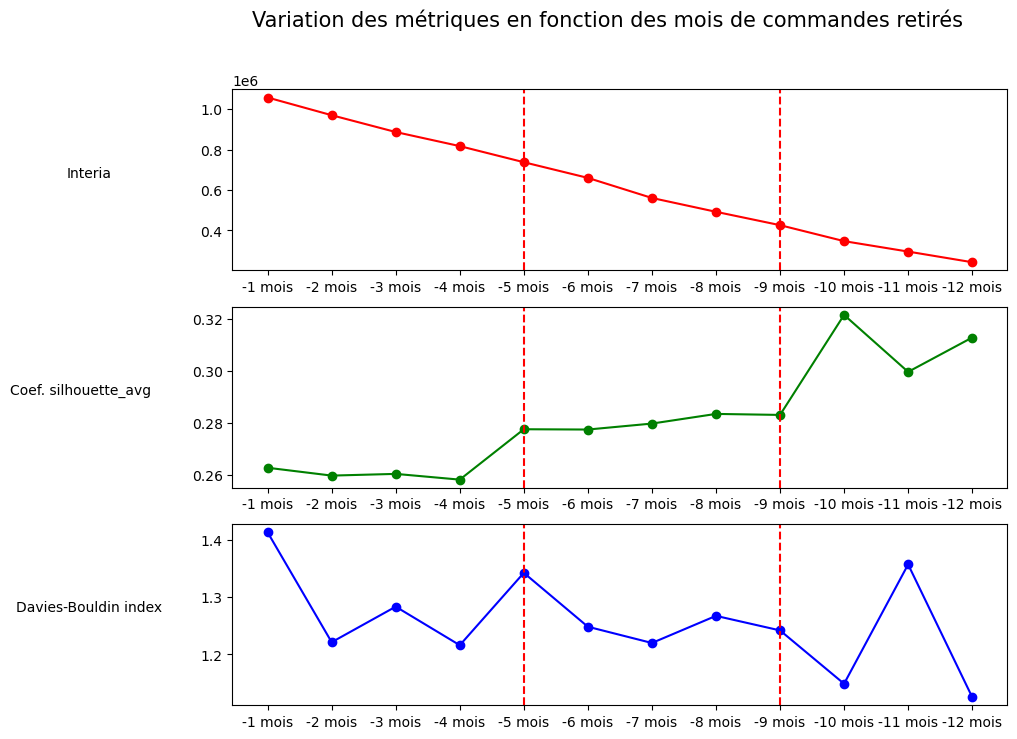

In [269]:
fig = plt.figure(figsize=(10,8))
#fig.subplots_adjust(hspace=1, wspace=1)
metrics_names = ['Interia', 'Coef. silhouette_avg', 'Davies-Bouldin index']
metrics_color = ['r', 'g', 'b']

for idx, values in enumerate(retrieve_metrics_values_freq):
    ax = fig.add_subplot(3, 1, idx+1)
    ax.plot(values, '-o', color=metrics_color[idx])
    ax.set_ylabel(metrics_names[idx], rotation=0, labelpad=80)
    ax.axvline(x=4, color="red", linestyle="--")
    ax.axvline(x=8, color="red", linestyle="--")
    ax.set_xticks(range(0,12)) # définit la position
    ax.set_xticklabels(['-1 mois', '-2 mois', '-3 mois', '-4 mois', '-5 mois', '-6 mois',
                        '-7 mois', '-8 mois', '-9 mois', '-10 mois', '-11 mois', '-12 mois'])
fig.suptitle("Variation des métriques en fonction des mois de commandes retirés", fontsize=15)

plt.show()

In [270]:
%%time
%%script false
# Le coefficient de silhouettte semble se "stabiliser" tous les 4/5 mois.
# Pour vérifier je recherche le meilleur nombre de clusters suivant ces périodes
# et je regarde si l'on peut trouver un nombre clusters différents pour des valeurs de métriques équivalentes. (ref. à 14 sur données complètes))
# Ce qui confirmera ou non le besoin d'effectuer une maintenance à cette fréquence pour maintenir le nombre de clusters à jour.
clusters_range = range(2,21)
freq_metrics_results = {}
for cluster in clusters_range:
    retrieve_metrics_values_freq = display_metrics_variation_km(df_freq_part_init, period=[4], k_clusters=cluster)
    freq_metrics_results[cluster] = retrieve_metrics_values_freq

Couldn't find program: 'false'
Wall time: 5 ms


In [271]:
%%script false
pickle.dump(freq_metrics_results, open("freq_metrics_results.pkl", "wb"))

Couldn't find program: 'false'


In [272]:
freq_metrics_results = pickle.load(open("freq_metrics_results.pkl", "rb"))

In [273]:
display(freq_metrics_results)

{2: ([1453659.336580617], [0.17772654971114893], [2.556014114588883]),
 3: ([1382972.1705217075], [0.16742865188710251], [1.8363110752043703]),
 4: ([1329650.6248207586], [0.16989752424502808], [2.0067442960763153]),
 5: ([1268671.7372946725], [0.1529112377104017], [1.835388121084398]),
 6: ([1222730.5338894832], [0.10117488869169569], [1.728049408717718]),
 7: ([1167911.7779956707], [0.15484255162757032], [1.6609650411839565]),
 8: ([1092529.1756746145], [0.16146845405624158], [1.478603809347543]),
 9: ([1052642.183127942], [0.17957048890354288], [1.468516680397335]),
 10: ([1011495.4072342077], [0.20194731754634046], [1.2017020806538743]),
 11: ([955089.0037688959], [0.1915110756736238], [1.3756225726699647]),
 12: ([912769.7950796043], [0.2376016911867819], [1.2940825105673592]),
 13: ([857130.8781744514], [0.23431538751445596], [1.2407963973255742]),
 14: ([817296.9939423894], [0.2583298647200437], [1.2161017583845657]),
 15: ([747937.4557608559], [0.30650743426540483], [1.15411064

array([1453659.33658062, 1382972.17052171, 1329650.62482076,
       1268671.73729467, 1222730.53388948, 1167911.77799567,
       1092529.17567461, 1052642.18312794, 1011495.40723421,
        955089.0037689 ,  912769.7950796 ,  857130.87817445,
        817296.99394239,  747937.45576086,  710687.384861  ,
        675923.60686237,  643399.10008343,  625570.55140445,
        584426.63782133])

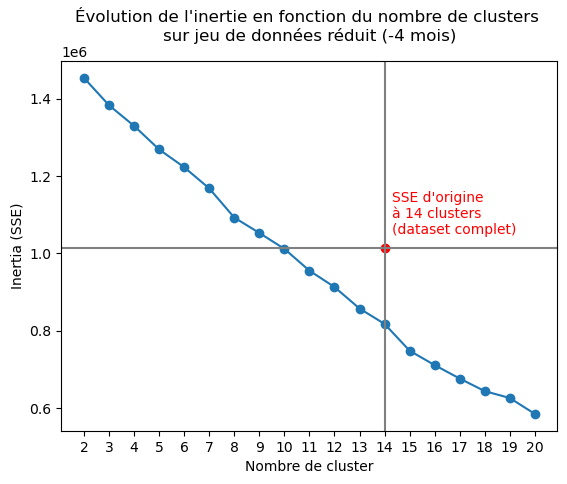

In [274]:
# Rappel : SSE v4 à 14 clusters: 1014823.8872500154 (sur jeu de données complètes)
# Evolution de la SSE en fonction du nombre de clusters sur les données utilisées pour la clusterisation à 14
sse_evolution = []
for metric_value in freq_metrics_results.values():
    sse_evolution.append(metric_value[0][0])
sse_evolution_arr = np.array(sse_evolution)
display(sse_evolution_arr)

plt.title(
    "Évolution de l'inertie en fonction du nombre de clusters \nsur jeu de données réduit (-4 mois)",
    pad=15
)
plt.xticks(range(0,19), range(2,21))
plt.xlabel("Nombre de cluster")
plt.ylabel("Inertia (SSE)")

plt.plot(sse_evolution_arr, '-o')

plt.axhline(y=1014823, color='gray', linestyle='-')
plt.axvline(x=12, color='gray', linestyle='-') # 12 en position pour 14 clusters
plt.scatter(x=12, y=1014823, color='r')
plt.text(x=12.3, y=1050000, s="SSE d'origine \nà 14 clusters \n(dataset complet)", color='r')

plt.show()

array([0.17772655, 0.16742865, 0.16989752, 0.15291124, 0.10117489,
       0.15484255, 0.16146845, 0.17957049, 0.20194732, 0.19151108,
       0.23760169, 0.23431539, 0.25832986, 0.30650743, 0.3012333 ,
       0.32159935, 0.32331812, 0.30154143, 0.29652467])

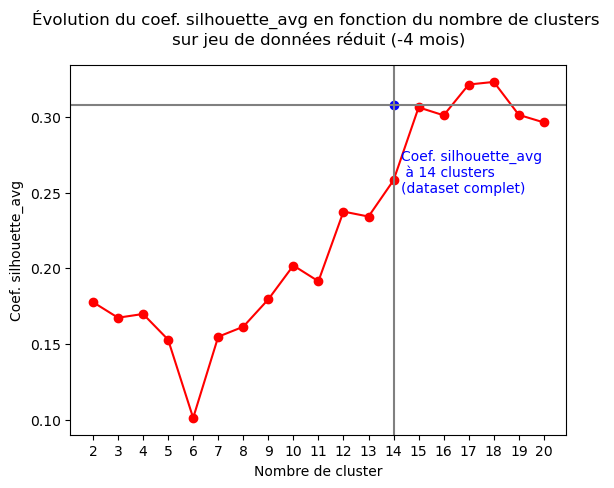

In [275]:
# Rappel : Coef. silhouette (avg) v4 à 14 clusters 0.3077419061228306 (sur jeu de données complètes)
# Evolution du coef. silhouette en fonction du nombre de clusters sur les données utilisées (-4 mois) pour la clusterisation à 14
silhouette_avg = []
for metric_value in freq_metrics_results.values():
    silhouette_avg.append(metric_value[1][0])
silhouette_avg_arr = np.array(silhouette_avg)
display(silhouette_avg_arr)

plt.title(
    "Évolution du coef. silhouette_avg en fonction du nombre de clusters \nsur jeu de données réduit (-4 mois)",
    pad=15
)
plt.xticks(range(0,19), range(2,21))
plt.xlabel("Nombre de cluster")
plt.ylabel("Coef. silhouette_avg")

plt.plot(silhouette_avg_arr, '-o', color='r')

plt.axhline(y=0.3077419061228306, color='gray', linestyle='-')
plt.axvline(x=12, color='gray', linestyle='-') # 12 en position pour 14 clusters
plt.scatter(x=12, y=0.3077419061228306, color='b')
plt.text(x=12.3, y=0.25, s="Coef. silhouette_avg \n à 14 clusters \n(dataset complet)", color='b')

plt.show()

array([2.55601411, 1.83631108, 2.0067443 , 1.83538812, 1.72804941,
       1.66096504, 1.47860381, 1.46851668, 1.20170208, 1.37562257,
       1.29408251, 1.2407964 , 1.21610176, 1.15411064, 1.12316808,
       1.12151843, 1.25225988, 1.11681235, 1.05353913])

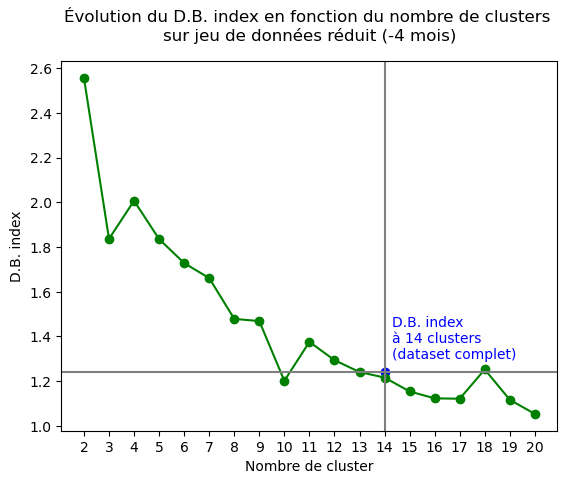

In [276]:
# Rappel : Indice D.B. v4 à 14 clusters 1.241760348365552 (sur jeu de données complètes)
# Evolution de l'indice de D.B. en fonction du nombre de clusters sur les données utilisées (-4 mois) pour la clusterisation à 14
db_index = []
for metric_value in freq_metrics_results.values():
    db_index.append(metric_value[2][0])
db_index_arr = np.array(db_index)
display(db_index_arr)

plt.title(
    "Évolution du D.B. index en fonction du nombre de clusters \nsur jeu de données réduit (-4 mois)",
    pad=15
)
plt.xticks(range(0,19), range(2,21))
plt.xlabel("Nombre de cluster")
plt.ylabel("D.B. index")

plt.plot(db_index_arr, '-o', color='g')

plt.axhline(y=1.241760348365552, color='gray', linestyle='-')
plt.axvline(x=12, color='gray', linestyle='-') # 12 en position pour 14 clusters
plt.scatter(x=12, y=1.241760348365552, color='b')
plt.text(x=12.3, y=1.3, s="D.B. index \nà 14 clusters \n(dataset complet)", color='b')

plt.show()

### t-SNE : Exploration de structures locales (identification de patterns ?)
- Représentation des données par rapport à la proximité (distance: probabilité conditionnelle à la distance)
- Cela peut aider à la compréhention visuelle du jeu de données
- t-SNE n'a qu'une méthode fit_transform (si nouvelles données, on doit le refaire sur l'ensemble)
- learning_rate : généralement entre 50 et 200 (balance entre la conservation structure globale/locale)
- méthode qui donne des résultats différents à chaque fois (non reproductible) -> seed obligatoire
- "couplage" avec PCA peut être un plus
- rappel : les axes issus du t-SNE n'ont pas de signification particulière

In [277]:
col_tsne_to_select =\
[name for name in df_customers_km_v4.columns if df_customers_km_v4[name].dtypes == 'float64']

In [278]:
col_name_iqr = 'total_payments_amount'
df_customers_km_v4[col_name_iqr].describe()

count    93357.000000
mean       165.406361
std        226.915603
min          9.590000
25%         63.100000
50%        107.850000
75%        182.760000
max      13664.080000
Name: total_payments_amount, dtype: float64

In [279]:
q1 = df_customers_km_v4[col_name_iqr].quantile(.25)
q3 = df_customers_km_v4[col_name_iqr].quantile(.75)
iqr_mask = df_customers_km_v4[col_name_iqr].between(q1, q3, inclusive=True)
iqr_col_values = df_customers_km_v4.loc[iqr_mask, col_name_iqr]

In [280]:
iqr_col_values.describe()

count    46689.000000
mean       112.351564
std         33.705640
min         63.100000
25%         82.910000
50%        107.850000
75%        138.960000
max        182.760000
Name: total_payments_amount, dtype: float64

In [281]:
%%time
#%%script false
tsne_model = TSNE(
    #init = 'pca',
    learning_rate = 10, # balance conservation structure globale/locale
    n_iter = 300, # optimisation par défaut
    perplexity = 30, # les plus proches voisins par défaut 30
    random_state = 42
)

tsne_features = tsne_model.fit_transform(df_customers_km_v4.loc[iqr_mask ,['std_recency', 'std_frequency', 'std_monetary']])
x_tsne = tsne_features[:, 0]
y_tsne = tsne_features[:, 1]

sns.scatterplot(x=x_tsne, y=y_tsne, hue=iqr_col_values)

plt.show()

Couldn't find program: 'false'
Wall time: 7.99 ms


### Pyspark et ALS (Alternating Least Squares algorithm)
But : Apprendre à utiliser les deux et regarder ce que je peux obtenir (recommandations sur les catégories)

In [282]:
# Emplacement de spark (variables d'environnement ajoutées préalablement pour le système)
findspark.init()
findspark.find()

'C:\\spark-3.1.2-bin-hadoop3.2'

In [283]:
# Paramétrage de connexion au cluster ici -> local (installé sur la même machine) localhost:4040
spark_conn = SparkContext("local", "Testing")
print(spark_conn.version)

3.1.2


In [284]:
# On créé une session pour l'interfaçage
# builder.getOrCreate() -> pratique si une session est déjà existant
spark_session = SparkSession.builder.getOrCreate()
print(spark_session)

In [285]:
# Attention notre df_customers comporte des Nan qu'il faut transformer (spark n'apprécie pas les mixed type.
# mean_delivery_time -> il y a des commandes qui n'ont pas encore été livrées (d'où les Nan)
# words_comments_title et words_comments_message -> c'est normal, 
# les clients ne renseigne pas toujours en complément du mean_reviews_score
df_customers_als = df_customers_k_labels.copy()

In [286]:
df_customers_als.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_unique_id               95420 non-null  object 
 1   customer_zip_code_prefix         95420 non-null  int64  
 2   customer_city                    95420 non-null  object 
 3   customer_state                   95420 non-null  object 
 4   number_orders                    95420 non-null  int64  
 5   order_status                     95420 non-null  int64  
 6   mean_delivery_time               95420 non-null  float64
 7   number_reviews                   95420 non-null  int64  
 8   mean_reviews_score               95420 non-null  float64
 9   words_comments_title             11456 non-null  object 
 10  words_comments_message           40036 non-null  object 
 11  max_number_payments_type         95420 non-null  float64
 12  max_number_payment

In [287]:
df_customers_als_num = df_customers_als[df_customers_als.columns.difference([
    'clusters_label',
    'customer_zip_code_prefix',
    'customer_city',
    'customer_state',
    'words_comments_title',
    'words_comments_message',
])]

# Imputation de la colonne des moyennes de livraisons (commandes pas encore livrées)
df_customers_als_num = df_customers_als_num.fillna(0)
display(df_customers_als_num.info())
display(df_customers_als_num.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cat_auto                         95420 non-null  float64
 1   cat_books                        95420 non-null  float64
 2   cat_childhood                    95420 non-null  float64
 3   cat_construction_tools           95420 non-null  float64
 4   cat_fashion_clothes_accessories  95420 non-null  float64
 5   cat_food                         95420 non-null  float64
 6   cat_gifts_art_decoration         95420 non-null  float64
 7   cat_health_beauty_hygiene        95420 non-null  float64
 8   cat_high_tech                    95420 non-null  float64
 9   cat_home_comfort_appliance       95420 non-null  float64
 10  cat_home_office_furniture        95420 non-null  float64
 11  cat_professional                 95420 non-null  float64
 12  cat_telephony     

None

cat_auto                           0
cat_books                          0
cat_childhood                      0
cat_construction_tools             0
cat_fashion_clothes_accessories    0
cat_food                           0
cat_gifts_art_decoration           0
cat_health_beauty_hygiene          0
cat_high_tech                      0
cat_home_comfort_appliance         0
cat_home_office_furniture          0
cat_professional                   0
cat_telephony                      0
cat_unknown                        0
cat_video_audio_instruments        0
centroid_lat                       0
centroid_lng                       0
customer_mean_order                0
customer_unique_id                 0
k_label                            0
max_items_type_ordered             0
max_number_payments_spread         0
max_number_payments_type           0
max_sellers_ordered                0
mean_delivery_time                 0
mean_perct_freight                 0
mean_reviews_score                 0
m

#### Table 'cat_products' préparée (wide_to_long) à partir de pandas

In [288]:
# On commence par sélectionner uniquement les colonnes d'intérêt
list_of_selected_cols = ['customer_unique_id']
cat_products = [cat for cat in df_customers_als_num.columns if cat.startswith('cat_')]
#print(cat_products)

list_of_selected_cols.extend(cat_products)
pprint(list_of_selected_cols)

['customer_unique_id',
 'cat_auto',
 'cat_books',
 'cat_childhood',
 'cat_construction_tools',
 'cat_fashion_clothes_accessories',
 'cat_food',
 'cat_gifts_art_decoration',
 'cat_health_beauty_hygiene',
 'cat_high_tech',
 'cat_home_comfort_appliance',
 'cat_home_office_furniture',
 'cat_professional',
 'cat_telephony',
 'cat_unknown',
 'cat_video_audio_instruments']


In [289]:
df_customers_als_num[list_of_selected_cols].head()

customer_unique_id  cat_auto  cat_books  cat_childhood  \
0  0000366f3b9a7992bf8c76cfdf3221e2       0.0        0.0            0.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       0.0        0.0            0.0   
2  0000f46a3911fa3c0805444483337064       0.0        0.0            0.0   
3  0000f6ccb0745a6a4b88665a16c9f078       0.0        0.0            0.0   
4  0004aac84e0df4da2b147fca70cf8255       0.0        0.0            0.0   

   cat_construction_tools  cat_fashion_clothes_accessories  cat_food  \
0                     0.0                              0.0       0.0   
1                     0.0                              0.0       0.0   
2                     0.0                              0.0       0.0   
3                     0.0                              0.0       0.0   
4                     0.0                              0.0       0.0   

   cat_gifts_art_decoration  cat_health_beauty_hygiene  cat_high_tech  \
0                       0.0                        0.0            0.0   
1                       0.0                        1.0            0.0   
2                       0.0                        0.0            0.0   
3                       0.0                        0.0            0.0   
4                       0.0                        0.0            0.0   

   cat_home_comfort_appliance  cat_home_office_furniture  cat_professional  \
0                         1.0                        0.0               0.0   
1                         0.0                        0.0               0.0   
2                         0.0                        1.0               0.0   
3                         0.0                        0.0               0.0   
4                         0.0                        0.0               0.0   

   cat_telephony  cat_unknown  cat_video_audio_instruments  
0            0.0          0.0                          0.0  
1            0.0          0.0                          0.0  
2            0.0          0.0                          0.0  
3            1.0          0.0                          0.0  
4            1.0          0.0                          0.0

In [290]:
long_df_customers_cat_products = \
df_customers_als_num[list_of_selected_cols].melt(id_vars=['customer_unique_id'])
display(long_df_customers_cat_products.sort_values('customer_unique_id').head(25))

customer_unique_id                         variable  \
0        0000366f3b9a7992bf8c76cfdf3221e2                         cat_auto   
286260   0000366f3b9a7992bf8c76cfdf3221e2           cat_construction_tools   
381680   0000366f3b9a7992bf8c76cfdf3221e2  cat_fashion_clothes_accessories   
477100   0000366f3b9a7992bf8c76cfdf3221e2                         cat_food   
1049620  0000366f3b9a7992bf8c76cfdf3221e2                 cat_professional   
667940   0000366f3b9a7992bf8c76cfdf3221e2        cat_health_beauty_hygiene   
763360   0000366f3b9a7992bf8c76cfdf3221e2                    cat_high_tech   
95420    0000366f3b9a7992bf8c76cfdf3221e2                        cat_books   
1335880  0000366f3b9a7992bf8c76cfdf3221e2      cat_video_audio_instruments   
1240460  0000366f3b9a7992bf8c76cfdf3221e2                      cat_unknown   
190840   0000366f3b9a7992bf8c76cfdf3221e2                    cat_childhood   
954200   0000366f3b9a7992bf8c76cfdf3221e2        cat_home_office_furniture   
858780   0000366f3b9a7992bf8c76cfdf3221e2       cat_home_comfort_appliance   
572520   0000366f3b9a7992bf8c76cfdf3221e2         cat_gifts_art_decoration   
1145040  0000366f3b9a7992bf8c76cfdf3221e2                    cat_telephony   
858781   0000b849f77a49e4a4ce2b2a4ca5be3f       cat_home_comfort_appliance   
572521   0000b849f77a49e4a4ce2b2a4ca5be3f         cat_gifts_art_decoration   
1145041  0000b849f77a49e4a4ce2b2a4ca5be3f                    cat_telephony   
667941   0000b849f77a49e4a4ce2b2a4ca5be3f        cat_health_beauty_hygiene   
763361   0000b849f77a49e4a4ce2b2a4ca5be3f                    cat_high_tech   
381681   0000b849f77a49e4a4ce2b2a4ca5be3f  cat_fashion_clothes_accessories   
1049621  0000b849f77a49e4a4ce2b2a4ca5be3f                 cat_professional   
95421    0000b849f77a49e4a4ce2b2a4ca5be3f                        cat_books   
1335881  0000b849f77a49e4a4ce2b2a4ca5be3f      cat_video_audio_instruments   
954201   0000b849f77a49e4a4ce2b2a4ca5be3f        cat_home_office_furniture   

         value  
0          0.0  
286260     0.0  
381680     0.0  
477100     0.0  
1049620    0.0  
667940     0.0  
763360     0.0  
95420      0.0  
1335880    0.0  
1240460    0.0  
190840     0.0  
954200     0.0  
858780     1.0  
572520     0.0  
1145040    0.0  
858781     0.0  
572521     0.0  
1145041    0.0  
667941     1.0  
763361     0.0  
381681     0.0  
1049621    0.0  
95421      0.0  
1335881    0.0  
954201     0.0

In [291]:
# Pour ALS on doit retirer les valeurs nulles (pour les explicit ratings)
# Pas pour les implicit ratings
#long_df_customers_cat_products = long_df_customers_cat_products[long_df_customers_cat_products['value'] != 0]
display(long_df_customers_cat_products.head(25))

customer_unique_id  variable  value
0   0000366f3b9a7992bf8c76cfdf3221e2  cat_auto    0.0
1   0000b849f77a49e4a4ce2b2a4ca5be3f  cat_auto    0.0
2   0000f46a3911fa3c0805444483337064  cat_auto    0.0
3   0000f6ccb0745a6a4b88665a16c9f078  cat_auto    0.0
4   0004aac84e0df4da2b147fca70cf8255  cat_auto    0.0
5   0004bd2a26a76fe21f786e4fbd80607f  cat_auto    0.0
6   00050ab1314c0e55a6ca13cf7181fecf  cat_auto    0.0
7   00053a61a98854899e70ed204dd4bafe  cat_auto    0.0
8   0005e1862207bf6ccc02e4228effd9a0  cat_auto    0.0
9   0005ef4cd20d2893f0d9fbd94d3c0d97  cat_auto    0.0
10  0006fdc98a402fceb4eb0ee528f6a8d4  cat_auto    0.0
11  00082cbe03e478190aadbea78542e933  cat_auto    0.0
12  00090324bbad0e9342388303bb71ba0a  cat_auto    0.0
13  000949456b182f53c18b68d6babc79c1  cat_auto    0.0
14  000a5ad9c4601d2bbdd9ed765d5213b3  cat_auto    0.0
15  000bfa1d2f1a41876493be685390d6d3  cat_auto    0.0
16  000c8bdb58a29e7115cfc257230fb21b  cat_auto    0.0
17  000d460961d6dbfa3ec6c9f5805769e1  cat_auto    0.0
18  000de6019bb59f34c099a907c151d855  cat_auto    0.0
19  000e309254ab1fc5ba99dd469d36bdb4  cat_auto    0.0
20  000ec5bff359e1c0ad76a81a45cb598f  cat_auto    0.0
21  000ed48ceeb6f4bf8ad021a10a3c7b43  cat_auto    0.0
22  000fbf0473c10fc1ab6f8d2d286ce20c  cat_auto    0.0
23  0010a452c6d13139e50b57f19f52e04e  cat_auto    0.0
24  0010fb34b966d44409382af9e8fd5b77  cat_auto    0.0

In [292]:
long_df_customers_cat_products[long_df_customers_cat_products['value'] > 1].sort_values('value')

customer_unique_id                    variable  value
415      011733687890faf081be6fde9e7cc7a0                    cat_auto    2.0
912020   8f0997f7fe24ce1f63d872a95bcfc358  cat_home_comfort_appliance    2.0
912016   8f06e4e06ee6805f1b7ec21c78a2fbe8  cat_home_comfort_appliance    2.0
911996   8efdcd51f527f5aec0875573fd2210b3  cat_home_comfort_appliance    2.0
911992   8efcf8d46a42df3522551b16380846fd  cat_home_comfort_appliance    2.0
...                                   ...                         ...    ...
959941   0f5ac8d5c31de21d2f25e24be15bbffb   cat_home_office_furniture   18.0
836515   c402f431464c72e27330a67f7b94d4fb               cat_high_tech   20.0
39443    698e1cf81d01a3d389d96145f7fa6df8                    cat_auto   20.0
693825   4546caea018ad8c692964e3382debd19   cat_health_beauty_hygiene   21.0
1219792  c8460e4251689ba205045f3ea17884a1               cat_telephony   24.0

[9413 rows x 3 columns]

#### Spark : Enregistrement de la table temporaire

In [293]:
# On récupère le pandas DataFrame pour l'utiliser en Dataframe via Spark
sp_customers = spark_session.createDataFrame(long_df_customers_cat_products)

# On ajoute la table au catalogue avec la méthode createOrReplaceTempView() 
# -> utile au cas où il y a déjà la table présente
sp_customers.createOrReplaceTempView("long_df_customers_cat_products_tmp")
print(spark_session.catalog.listTables())

[Table(name='long_df_customers_cat_products_tmp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [294]:
# On récupère la table du catalogue pour travailler dessus :
customers_cat_prod = spark_session.table("long_df_customers_cat_products_tmp")
# https://sparkbyexamples.com/pyspark/pyspark-find-datatype-column-names-of-dataframe/
customers_cat_prod.printSchema()

root
 |-- customer_unique_id: string (nullable = true)
 |-- variable: string (nullable = true)
 |-- value: double (nullable = true)



In [295]:
# Méthode pour afficher sous forme pandas quand il y a trop de colonnes (.toPandas())
#customers_cat_prod.limit(5).toPandas()
customers_cat_prod.show()

+--------------------+--------+-----+
|  customer_unique_id|variable|value|
+--------------------+--------+-----+
|0000366f3b9a7992b...|cat_auto|  0.0|
|0000b849f77a49e4a...|cat_auto|  0.0|
|0000f46a3911fa3c0...|cat_auto|  0.0|
|0000f6ccb0745a6a4...|cat_auto|  0.0|
|0004aac84e0df4da2...|cat_auto|  0.0|
|0004bd2a26a76fe21...|cat_auto|  0.0|
|00050ab1314c0e55a...|cat_auto|  0.0|
|00053a61a98854899...|cat_auto|  0.0|
|0005e1862207bf6cc...|cat_auto|  0.0|
|0005ef4cd20d2893f...|cat_auto|  0.0|
|0006fdc98a402fceb...|cat_auto|  0.0|
|00082cbe03e478190...|cat_auto|  0.0|
|00090324bbad0e934...|cat_auto|  0.0|
|000949456b182f53c...|cat_auto|  0.0|
|000a5ad9c4601d2bb...|cat_auto|  0.0|
|000bfa1d2f1a41876...|cat_auto|  0.0|
|000c8bdb58a29e711...|cat_auto|  0.0|
|000d460961d6dbfa3...|cat_auto|  0.0|
|000de6019bb59f34c...|cat_auto|  0.0|
|000e309254ab1fc5b...|cat_auto|  0.0|
+--------------------+--------+-----+
only showing top 20 rows



#### ALS basé sur les catégories de produits
Objectif :  transformer le DataFrame spark pour effectuer une factorisation.<br />
Conversion des strings en intergers

In [296]:
customers = customers_cat_prod.select('customer_unique_id').distinct()
customers.show()

+--------------------+
|  customer_unique_id|
+--------------------+
|000c8bdb58a29e711...|
|0078bb0f0d23e922d...|
|008ca52811784a181...|
|0098f4847541cc7d6...|
|02bab436d042d111e...|
|02c82b1b79ccf9f38...|
|03f8cc5eb864ffa50...|
|04ebe7670da121a91...|
|055ab020f1b15db97...|
|05f5af0b8213fa1b6...|
|06130e682d8ee0cba...|
|06374ae87d5b7dd95...|
|08dab8a579f9d8b18...|
|0977cd50786b1f5d8...|
|09976ab240099cc26...|
|09ce636381b66340d...|
|0b6fd62cf64dcca5a...|
|0bf56b1c99c4270ae...|
|0ca4b20a20721715b...|
|0d1fe68a782a79b00...|
+--------------------+
only showing top 20 rows



In [297]:
# Pour éviter d'avoir plusieurs 'partitions' spark avec des ID similaires :
customers = customers.coalesce(1)
# Conversion de la colonne customers en integers
# La méthode persist() est utilisée pour éviter la réaffectation des ID en cas de manipulation
customers = customers.withColumn("customers_int", monotonically_increasing_id()).persist()
customers.show()

+--------------------+-------------+
|  customer_unique_id|customers_int|
+--------------------+-------------+
|000c8bdb58a29e711...|            0|
|0078bb0f0d23e922d...|            1|
|008ca52811784a181...|            2|
|0098f4847541cc7d6...|            3|
|02bab436d042d111e...|            4|
|02c82b1b79ccf9f38...|            5|
|03f8cc5eb864ffa50...|            6|
|04ebe7670da121a91...|            7|
|055ab020f1b15db97...|            8|
|05f5af0b8213fa1b6...|            9|
|06130e682d8ee0cba...|           10|
|06374ae87d5b7dd95...|           11|
|08dab8a579f9d8b18...|           12|
|0977cd50786b1f5d8...|           13|
|09976ab240099cc26...|           14|
|09ce636381b66340d...|           15|
|0b6fd62cf64dcca5a...|           16|
|0bf56b1c99c4270ae...|           17|
|0ca4b20a20721715b...|           18|
|0d1fe68a782a79b00...|           19|
+--------------------+-------------+
only showing top 20 rows



In [298]:
# On effectue la même opération avec les catégories produits
cat_products = customers_cat_prod.select('variable').distinct()
cat_products = cat_products.coalesce(1)
cat_products = cat_products.withColumn("cat_products_int", monotonically_increasing_id()).persist()
cat_products.show()

+--------------------+----------------+
|            variable|cat_products_int|
+--------------------+----------------+
|cat_gifts_art_dec...|               0|
|cat_construction_...|               1|
|cat_home_comfort_...|               2|
|           cat_books|               3|
|       cat_childhood|               4|
|cat_health_beauty...|               5|
|cat_fashion_cloth...|               6|
|            cat_food|               7|
|cat_video_audio_i...|               8|
|       cat_high_tech|               9|
|cat_home_office_f...|              10|
|       cat_telephony|              11|
|         cat_unknown|              12|
|    cat_professional|              13|
|            cat_auto|              14|
+--------------------+----------------+



In [299]:
# On merge l'ensemble
customers_cat_prod_int = \
customers_cat_prod.join(customers, "customer_unique_id", "left") \
.join(cat_products, "variable", "left")
# On vérifie
customers_cat_prod_int.show()

+--------+--------------------+-----+-------------+----------------+
|variable|  customer_unique_id|value|customers_int|cat_products_int|
+--------+--------------------+-----+-------------+----------------+
|cat_auto|0000366f3b9a7992b...|  0.0|        51812|              14|
|cat_auto|0000b849f77a49e4a...|  0.0|        71919|              14|
|cat_auto|0000f46a3911fa3c0...|  0.0|        67530|              14|
|cat_auto|0000f6ccb0745a6a4...|  0.0|        84437|              14|
|cat_auto|0004aac84e0df4da2...|  0.0|        26438|              14|
|cat_auto|0004bd2a26a76fe21...|  0.0|        52261|              14|
|cat_auto|00050ab1314c0e55a...|  0.0|        73353|              14|
|cat_auto|00053a61a98854899...|  0.0|        88351|              14|
|cat_auto|0005e1862207bf6cc...|  0.0|        19804|              14|
|cat_auto|0005ef4cd20d2893f...|  0.0|        67096|              14|
|cat_auto|0006fdc98a402fceb...|  0.0|          967|              14|
|cat_auto|00082cbe03e478190...|  0

In [300]:
customers_cat_prod_int = customers_cat_prod_int.select(
    col("customers_int").alias("customers_int_id"),
    col("cat_products_int").alias("cat_products_int_id"),
    col("value").alias("nbr_times_cat_ordered")
)

customers_cat_prod_int.show()

+----------------+-------------------+---------------------+
|customers_int_id|cat_products_int_id|nbr_times_cat_ordered|
+----------------+-------------------+---------------------+
|           51812|                 14|                  0.0|
|           71919|                 14|                  0.0|
|           67530|                 14|                  0.0|
|           84437|                 14|                  0.0|
|           26438|                 14|                  0.0|
|           52261|                 14|                  0.0|
|           73353|                 14|                  0.0|
|           88351|                 14|                  0.0|
|           19804|                 14|                  0.0|
|           67096|                 14|                  0.0|
|             967|                 14|                  0.0|
|           48496|                 14|                  0.0|
|            6116|                 14|                  0.0|
|           84921|      

#### ALS prédictions : testing

- Si je veux exploiter la puissance de l'ALS il faut que je déterminer le meilleur 'rank'
- Rank -> mon nombre de latent features que je dois déterminier (groupe compréhension)
- max_iter -> optimisation de la factorisation pour minimiser l'erreur (ici la RMSE par CV)
- regParam -> paramètre de régularisation (lambda)  (éviter l'overfitting en converge trop rapide)
- alpha -> paramètres utilisé pour l'implicit rating seulement (nombre de catégories à prendre en compte)
- nonnegative -> factorisation de matrice non négative -> ici True
- coldStartStrategy -> en 'drop' permet de d'éviter le mauvais split (train/test) avec des valeurs qui n'auraient pas de résultats
- implicitPrefs -> ici True car ce sont des fréquences observées pas des votes (ratings)
- ROEM = Rank Order Error Metric (RMSE pas possible ici) -> vérifie si les clients qui ont commandés plusieurs fois dans la même catégorie ont des meilleurs prédictions

#### Statistiques : customers / catégories produits

In [301]:
customers_cat_prod_int \
.filter(col('nbr_times_cat_ordered') > 0) \
.groupby('cat_products_int_id').count().show()

+-------------------+-----+
|cat_products_int_id|count|
+-------------------+-----+
|                  0| 9571|
|                  7|  961|
|                  6| 3358|
|                  9| 7157|
|                  5|11802|
|                  1| 5391|
|                 10|10626|
|                  3|  817|
|                 12| 1445|
|                  8| 2139|
|                 11| 4368|
|                  2|18825|
|                  4| 6675|
|                 13|  555|
|                 14| 3852|
+-------------------+-----+



In [302]:
# Nombre de fois où les clients ont commandés le moins dans une catégorie
customers_cat_prod_int \
.filter(col('nbr_times_cat_ordered') > 0) \
.groupby('cat_products_int_id').count().select(min("count")).show()

+----------+
|min(count)|
+----------+
|       555|
+----------+



In [303]:
# Nombre de fois où les clients ont commandés le plus dans une catégorie
customers_cat_prod_int \
.filter(col('nbr_times_cat_ordered') > 0) \
.groupby('cat_products_int_id').count().select(max("count")).show()

+----------+
|max(count)|
+----------+
|     18825|
+----------+



#### ALS : grille d'hyperparamètres

In [304]:
# J'allège la grille, je possède un PC trop peu puissant et pas de serveur pour spark
"""ranks = [3, 5, 8, 10, 15]
maxIters = [5, 10, 20]
regParams = [0.05, 0.1, 0.15]
alphas = [2, 5, 10]"""

"""ranks = [5, 8, 10]
maxIters = [10, 20]
regParams = [0.05, 0.1, 0.15]
alphas = [2, 5, 10]"""

ranks = [5, 8]
maxIters = [10, 20]
regParams = [0.05, 0.1]
alphas = [2, 10]

In [305]:
als_model_list = []
user_col = "customers_int_id"
item_col = "cat_products_int_id"
rating_col = "nbr_times_cat_ordered"

for rank in ranks:
    for iteration in maxIters:
        for regParam in regParams:
            for alpha in alphas:
                als_model_list.append(
                    ALS(
                        userCol= user_col,
                        itemCol= item_col,
                        ratingCol= rating_col,
                        rank = rank,
                        maxIter = iteration,
                        regParam = regParam,
                        alpha = alpha,
                        coldStartStrategy="drop",
                        nonnegative = True,
                        implicitPrefs = True
                    ))
                
print ("Nombre de modèles ALS à tester à partir de la grille : ", len(als_model_list))

Nombre de modèles ALS à tester à partir de la grille :  16


In [306]:
def ROEM(predictions, userCol = user_col, itemCol = item_col, ratingCol = rating_col):
    
    # Enregistrement de la table 'predictions' qui peut être consultée
    predictions.createOrReplaceTempView("predictions")
    
    # Somme total du nombre de fois dans laquelle les clients ont commandés par catégories
    denominator = predictions.groupBy().sum(ratingCol).collect()[0][0]
    
    # Calcul de la "prédiction" d'intérêt pour l'ensemble des catégories pour un client
    spark_session.sql("SELECT " + userCol + " , " + ratingCol + " , PERCENT_RANK() OVER (PARTITION BY " + userCol + " ORDER BY prediction DESC) AS rank FROM predictions").createOrReplaceTempView("rankings")
    
    # Multiplication de la "fréquence" de chaque catégorie + le nombre total
    numerator = spark_session.sql('SELECT SUM(' + ratingCol + ' * rank) FROM rankings').collect()[0][0]
    performance = numerator/denominator
    
    return performance

In [307]:
%%time
%%script false
# Fonction qui provient de GitHub (n'a pas été codée par moi)
# https://github.com/jamenlong/ALS_expected_percent_rank_cv/blob/master/ROEM_cv.py
# Séparation en train / test
(training, test) = customers_cat_prod_int.randomSplit([0.8, 0.2])

#On définit les 5 folfs
train1, train2, train3, train4, train5 = training.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed=42)
fold1 = train2.union(train3).union(train4).union(train5)
fold2 = train3.union(train4).union(train5).union(train1)
fold3 = train4.union(train5).union(train1).union(train2)
fold4 = train5.union(train1).union(train2).union(train3)
fold5 = train1.union(train2).union(train3).union(train4)

foldlist = [(fold1, train1), (fold2, train2), (fold3, train3), (fold4, train4), (fold5, train5)]

# liste vide pour récupérer le ROEM pour chaque modèle ALS
ROEMS = []

# On boucle sur tous les modèles et tous les folds
for als_model in als_model_list:
    for ft_pair in foldlist:
        # Fit le modèle avec les données de training (foldx)
        fitted_model = als_model.fit(ft_pair[0])
        # Prédictions obtenues à partir des données tests (paire conjointe -> foldlist)
        predictions = fitted_model.transform(ft_pair[1])
        # Récupère la ROEM sur les données de tests pour vérifier l'état des prédictions
        performance = ROEM(predictions)
        print ("ROEM: ", performance)
        
    # On fit le modèle sur l'ensemble des données d'entrainement et on prédit pour le test set.
    # Ce qui va permettre de comparer avec la cross-validation
    v_fitted_model = als_model.fit(training)
    v_predictions = v_fitted_model.transform(test)
    v_ROEM = ROEM(v_predictions)

    # Ajoute la validation ROEM à la liste ROEM
    ROEMS.append(v_ROEM)
    print ("Validation ROEM: ", v_ROEM)

Couldn't find program: 'false'
Wall time: 6.99 ms


In [308]:
%%script false
pickle.dump(ROEMS, open("roem_als_results.pkl", "wb"))

Couldn't find program: 'false'


In [309]:
# Rechargement des résultats pour affichage et comparaison
roem_als_cv_results = pickle.load(open("roem_als_results.pkl", "rb"))

In [310]:
if 'roem_als_cv_results' in globals():
    ROEMS = roem_als_cv_results
    
idx_min_roem = np.argmin(ROEMS)
print("Index de la meilleur valeur de ROEM (la plus faible) : ",idx_min_roem)
# Retourne l'élément à partir de l'index
print("Valeur de la meilleure ROEM: ", ROEMS[idx_min_roem])

Index de la meilleur valeur de ROEM (la plus faible) :  5
Valeur de la meilleure ROEM:  0.010299709422997096


In [311]:
# Meilleur modèle
best_model = als_model_list[idx_min_roem]

In [312]:
# On enregistre le modèle entraîné
#%%script false
#best_model.write().overwrite().save("best_als_model_cv") # buggé version 3.2.x
#pickle.dump(best_model, open('best_als_model_cv.pkl','wb')) # impossible

In [313]:
best_als_param_cv = {
    'rank': best_model.getRank(),
    'maxIter': best_model.getMaxIter(),
    'regParam': best_model.getRegParam(),
    'alpha': best_model.getAlpha()
}
# Retourne le nombre de "latente features" du meilleur modèle
print ("Rank: ", best_als_param_cv['rank'])

# Retour le nombre de fois nécessaire pour optimiser la factorisation
print ("MaxIter: ", best_als_param_cv['maxIter'])

# Retourne le paramètre de régularisation
print ("RegParam: ", best_als_param_cv['regParam'])

# Retourne alpha (implicit ratings seulement)
print ("Alpha: ", best_als_param_cv['alpha'])

Rank:  5
MaxIter:  20
RegParam:  0.05
Alpha:  10.0


In [314]:
pickle.dump(best_als_param_cv, open('best_als_param_cv.pkl','wb'))

In [315]:
best_als_param_cv = pickle.load(open('best_als_param_cv.pkl','rb'))
print(best_als_param_cv)

{'rank': 5, 'maxIter': 20, 'regParam': 0.05, 'alpha': 10.0}


In [316]:
best_als = ALS(
    userCol= user_col,
    itemCol= item_col,
    ratingCol= rating_col,
    rank = best_als_param_cv['rank'],
    maxIter = best_als_param_cv['maxIter'],
    regParam = best_als_param_cv['regParam'],
    alpha = best_als_param_cv['alpha'],
    coldStartStrategy="drop",
    nonnegative = True,
    implicitPrefs = True
)

In [317]:
%%time
als_model = best_als.fit(customers_cat_prod_int)

Wall time: 1min 14s


In [318]:
als_predictions = als_model.transform(customers_cat_prod_int)
als_predictions.show()

+----------------+-------------------+---------------------+------------+
|customers_int_id|cat_products_int_id|nbr_times_cat_ordered|  prediction|
+----------------+-------------------+---------------------+------------+
|             148|                 12|                  0.0|0.0052831736|
|             463|                 12|                  0.0|0.0013654191|
|             471|                 12|                  0.0|  5.75234E-4|
|             496|                 12|                  0.0|         0.0|
|             833|                 12|                  0.0|         0.0|
|            1088|                 12|                  0.0|0.0014898569|
|            1238|                 12|                  0.0|0.0013654191|
|            1342|                 12|                  0.0|0.0013654191|
|            1580|                 12|                  0.0| 5.283705E-4|
|            1591|                 12|                  0.0|         0.0|
|            1645|                 12|

In [319]:
# On génère les recommandations
# n recommendations par utilisateurs (ici des catégories produits susceptibles de l'intéresser)
als_recommendations = als_model.recommendForAllUsers(5)
als_recommendations.show()

+----------------+--------------------+
|customers_int_id|     recommendations|
+----------------+--------------------+
|             148|[{2, 0.9134236}, ...|
|             463|[{5, 0.9130873}, ...|
|             471|[{4, 0.9571509}, ...|
|             496|[{0, 0.0}, {10, 0...|
|             833|[{0, 0.90933263},...|
|            1088|[{5, 0.9963017}, ...|
|            1238|[{5, 0.9130873}, ...|
|            1342|[{5, 0.9130873}, ...|
|            1580|[{4, 0.87917304},...|
|            1591|[{0, 0.90933263},...|
|            1645|[{5, 0.9130873}, ...|
|            1829|[{5, 0.9963017}, ...|
|            1959|[{4, 0.85701674},...|
|            2122|[{4, 1.0011083}, ...|
|            2142|[{4, 0.87917304},...|
|            2366|[{5, 0.9963017}, ...|
|            2659|[{0, 0.90933263},...|
|            2866|[{5, 0.9963017}, ...|
|            3175|[{2, 1.0051082}, ...|
|            3749|[{0, 0.90933263},...|
+----------------+--------------------+
only showing top 20 rows



In [320]:
display_recmd = als_recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('customers_int_id', col("rec_exp.cat_products_int_id"), col("rec_exp.rating"))

In [321]:
display_recmd.limit(20).show()

+----------------+-------------------+------------+
|customers_int_id|cat_products_int_id|      rating|
+----------------+-------------------+------------+
|             148|                  2|   0.9134236|
|             148|                 10|   0.7815046|
|             148|                  3|  0.02393525|
|             148|                 12|0.0052831736|
|             148|                  1|0.0042251255|
|             463|                  5|   0.9130873|
|             463|                  9|  0.79285806|
|             463|                  7| 0.014185359|
|             463|                 10|  0.00559224|
|             463|                  6|0.0018659728|
|             471|                  4|   0.9571509|
|             471|                  1|   0.9024361|
|             471|                  8|   0.6553593|
|             471|                  7|  0.47471118|
|             471|                  0|  0.13006918|
|             496|                  0|         0.0|
|           

In [322]:
cat_products = cat_products.withColumnRenamed("variable", "cat_product_name")
cat_products.show()

+--------------------+----------------+
|    cat_product_name|cat_products_int|
+--------------------+----------------+
|cat_gifts_art_dec...|               0|
|cat_construction_...|               1|
|cat_home_comfort_...|               2|
|           cat_books|               3|
|       cat_childhood|               4|
|cat_health_beauty...|               5|
|cat_fashion_cloth...|               6|
|            cat_food|               7|
|cat_video_audio_i...|               8|
|       cat_high_tech|               9|
|cat_home_office_f...|              10|
|       cat_telephony|              11|
|         cat_unknown|              12|
|    cat_professional|              13|
|            cat_auto|              14|
+--------------------+----------------+



In [323]:
# On merge et on regarde pour quelques clients pour déterminer si la recommandation est pertinente
display_recmd = display_recmd.join(
    cat_products,
    on=(display_recmd['cat_products_int_id'] == cat_products['cat_products_int']),
    how='left'
)

In [324]:
display_recmd.select(
    display_recmd.customers_int_id,
    display_recmd.cat_products_int_id,
    display_recmd.cat_product_name,
    display_recmd.rating
).show()

+----------------+-------------------+--------------------+------------+
|customers_int_id|cat_products_int_id|    cat_product_name|      rating|
+----------------+-------------------+--------------------+------------+
|             148|                  2|cat_home_comfort_...|   0.9134236|
|             148|                 10|cat_home_office_f...|   0.7815046|
|             148|                  3|           cat_books|  0.02393525|
|             148|                 12|         cat_unknown|0.0052831736|
|             148|                  1|cat_construction_...|0.0042251255|
|             463|                  5|cat_health_beauty...|   0.9130873|
|             463|                  9|       cat_high_tech|  0.79285806|
|             463|                  7|            cat_food| 0.014185359|
|             463|                 10|cat_home_office_f...|  0.00559224|
|             463|                  6|cat_fashion_cloth...|0.0018659728|
|             471|                  4|       cat_ch

##### Note : La partie ALS a été laissée pour témoigner de ma recherche et de mon intérêt sur le sujet.<br />
Ayant dépassé le temps que j'avais alloué à ce projet, je continuerai la partie ALS par la suite si les données Olist via Kaggle sont mises à jour (Nom des produits par exemple) et je finirai d'étudier l'ensemble des résultats que l'on peut obtenir pour ce type de dataset.